**Porto Seguro Safe Driver Prediction -- Kaggle Competition** 

Overview (from competition sponsor): Nothing ruins the thrill of buying a brand new car more quickly than seeing your new insurance bill. The sting’s even more painful when you know you’re a good driver. It doesn’t seem fair that you have to pay so much if you’ve been cautious on the road for years.

Porto Seguro, one of Brazil’s largest auto and homeowner insurance companies, completely agrees. Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones.

In this competition, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year. While Porto Seguro has used machine learning for the past 20 years, they’re looking to Kaggle’s machine learning community to explore new, more powerful methods. A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers.

Data Description: In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

The data was fully anonymized by Porto Seguro (including the meanings of each column) -- as a result, there is little opportunity to bring in business/industry knowledge to the challenge.   

File descriptions
- train.csv contains the training data, where each row corresponds to a policy holder, and the target columns signifies that a claim was filed.
- test.csv contains the test data.
- sample_submission.csv is submission file showing the correct format.

**My Approach**

Following data exploration, I conducted mutliple rounds of data pre-processing, in an iterative process along with some rough predictive modeling.  

The key data transformations were to fill missing values with either interpolated values (using predictive models) or mean values.  I also added two features based on unsupervised clustering -- one representing clusters of 10 and the other of 100. 

The data was a mix of binary, categorical and continuous data.  The Light GBM model used does not require binarization for categorical features; however, some of the other models do.  As a result, I used binarized datasets for models that required or performed better with them.  However, the Light GBM model performed better with un-binarized data. 

After fully tuning a Light GBM model, I tried to surpass the stand-alone model's AUC scores by various stacking techniques -- including running a meta model on the predictive outputs of several base models (e.g., Naive Bayes, KNN), averaging predictive scores across base models and incorporating the base models' predictions as new features into a meta Light GBM model.  

In the end, the stand-alone Light GBM model delivered the best results.  

In [47]:
import numpy as np
import pandas as pd
import gc

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette('muted')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 15

In [48]:
# Read in the datasets 
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')
df_sample_submission=pd.read_csv('sample_submission.csv')

** Data Exploration **

In [49]:
df_train.columns

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


In [50]:
df_train.shape

(595212, 59)

In [51]:
df_test.columns

Index(['id', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtyp

In [52]:
df_test.shape

(892816, 58)

In [53]:
df_sample_submission.columns

Index(['id', 'target'], dtype='object')

In [54]:
df_sample_submission.head()

id  target
0   0  0.0364
1   1  0.0364
2   2  0.0364
3   3  0.0364
4   4  0.0364

In [55]:
# Identify differences in columns between the train and test data 
df_train.columns.difference(df_test.columns)

Index(['target'], dtype='object')

The train and test datasets have same columns as test, except there is a target variable in train. We will use df_train for the data exploration.  Let's look at the target variable first. 

In [56]:
df_train.target.value_counts()

0    573518
1     21694
Name: target, dtype: int64

In [57]:
print("The percentage of customers with a claim is: ", (df_train.target ==1).sum() / len(df_train.target))

The percentage of customers with a claim is:  0.0364475178592


Now we look at the other columns -- ie, potential features 

In [58]:
df_train.head(2)

id  target  ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  \
0   7       0          2              2          5              1   
1   9       0          1              1          7              0   

   ps_ind_05_cat  ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin       ...        \
0              0              0              1              0       ...         
1              0              0              0              1       ...         

   ps_calc_11  ps_calc_12  ps_calc_13  ps_calc_14  ps_calc_15_bin  \
0           9           1           5           8               0   
1           3           1           1           9               0   

   ps_calc_16_bin  ps_calc_17_bin  ps_calc_18_bin  ps_calc_19_bin  \
0               1               1               0               0   
1               1               1               0               1   

   ps_calc_20_bin  
0               1  
1               0  

[2 rows x 59 columns]

In [59]:
df_train.isnull().sum()

id                0
target            0
ps_ind_01         0
ps_ind_02_cat     0
ps_ind_03         0
ps_ind_04_cat     0
ps_ind_05_cat     0
ps_ind_06_bin     0
ps_ind_07_bin     0
ps_ind_08_bin     0
ps_ind_09_bin     0
ps_ind_10_bin     0
ps_ind_11_bin     0
ps_ind_12_bin     0
ps_ind_13_bin     0
ps_ind_14         0
ps_ind_15         0
ps_ind_16_bin     0
ps_ind_17_bin     0
ps_ind_18_bin     0
ps_reg_01         0
ps_reg_02         0
ps_reg_03         0
ps_car_01_cat     0
ps_car_02_cat     0
ps_car_03_cat     0
ps_car_04_cat     0
ps_car_05_cat     0
ps_car_06_cat     0
ps_car_07_cat     0
ps_car_08_cat     0
ps_car_09_cat     0
ps_car_10_cat     0
ps_car_11_cat     0
ps_car_11         0
ps_car_12         0
ps_car_13         0
ps_car_14         0
ps_car_15         0
ps_calc_01        0
ps_calc_02        0
ps_calc_03        0
ps_calc_04        0
ps_calc_05        0
ps_calc_06        0
ps_calc_07        0
ps_calc_08        0
ps_calc_09        0
ps_calc_10        0
ps_calc_11        0


In [60]:
# No NaNs, but data description said NaNs were replaced by -1; here are those percentages; ps_reg_03 has about 1 in 5 missing 
percentages=(df_train== -1).sum() / len(df_train)
percentages=round(percentages, 2)
print("Percentage of column values with Nan's (-1s) : ", percentages)

Percentage of column values with Nan's (-1s) :  id                0.00
target            0.00
ps_ind_01         0.00
ps_ind_02_cat     0.00
ps_ind_03         0.00
ps_ind_04_cat     0.00
ps_ind_05_cat     0.01
ps_ind_06_bin     0.00
ps_ind_07_bin     0.00
ps_ind_08_bin     0.00
ps_ind_09_bin     0.00
ps_ind_10_bin     0.00
ps_ind_11_bin     0.00
ps_ind_12_bin     0.00
ps_ind_13_bin     0.00
ps_ind_14         0.00
ps_ind_15         0.00
ps_ind_16_bin     0.00
ps_ind_17_bin     0.00
ps_ind_18_bin     0.00
ps_reg_01         0.00
ps_reg_02         0.00
ps_reg_03         0.18
ps_car_01_cat     0.00
ps_car_02_cat     0.00
ps_car_03_cat     0.69
ps_car_04_cat     0.00
ps_car_05_cat     0.45
ps_car_06_cat     0.00
ps_car_07_cat     0.02
ps_car_08_cat     0.00
ps_car_09_cat     0.00
ps_car_10_cat     0.00
ps_car_11_cat     0.00
ps_car_11         0.00
ps_car_12         0.00
ps_car_13         0.00
ps_car_14         0.07
ps_car_15         0.00
ps_calc_01        0.00
ps_calc_02        0.00
ps_calc_0

In [62]:
x=percentages.loc[percentages>0.02]
x

ps_reg_03        0.18
ps_car_03_cat    0.69
ps_car_05_cat    0.45
ps_car_14        0.07
dtype: float64

In [63]:
high_nan_cols=x.index.values
high_nan_cols

array(['ps_reg_03', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_14'], dtype=object)

In [64]:
del x, percentages; gc.collect()

21566

Distributions of the data 

In [65]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

In [66]:
df_train.describe()

id         target      ps_ind_01  ps_ind_02_cat  \
count  5.952120e+05  595212.000000  595212.000000  595212.000000   
mean   7.438036e+05       0.036448       1.900378       1.358943   
std    4.293678e+05       0.187401       1.983789       0.664594   
min    7.000000e+00       0.000000       0.000000      -1.000000   
25%    3.719915e+05       0.000000       0.000000       1.000000   
50%    7.435475e+05       0.000000       1.000000       1.000000   
75%    1.115549e+06       0.000000       3.000000       2.000000   
max    1.488027e+06       1.000000       7.000000       4.000000   

           ps_ind_03  ps_ind_04_cat  ps_ind_05_cat  ps_ind_06_bin  \
count  595212.000000  595212.000000  595212.000000  595212.000000   
mean        4.423318       0.416794       0.405188       0.393742   
std         2.699902       0.493311       1.350642       0.488579   
min         0.000000      -1.000000      -1.000000       0.000000   
25%         2.000000       0.000000       0.000000       0.000000   
50%         4.000000       0.000000       0.000000       0.000000   
75%         6.000000       1.000000       0.000000       1.000000   
max        11.000000       1.000000       6.000000       1.000000   

       ps_ind_07_bin  ps_ind_08_bin       ...           ps_calc_11  \
count  595212.000000  595212.000000       ...        595212.000000   
mean        0.257033       0.163921       ...             5.441382   
std         0.436998       0.370205       ...             2.332871   
min         0.000000       0.000000       ...             0.000000   
25%         0.000000       0.000000       ...             4.000000   
50%         0.000000       0.000000       ...             5.000000   
75%         1.000000       0.000000       ...             7.000000   
max         1.000000       1.000000       ...            19.000000   

          ps_calc_12     ps_calc_13     ps_calc_14  ps_calc_15_bin  \
count  595212.000000  595212.000000  595212.000000   595212.000000   
mean        1.441918       2.872288       7.539026        0.122427   
std         1.202963       1.694887       2.746652        0.327779   
min         0.000000       0.000000       0.000000        0.000000   
25%         1.000000       2.000000       6.000000        0.000000   
50%         1.000000       3.000000       7.000000        0.000000   
75%         2.000000       4.000000       9.000000        0.000000   
max        10.000000      13.000000      23.000000        1.000000   

       ps_calc_16_bin  ps_calc_17_bin  ps_calc_18_bin  ps_calc_19_bin  \
count   595212.000000   595212.000000   595212.000000   595212.000000   
mean         0.627840        0.554182        0.287182        0.349024   
std          0.483381        0.497056        0.452447        0.476662   
min          0.000000        0.000000        0.000000        0.000000   
25%          0.000000        0.000000        0.000000        0.000000   
50%          1.000000        1.000000        0.000000        0.000000   
75%          1.000000        1.000000        1.000000        1.000000   
max          1.000000        1.000000        1.000000        1.000000   

       ps_calc_20_bin  
count   595212.000000  
mean         0.153318  
std          0.360295  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          0.000000  
max          1.000000  

[8 rows x 59 columns]

In [67]:
df_train.hist(figsize=(20,45))
plt.show()

In [68]:
# Determine unique values by column 
def unique_col_values(df):
    for column in df:
        print("{} | {} | {}".format(
            df[column].name, len(df[column].unique()), df[column].dtype
        ))

unique_col_values(df_train)

id | 595212 | int64
target | 2 | int64
ps_ind_01 | 8 | int64
ps_ind_02_cat | 5 | int64
ps_ind_03 | 12 | int64
ps_ind_04_cat | 3 | int64
ps_ind_05_cat | 8 | int64
ps_ind_06_bin | 2 | int64
ps_ind_07_bin | 2 | int64
ps_ind_08_bin | 2 | int64
ps_ind_09_bin | 2 | int64
ps_ind_10_bin | 2 | int64
ps_ind_11_bin | 2 | int64
ps_ind_12_bin | 2 | int64
ps_ind_13_bin | 2 | int64
ps_ind_14 | 5 | int64
ps_ind_15 | 14 | int64
ps_ind_16_bin | 2 | int64
ps_ind_17_bin | 2 | int64
ps_ind_18_bin | 2 | int64
ps_reg_01 | 10 | float64
ps_reg_02 | 19 | float64
ps_reg_03 | 5013 | float64
ps_car_01_cat | 13 | int64
ps_car_02_cat | 3 | int64
ps_car_03_cat | 3 | int64
ps_car_04_cat | 10 | int64
ps_car_05_cat | 3 | int64
ps_car_06_cat | 18 | int64
ps_car_07_cat | 3 | int64
ps_car_08_cat | 2 | int64
ps_car_09_cat | 6 | int64
ps_car_10_cat | 3 | int64
ps_car_11_cat | 104 | int64
ps_car_11 | 5 | int64
ps_car_12 | 184 | float64
ps_car_13 | 70482 | float64
ps_car_14 | 850 | float64
ps_car_15 | 15 | float64
ps_calc_01 |

We have 595,212 unique customers. The rest of the variables, with few exceptions, appear to be categorical or binned or continuous but with a relatively small number of values. For example, there are just three features with more than 26 unique values.  

Ignoring the prefix of each feature ("ps," which likely stands for Portp Seguro, the insurer) and the id and target variables, 
there are four categories at the next level: "ind", which may refer to individual customer characteristics; "reg," which may have to do with the registration of the car; "car," which likely refers to car characteristics; and "calc," which likely refers to calculated values. 

Correlations 

In [69]:
# Remove id from the columns 
df1 = df_train.iloc[:,1:]

In [70]:
# Calculate correlation between each pair of variable
corr_matrix=df1.corr()
corr_matrix

target  ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  \
target          1.000000   0.018570       0.004534   0.008360       0.009360   
ps_ind_01       0.018570   1.000000      -0.001793   0.223408       0.066645   
ps_ind_02_cat   0.004534  -0.001793       1.000000  -0.061189       0.147110   
ps_ind_03       0.008360   0.223408      -0.061189   1.000000      -0.095856   
ps_ind_04_cat   0.009360   0.066645       0.147110  -0.095856       1.000000   
ps_ind_05_cat   0.029165   0.014823      -0.014860   0.053250       0.013053   
ps_ind_06_bin  -0.034017  -0.277458      -0.125653  -0.045158      -0.297737   
ps_ind_07_bin   0.034218   0.005700       0.016398  -0.060368       0.304949   
ps_ind_08_bin   0.013147   0.188583       0.030945   0.014037       0.044978   
ps_ind_09_bin  -0.008237   0.162800       0.110076   0.111306      -0.011442   
ps_ind_10_bin   0.001815   0.001847      -0.000744   0.006865       0.000789   
ps_ind_11_bin   0.002028  -0.016727       0.000772  -0.003986       0.001018   
ps_ind_12_bin   0.007810  -0.023406      -0.004616   0.001698      -0.001217   
ps_ind_13_bin   0.002460  -0.008776      -0.001187   0.003929      -0.000893   
ps_ind_14       0.007443  -0.024971      -0.003649   0.001990      -0.000691   
ps_ind_15      -0.021506   0.122137      -0.003854   0.170449       0.077071   
ps_ind_16_bin  -0.027778   0.036896       0.012682  -0.018251       0.017497   
ps_ind_17_bin   0.037053   0.101257      -0.018727   0.027691       0.007830   
ps_ind_18_bin   0.004555  -0.112226      -0.000374   0.001316      -0.025797   
ps_reg_01       0.022888   0.102212       0.061118   0.003209       0.023846   
ps_reg_02       0.034800   0.183855       0.084260   0.048338       0.079471   
ps_reg_03       0.030888   0.139125       0.070790   0.002348       0.065702   
ps_car_01_cat   0.016256  -0.056121       0.002149  -0.028520       0.029379   
ps_car_02_cat  -0.031534  -0.116987       0.045233  -0.044907       0.003162   
ps_car_03_cat   0.032401   0.043756      -0.002532   0.095658       0.022744   
ps_car_04_cat   0.032900   0.079042      -0.072190   0.072990      -0.045361   
ps_car_05_cat   0.020754   0.213009      -0.008407   0.143597       0.063399   
ps_car_06_cat   0.011537   0.070192      -0.017301   0.008021       0.025324   
ps_car_07_cat  -0.036395  -0.000639      -0.011781   0.056337       0.064655   
ps_car_08_cat  -0.020342   0.138112       0.001526   0.003607      -0.008148   
ps_car_09_cat   0.005322  -0.102582       0.009435  -0.013205      -0.041983   
ps_car_10_cat   0.001038   0.010794       0.011401  -0.008561       0.023010   
ps_car_11_cat   0.006129   0.008188       0.014955  -0.025966      -0.000615   
ps_car_11      -0.001213   0.008252       0.019949  -0.059358       0.073486   
ps_car_12       0.038790   0.161842      -0.110247   0.088992      -0.095160   
ps_car_13       0.053899   0.099752      -0.080408   0.048308      -0.032233   
ps_car_14      -0.004474   0.034480      -0.012272   0.000539      -0.005596   
ps_car_15       0.027667  -0.056722      -0.008391  -0.048096       0.040480   
ps_calc_01      0.001782  -0.000854       0.000683   0.000703      -0.002753   
ps_calc_02      0.001360  -0.000437       0.000932  -0.000335      -0.000544   
ps_calc_03      0.001907   0.001214      -0.000322   0.000177       0.000270   
ps_calc_04      0.000033  -0.000943      -0.002111   0.000703       0.000826   
ps_calc_05      0.000771  -0.001171      -0.001548  -0.001245       0.001028   
ps_calc_06      0.000082   0.000147       0.000085   0.002361       0.002626   
ps_calc_07     -0.000103  -0.000658      -0.000172   0.001533      -0.000151   
ps_calc_08     -0.001006   0.002993      -0.002712   0.001267      -0.002776   
ps_calc_09      0.000719  -0.000085       0.000356  -0.001544       0.000487   
ps_calc_10      0.001061  -0.001345      -0.000025   0.000230       0.000127   
ps_calc_11      0.000371  -0.001263       0.000038  -0.002716      -0.002001   
ps_calc_12     -0.

In [71]:
# Focusing on correlations with target value 
corr_matrix.target.sort_values(ascending=False)

target            1.000000
ps_car_13         0.053899
ps_car_12         0.038790
ps_ind_17_bin     0.037053
ps_reg_02         0.034800
ps_ind_07_bin     0.034218
ps_car_04_cat     0.032900
ps_car_03_cat     0.032401
ps_reg_03         0.030888
ps_ind_05_cat     0.029165
ps_car_15         0.027667
ps_reg_01         0.022888
ps_car_05_cat     0.020754
ps_ind_01         0.018570
ps_car_01_cat     0.016256
ps_ind_08_bin     0.013147
ps_car_06_cat     0.011537
ps_ind_04_cat     0.009360
ps_ind_03         0.008360
ps_ind_12_bin     0.007810
ps_ind_14         0.007443
ps_car_11_cat     0.006129
ps_car_09_cat     0.005322
ps_ind_18_bin     0.004555
ps_ind_02_cat     0.004534
ps_ind_13_bin     0.002460
ps_ind_11_bin     0.002028
ps_calc_03        0.001907
ps_ind_10_bin     0.001815
ps_calc_01        0.001782
ps_calc_14        0.001362
ps_calc_02        0.001360
ps_calc_10        0.001061
ps_car_10_cat     0.001038
ps_calc_05        0.000771
ps_calc_09        0.000719
ps_calc_16_bin    0.000624
p

Overall, weak correlations between each feature and target variable.  Most correlated feature is ps_car_13 with a score of 0.053899. This might be for something like mileage driven.   

In [72]:
min(corr_matrix.min())

-0.59426543274409926

In [73]:
max(corr_matrix.max())

1.0

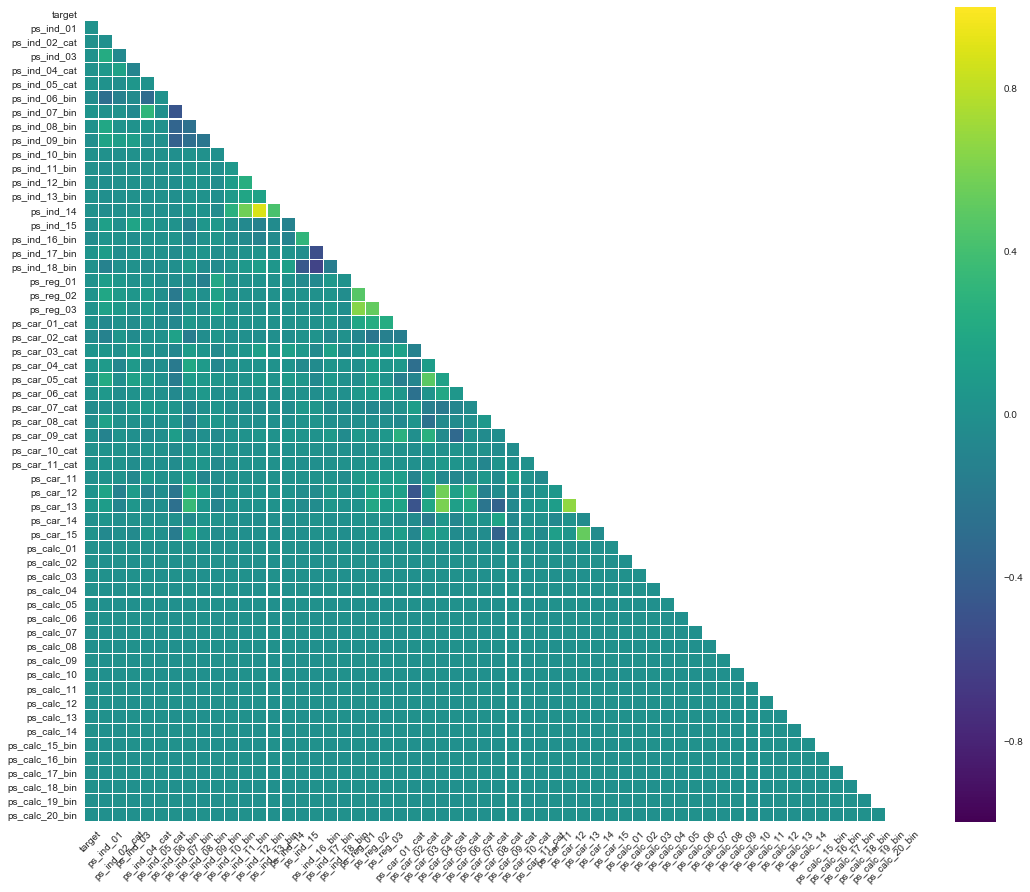

In [81]:
# plot it
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    p2 = sns.heatmap(corr_matrix, mask=mask, square=True, cmap='viridis', linewidths=0.1, linecolor='white')
    plt.xticks(rotation=45) 

In [75]:
# Droping the "calc" columns and rows from the correlation matrix (the bottom part of graph above, which basically show
# 0.0 correlations) in order to focus on the correlated data 
corr_matrix_sub=corr_matrix.loc['target' : 'ps_car_15', 'target' : 'ps_car_15']

In [76]:
corr_matrix_sub

target  ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  \
target         1.000000   0.018570       0.004534   0.008360       0.009360   
ps_ind_01      0.018570   1.000000      -0.001793   0.223408       0.066645   
ps_ind_02_cat  0.004534  -0.001793       1.000000  -0.061189       0.147110   
ps_ind_03      0.008360   0.223408      -0.061189   1.000000      -0.095856   
ps_ind_04_cat  0.009360   0.066645       0.147110  -0.095856       1.000000   
ps_ind_05_cat  0.029165   0.014823      -0.014860   0.053250       0.013053   
ps_ind_06_bin -0.034017  -0.277458      -0.125653  -0.045158      -0.297737   
ps_ind_07_bin  0.034218   0.005700       0.016398  -0.060368       0.304949   
ps_ind_08_bin  0.013147   0.188583       0.030945   0.014037       0.044978   
ps_ind_09_bin -0.008237   0.162800       0.110076   0.111306      -0.011442   
ps_ind_10_bin  0.001815   0.001847      -0.000744   0.006865       0.000789   
ps_ind_11_bin  0.002028  -0.016727       0.000772  -0.003986       0.001018   
ps_ind_12_bin  0.007810  -0.023406      -0.004616   0.001698      -0.001217   
ps_ind_13_bin  0.002460  -0.008776      -0.001187   0.003929      -0.000893   
ps_ind_14      0.007443  -0.024971      -0.003649   0.001990      -0.000691   
ps_ind_15     -0.021506   0.122137      -0.003854   0.170449       0.077071   
ps_ind_16_bin -0.027778   0.036896       0.012682  -0.018251       0.017497   
ps_ind_17_bin  0.037053   0.101257      -0.018727   0.027691       0.007830   
ps_ind_18_bin  0.004555  -0.112226      -0.000374   0.001316      -0.025797   
ps_reg_01      0.022888   0.102212       0.061118   0.003209       0.023846   
ps_reg_02      0.034800   0.183855       0.084260   0.048338       0.079471   
ps_reg_03      0.030888   0.139125       0.070790   0.002348       0.065702   
ps_car_01_cat  0.016256  -0.056121       0.002149  -0.028520       0.029379   
ps_car_02_cat -0.031534  -0.116987       0.045233  -0.044907       0.003162   
ps_car_03_cat  0.032401   0.043756      -0.002532   0.095658       0.022744   
ps_car_04_cat  0.032900   0.079042      -0.072190   0.072990      -0.045361   
ps_car_05_cat  0.020754   0.213009      -0.008407   0.143597       0.063399   
ps_car_06_cat  0.011537   0.070192      -0.017301   0.008021       0.025324   
ps_car_07_cat -0.036395  -0.000639      -0.011781   0.056337       0.064655   
ps_car_08_cat -0.020342   0.138112       0.001526   0.003607      -0.008148   
ps_car_09_cat  0.005322  -0.102582       0.009435  -0.013205      -0.041983   
ps_car_10_cat  0.001038   0.010794       0.011401  -0.008561       0.023010   
ps_car_11_cat  0.006129   0.008188       0.014955  -0.025966      -0.000615   
ps_car_11     -0.001213   0.008252       0.019949  -0.059358       0.073486   
ps_car_12      0.038790   0.161842      -0.110247   0.088992      -0.095160   
ps_car_13      0.053899   0.099752      -0.080408   0.048308      -0.032233   
ps_car_14     -0.004474   0.034480      -0.012272   0.000539      -0.005596   
ps_car_15      0.027667  -0.056722      -0.008391  -0.048096       0.040480   

               ps_ind_05_cat  ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin  \
target              0.029165      -0.034017       0.034218       0.013147   
ps_ind_01           0.014823      -0.277458       0.005700       0.188583   
ps_ind_02_cat      -0.014860      -0.125653       0.016398       0.030945   
ps_ind_03           0.053250      -0.045158      -0.060368       0.014037   
ps_ind_04_cat       0.013053      -0.297737       0.304949       0.044978   
ps_ind_05_cat       1.000000       0.009619      -0.010382       0.004881   
ps_ind_06_bin       0.009619       1.000000      -0.474009      -0.356838   
ps_ind_07_bin      -0.010382      -0.474009       1.000000      -0.260438   
ps_ind_08_bin       0.004881      -0.356838      -0.260438       1.000000   
ps_ind_09_bin      -0.005069      -0.384345      -0.280513      -0.211173   
ps_ind_10_bin       0.001742      -0.008978       0.010740       0.006489   
ps_ind_11_b

In [77]:
corr_matrix_sub['ps_ind_14']

target           0.007443
ps_ind_01       -0.024971
ps_ind_02_cat   -0.003649
ps_ind_03        0.001990
ps_ind_04_cat   -0.000691
ps_ind_05_cat   -0.001013
ps_ind_06_bin   -0.018334
ps_ind_07_bin    0.035573
ps_ind_08_bin    0.015413
ps_ind_09_bin   -0.031640
ps_ind_10_bin    0.266215
ps_ind_11_bin    0.564903
ps_ind_12_bin    0.890127
ps_ind_13_bin    0.426400
ps_ind_14        1.000000
ps_ind_15       -0.121547
ps_ind_16_bin   -0.106240
ps_ind_17_bin    0.022033
ps_ind_18_bin    0.121478
ps_reg_01        0.014093
ps_reg_02        0.009283
ps_reg_03        0.007607
ps_car_01_cat    0.016363
ps_car_02_cat   -0.018288
ps_car_03_cat    0.119269
ps_car_04_cat    0.029995
ps_car_05_cat    0.071320
ps_car_06_cat    0.005137
ps_car_07_cat   -0.037805
ps_car_08_cat   -0.013305
ps_car_09_cat    0.045080
ps_car_10_cat   -0.004273
ps_car_11_cat    0.012513
ps_car_11        0.004418
ps_car_12        0.019637
ps_car_13        0.022926
ps_car_14       -0.026969
ps_car_15       -0.004624
Name: ps_ind

Note the high correlation above b/w ps_ind_14 and ps_ind_12_bin; perhaps the same data, binned 

In [80]:
# plot it
mask = np.zeros_like(corr_matrix_sub) # array of zeroes of same shape as array 
mask[np.triu_indices_from(mask)] = True  #indices for upper triangle 
with sns.axes_style("white"):
    p2 = sns.heatmap(corr_matrix_sub, mask=mask, square=True, cmap='viridis', linewidths=0.1, linecolor='white')
    plt.xticks(rotation=45) 

In [82]:
# Selected pairwise distributions -- implies that the features may have already been de-correlated 
sns.pairplot(df1[['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_12_bin', 'ps_ind_14']], size=5)

** Clustering Analysis **

In [83]:
cluster_columns = ['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15']

In [84]:
from sklearn import preprocessing
scaler = preprocessing.MaxAbsScaler()

insurance_clusters = scaler.fit_transform(df_train[cluster_columns])
insurance_clusters = pd.DataFrame(insurance_clusters, columns=cluster_columns)

In [85]:
from sklearn.cluster import KMeans

def kmeans_cluster(df, n_clusters=2):
    model = KMeans(n_clusters=n_clusters, random_state=15)
    clusters = model.fit_predict(df)
    cluster_results = df.copy()
    cluster_results['cluster'] = clusters
    return cluster_results

In [86]:
def summarize_clustering(results):
    cluster_size = results.groupby(['cluster']).size().reset_index()
    cluster_size.columns = ['cluster', 'count']
    cluster_means = results.groupby(['cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='cluster')
    return cluster_summary

In [87]:
cluster_results = kmeans_cluster(insurance_clusters, 10)
cluster_summary = summarize_clustering(cluster_results)
cluster_summary

cluster   count  ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  \
0        0   63632   0.253233       0.363119   0.338073       0.814936   
1        1   57826   0.197183       0.302355   0.445941       0.238267   
2        2   68534   0.430810       0.341943   0.452032       0.407856   
3        3  104139   0.171814       0.317912   0.367545       0.238201   
4        4   46942   0.329629       0.333758   0.395887       0.697606   
5        5   72427   0.313752       0.375326   0.416786       0.320212   
6        6   74640   0.364316       0.356940   0.455594       0.566184   
7        7   54504   0.172981       0.319710   0.372350       0.191582   
8        8   13171   0.233012       0.371764   0.274922       0.342495   
9        9   39397   0.222573       0.336777   0.408674       0.419753   

   ps_ind_05_cat  ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin    ...      \
0       0.070523       0.000000       0.757308       0.242692    ...       
1       0.074079       0.999620       0.000000       0.000346    ...       
2       0.075033       0.233475       0.000000       0.427248    ...       
3       0.075562       1.000000       0.000000       0.000000    ...       
4       0.060379       0.000000       1.000000       0.000000    ...       
5       0.062635       0.000000       0.000000       0.187941    ...       
6       0.068386       0.000523       0.439992       0.315086    ...       
7       0.067720       0.734368       0.082985       0.160098    ...       
8      -0.027801       0.196265       0.610888       0.114646    ...       
9       0.066325       0.349417       0.315963       0.138538    ...       

   ps_car_07_cat  ps_car_08_cat  ps_car_09_cat  ps_car_10_cat  ps_car_11_cat  \
0       0.963619       0.835979       0.420178       0.497627       0.601575   
1       0.949850       0.736295       0.442167       0.493636       0.580481   
2       0.944626       0.928036       0.093184       0.497709       0.604436   
3       0.953476       0.882244       0.387626       0.493758       0.584241   
4       0.968855       0.853095       0.124036       0.498764       0.626701   
5       0.941141       0.895522       0.375595       0.495230       0.572633   
6       0.964831       0.647736       0.441707       0.498988       0.598489   
7       0.927198       0.876670       0.396792       0.493101       0.588801   
8      -0.872219       0.609369       0.425290       0.498026       0.763736   
9       0.930934       0.887200       0.138615       0.496611       0.615383   

   ps_car_11  ps_car_12  ps_car_13  ps_car_14  ps_car_15  
0   0.845418   0.303570   0.226857   0.286440   0.866380  
1   0.809399   0.289586   0.205618   0.163851   0.803206  
2   0.696992   0.303224   0.207794   0.321916   0.756317  
3   0.800462   0.286721   0.197465   0.310247   0.788445  
4   0.757786   0.320865   0.251735   0.284857   0.861483  
5   0.763656   0.297618   0.209377   0.330394   0.823957  
6   0.829484   0.307507   0.240869   0.190231   0.892283  
7   0.774255   0.292778   0.202523   0.319466   0.786692  
8   0.814314   0.347693   0.334922   0.173789   0.882341  
9   0.711315   0.303984   0.217361   0.283202   0.786399  

[10 rows x 39 columns]

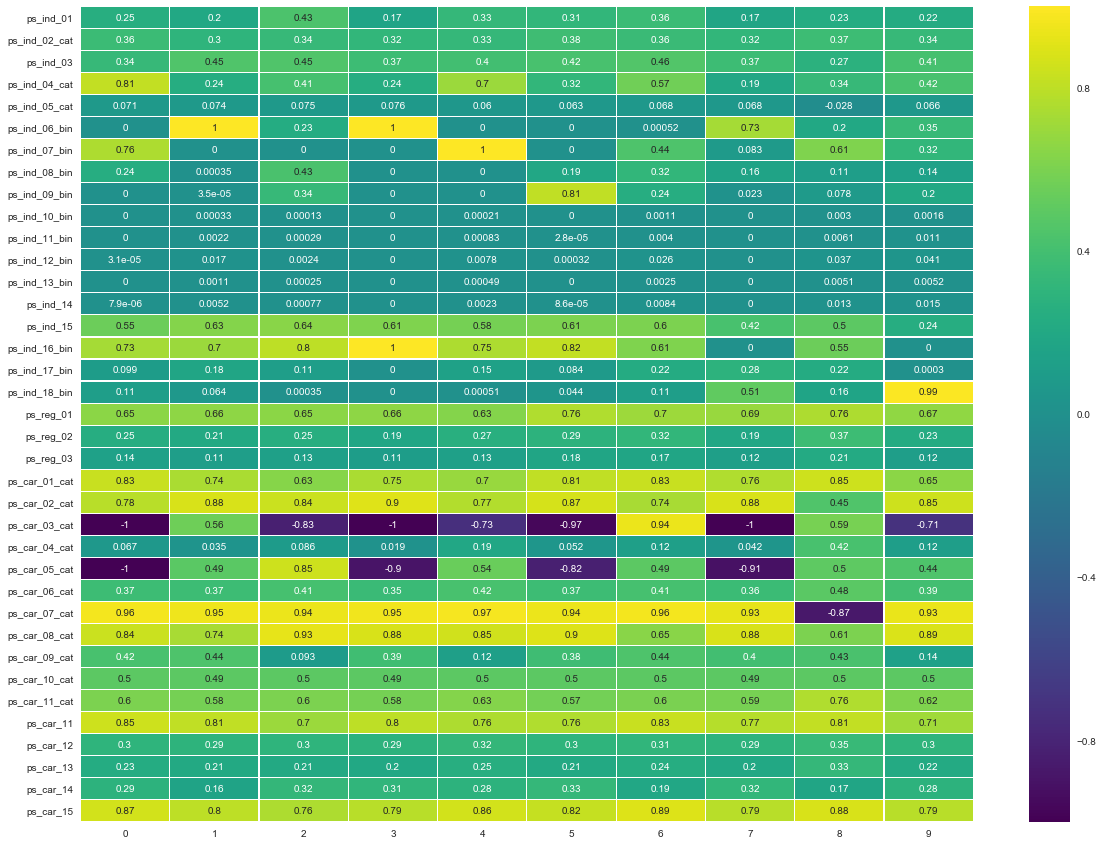

In [88]:
sns.heatmap(cluster_summary[cluster_columns].transpose(), annot=True, cmap='viridis', linewidths=0.1, linecolor='white')

In [89]:
# Cut down the number of clusters 
cluster_results = kmeans_cluster(insurance_clusters,6)
cluster_summary = summarize_clustering(cluster_results)

sns.heatmap(cluster_summary[cluster_columns].transpose(), annot=True, cmap='viridis', linewidths=0.1, linecolor='white')

In [90]:
cluster_results['cluster'][:10]

0    0
1    3
2    3
3    4
4    5
5    3
6    0
7    4
8    0
9    2
Name: cluster, dtype: int32

In [97]:
df_train['ps_cluster_cat']= cluster_results['cluster']

In [98]:
df_train.head()

id  target  ps_ind_01  ps_ind_02_cat  ps_ind_03  ps_ind_04_cat  \
0   7       0          2              2          5              1   
1   9       0          1              1          7              0   
2  13       0          5              4          9              1   
3  16       0          0              1          2              0   
4  17       0          0              2          0              1   

   ps_ind_05_cat  ps_ind_06_bin  ps_ind_07_bin  ps_ind_08_bin       ...        \
0              0              0              1              0       ...         
1              0              0              0              1       ...         
2              0              0              0              1       ...         
3              0              1              0              0       ...         
4              0              1              0              0       ...         

   ps_calc_12  ps_calc_13  ps_calc_14  ps_calc_15_bin  ps_calc_16_bin  \
0           1           5           8               0               1   
1           1           1           9               0               1   
2           2           7           7               0               1   
3           2           4           9               0               0   
4           1           1           3               0               0   

   ps_calc_17_bin  ps_calc_18_bin  ps_calc_19_bin  ps_calc_20_bin  \
0               1               0               0               1   
1               1               0               1               0   
2               1               0               1               0   
3               0               0               0               0   
4               0               1               1               0   

   ps_cluster_cat  
0               0  
1               3  
2               3  
3               4  
4               5  

[5 rows x 60 columns]

Additional Exploration by Feature Type and Category... 

In [99]:
# Type 
binary_feat = [c for c in df_train.columns if c.endswith("bin")]
categorical_feat = [c for c in df_train.columns if c.endswith("cat")]
continuous_feat = [c for c in df_train.columns if ((c not in binary_feat) & (c not in categorical_feat))]

# Category 
ind_feat = [c for c in df_train.columns if c.startswith("ps_ind")]
reg_feat = [c for c in df_train.columns if c.startswith("ps_reg")]
car_feat = [c for c in df_train.columns if c.startswith("ps_car")]
calc_feat = [c for c in df_train.columns if c.startswith("ps_calc")]

# Target
target = ['target']

In [101]:
# Check 
print("Binary feat :", binary_feat)
print("-" * 60)
print("Categorical feat : ", categorical_feat)
print("-" * 60)
print("Ind feat :", ind_feat)
print("-" * 60)
print("Reg feat : ", reg_feat)
print("-" * 60)
print("Car feat :", car_feat)
print("-" * 60)
print("Calc feat : ", calc_feat)


Binary feat : ['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']
------------------------------------------------------------
Categorical feat :  ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_cluster_cat']
------------------------------------------------------------
Ind feat : ['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_in

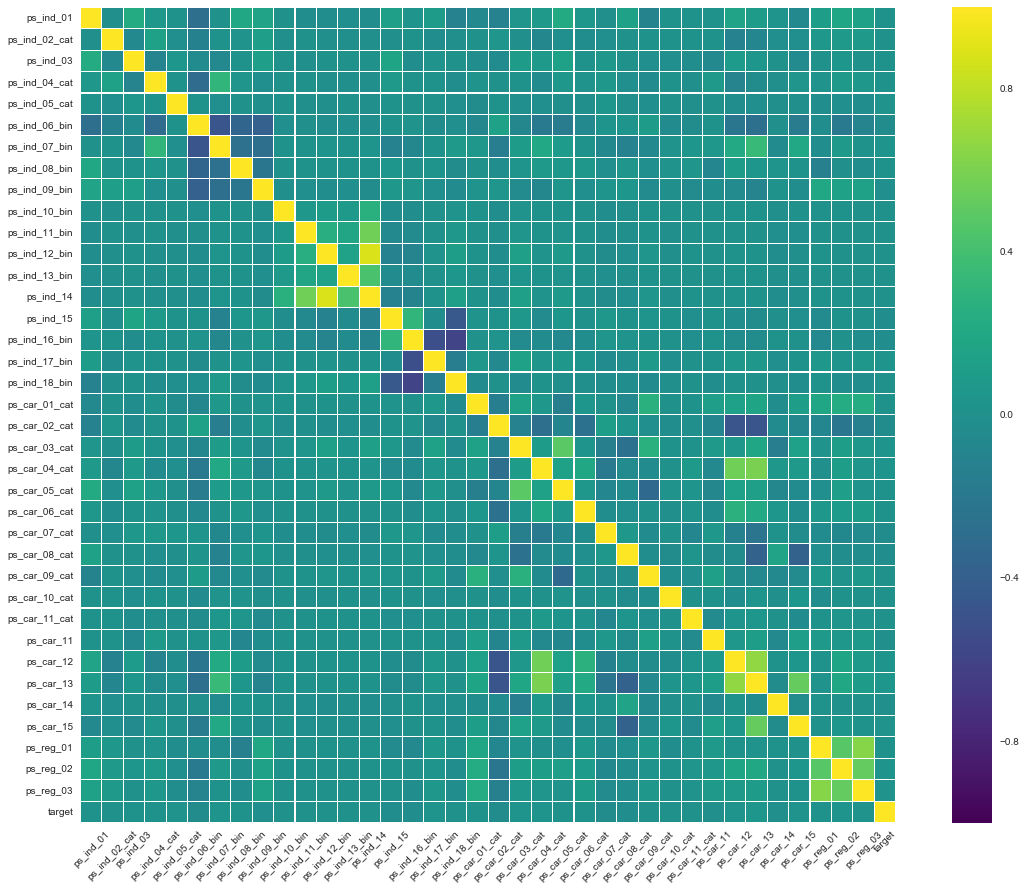

In [105]:
# Heatmap with calculated columns removed 
sns.heatmap(df_train[ind_feat + car_feat + reg_feat + target].corr(), square=True, cmap='viridis', linewidths=0.1, linecolor='white')
plt.xticks(rotation=45)
plt.show()

** Data Prep **

Start by merging the train and test datasets in order to align all data transformations; can extract train and test data later 

In [106]:
# Read clean train dataset back in 
df_train=pd.read_csv('train.csv')
df_train.shape

(595212, 59)

In [107]:
# Add a dummy target value to df_test to align with df_train 
df_test['target']=-1

In [108]:
df_test.shape

(892816, 59)

In [109]:
# Merge df_train and df_test 
df_train_test=df_train.append(df_test, ignore_index=True)

In [110]:
df_train_test.shape

(1488028, 59)

In [111]:
df_train_test.head(2)

id  ps_calc_01  ps_calc_02  ps_calc_03  ps_calc_04  ps_calc_05  ps_calc_06  \
0   7         0.6         0.5         0.2           3           1          10   
1   9         0.3         0.1         0.3           2           1           9   

   ps_calc_07  ps_calc_08  ps_calc_09   ...    ps_ind_13_bin  ps_ind_14  \
0           1          10           1   ...                0          0   
1           5           8           1   ...                0          0   

   ps_ind_15  ps_ind_16_bin  ps_ind_17_bin  ps_ind_18_bin  ps_reg_01  \
0         11              0              1              0        0.7   
1          3              0              0              1        0.8   

   ps_reg_02  ps_reg_03  target  
0        0.2   0.718070       0  
1        0.4   0.766078       0  

[2 rows x 59 columns]

In [112]:
df_train_test.dtypes

id                  int64
ps_calc_01        float64
ps_calc_02        float64
ps_calc_03        float64
ps_calc_04          int64
ps_calc_05          int64
ps_calc_06          int64
ps_calc_07          int64
ps_calc_08          int64
ps_calc_09          int64
ps_calc_10          int64
ps_calc_11          int64
ps_calc_12          int64
ps_calc_13          int64
ps_calc_14          int64
ps_calc_15_bin      int64
ps_calc_16_bin      int64
ps_calc_17_bin      int64
ps_calc_18_bin      int64
ps_calc_19_bin      int64
ps_calc_20_bin      int64
ps_car_01_cat       int64
ps_car_02_cat       int64
ps_car_03_cat       int64
ps_car_04_cat       int64
ps_car_05_cat       int64
ps_car_06_cat       int64
ps_car_07_cat       int64
ps_car_08_cat       int64
ps_car_09_cat       int64
ps_car_10_cat       int64
ps_car_11           int64
ps_car_11_cat       int64
ps_car_12         float64
ps_car_13         float64
ps_car_14         float64
ps_car_15         float64
ps_ind_01           int64
ps_ind_02_ca

In [113]:
df_train_test.to_csv("train_test_unprocessed", index=False)

In [114]:
# Change categorical columns to pandas dtype 'categorical'
categorical_feat = [c for c in df_train_test.columns if c.endswith("cat")]
for col in categorical_feat :
    df_train_test[col] = df_train_test[col].astype('category')

In [115]:
df_train_test.dtypes

id                   int64
ps_calc_01         float64
ps_calc_02         float64
ps_calc_03         float64
ps_calc_04           int64
ps_calc_05           int64
ps_calc_06           int64
ps_calc_07           int64
ps_calc_08           int64
ps_calc_09           int64
ps_calc_10           int64
ps_calc_11           int64
ps_calc_12           int64
ps_calc_13           int64
ps_calc_14           int64
ps_calc_15_bin       int64
ps_calc_16_bin       int64
ps_calc_17_bin       int64
ps_calc_18_bin       int64
ps_calc_19_bin       int64
ps_calc_20_bin       int64
ps_car_01_cat     category
ps_car_02_cat     category
ps_car_03_cat     category
ps_car_04_cat     category
ps_car_05_cat     category
ps_car_06_cat     category
ps_car_07_cat     category
ps_car_08_cat     category
ps_car_09_cat     category
ps_car_10_cat     category
ps_car_11            int64
ps_car_11_cat     category
ps_car_12          float64
ps_car_13          float64
ps_car_14          float64
ps_car_15          float64
p

In [116]:
# Drop the high Nan columns 
high_nan_cols=['ps_reg_03', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_14']
df_train_test.drop(high_nan_cols, axis=1, inplace=True)

In [117]:
df_train_test.shape

(1488028, 55)

In [118]:
# Add in clusters 
print(cluster_columns)

['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15']


In [119]:
# Remove the the high Nan columns from the cluster column list 
cluster_columns=list(set(cluster_columns)-set(high_nan_cols))
print(cluster_columns)

['ps_ind_17_bin', 'ps_car_15', 'ps_ind_11_bin', 'ps_ind_18_bin', 'ps_car_13', 'ps_reg_02', 'ps_car_11', 'ps_car_07_cat', 'ps_car_11_cat', 'ps_ind_10_bin', 'ps_ind_16_bin', 'ps_car_10_cat', 'ps_ind_07_bin', 'ps_ind_13_bin', 'ps_car_02_cat', 'ps_ind_14', 'ps_ind_09_bin', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_01', 'ps_ind_08_bin', 'ps_ind_12_bin', 'ps_car_12', 'ps_ind_02_cat', 'ps_car_04_cat', 'ps_ind_06_bin', 'ps_reg_01', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_08_cat', 'ps_car_06_cat', 'ps_car_09_cat', 'ps_ind_15']


In [120]:
from sklearn import preprocessing
scaler = preprocessing.MaxAbsScaler()

insurance_clusters = scaler.fit_transform(df_train_test[cluster_columns])
insurance_clusters = pd.DataFrame(insurance_clusters, columns=cluster_columns)

In [121]:
from sklearn.cluster import KMeans

def kmeans_cluster(df, n_clusters=2):
    model = KMeans(n_clusters=n_clusters, random_state=15)
    clusters = model.fit_predict(df)
    cluster_results = df.copy()
    cluster_results['cluster'] = clusters
    return cluster_results

In [122]:
def summarize_clustering(results):
    cluster_size = results.groupby(['cluster']).size().reset_index()
    cluster_size.columns = ['cluster', 'count']
    cluster_means = results.groupby(['cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='cluster')
    return cluster_summary

In [123]:
cluster_results = kmeans_cluster(insurance_clusters, 10)
cluster_summary = summarize_clustering(cluster_results)
cluster_summary

cluster   count  ps_ind_17_bin  ps_car_15  ps_ind_11_bin  ps_ind_18_bin  \
0        0  112886       1.000000   0.845775       0.002693       0.000000   
1        1  104397       0.000000   0.763328       0.000096       0.000000   
2        2  175379       0.000000   0.830523       0.000297       0.000559   
3        3  224501       0.000000   0.809153       0.007630       1.000000   
4        4  297231       0.000000   0.789606       0.000071       0.000000   
5        5   72269       0.000000   0.895247       0.000401       0.000000   
6        6  171570       0.000000   0.878467       0.000286       0.000000   
7        7   29558       0.187868   0.882869       0.004770       0.170445   
8        8  208895       0.000000   0.812166       0.000081       0.000278   
9        9   91342       0.669177   0.782993       0.001040       0.000000   

   ps_car_13  ps_reg_02  ps_car_11  ps_car_07_cat    ...      ps_ind_02_cat  \
0   0.216595   0.287695   0.786194       0.927369    ...           0.345501   
1   0.173096   0.196737   0.791878       0.977768    ...           0.336372   
2   0.207380   0.241438   0.734655       0.934787    ...           0.352978   
3   0.199184   0.226382   0.763480       0.936223    ...           0.339417   
4   0.186025   0.189182   0.792739       0.946328    ...           0.306368   
5   0.248517   0.251044   0.772789       0.953286    ...           0.316969   
6   0.216785   0.276801   0.831647       0.975520    ...           0.359050   
7   0.314510   0.377954   0.827480      -0.975032    ...           0.377800   
8   0.191006   0.315359   0.775107       0.955150    ...           0.376714   
9   0.186357   0.200460   0.784214       0.931828    ...           0.304433   

   ps_car_04_cat  ps_ind_06_bin  ps_reg_01  ps_ind_05_cat  ps_car_01_cat  \
0       0.131145       0.000027   0.731926       0.074643       0.803731   
1       0.009410       1.000000   0.657400       0.076211       0.739056   
2       0.117489       0.000000   0.563778       0.072460       0.748385   
3       0.082363       0.383384   0.691275       0.065050       0.727220   
4       0.027663       1.000000   0.646118       0.073660       0.733328   
5       0.213609       0.000000   0.611815       0.055215       0.766079   
6       0.097430       0.000000   0.662122       0.066474       0.770720   
7       0.425281       0.216963   0.755366      -0.035501       0.854259   
8       0.043326       0.000000   0.801156       0.068313       0.769789   
9       0.033736       1.000000   0.715859       0.073592       0.743373   

   ps_car_08_cat  ps_car_06_cat  ps_car_09_cat  ps_ind_15  
0       0.816620       0.425645       0.368593   0.536396  
1       0.864010       0.378898       0.363681   0.673441  
2       0.874580       0.430267       0.313983   0.660942  
3       0.812228       0.377674       0.303728   0.272249  
4       0.850615       0.351971       0.369663   0.607774  
5       0.754694       0.396444       0.287163   0.544848  
6       0.783779       0.382113       0.294257   0.608033  
7       0.602544       0.492177       0.423726   0.506415  
8       0.873592       0.376905       0.309522   0.642390  
9       0.855127       0.375569       0.361414   0.590830  

[10 rows x 35 columns]

In [124]:
cluster_results['cluster'][:10]

0    0
1    3
2    2
3    4
4    1
5    8
6    6
7    4
8    2
9    3
Name: cluster, dtype: int32

In [125]:
# Repeated this with clusters of 10,100
df_train_test['ps_cluster10_cat']= cluster_results['cluster'].astype('category')

In [126]:
df_train_test.dtypes

id                     int64
ps_calc_01           float64
ps_calc_02           float64
ps_calc_03           float64
ps_calc_04             int64
ps_calc_05             int64
ps_calc_06             int64
ps_calc_07             int64
ps_calc_08             int64
ps_calc_09             int64
ps_calc_10             int64
ps_calc_11             int64
ps_calc_12             int64
ps_calc_13             int64
ps_calc_14             int64
ps_calc_15_bin         int64
ps_calc_16_bin         int64
ps_calc_17_bin         int64
ps_calc_18_bin         int64
ps_calc_19_bin         int64
ps_calc_20_bin         int64
ps_car_01_cat       category
ps_car_02_cat       category
ps_car_04_cat       category
ps_car_06_cat       category
ps_car_07_cat       category
ps_car_08_cat       category
ps_car_09_cat       category
ps_car_10_cat       category
ps_car_11              int64
ps_car_11_cat       category
ps_car_12            float64
ps_car_13            float64
ps_car_15            float64
ps_ind_01     

In [127]:
gc.collect()

19572

In [128]:
# df_train_test.to_csv("train_test_processed_v2", index=False)
df_train_test=pd.read_csv("train_test_processed_v2")

In [129]:
df_train_test.columns

Index(['id', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11', 'ps_car_11_cat',
       'ps_car_12', 'ps_car_13', 'ps_car_15', 'ps_ind_01', 'ps_ind_02_cat',
       'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin',
       'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin',
       'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14',
       'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin',
       'ps_reg_01', 'ps_reg_02', 'target', 'ps_cluster50_cat',
       'ps_cluster10_cat'],
      dtype='object'

In [130]:
df_train_processed=df_train_test.loc[df_train_test['target']!= -1]
df_test_processed=df_train_test.loc[df_train_test['target'] == -1]

In [ ]:
# Read in the unprocessed data 
df_train_test_unprocessed=pd.read_csv("train_test_unprocessed")
df_train_unprocessed=df_train_test_unprocessed.loc[df_train_test_unprocessed['target']!= -1]
df_test_unprocessed=df_train_test_unprocessed.loc[df_train_test_unprocessed['target'] == -1]

In [ ]:
df_train_test_unprocessed['ps_cluster50_cat']=df_train_test['ps_cluster50_cat']
df_train_test_unprocessed['ps_cluster10_cat']=df_train_test['ps_cluster10_cat']

In [ ]:
df_train_test_unprocessed_wclusters=df_train_test_unprocessed

In [131]:
#df_train_test_unprocessed_wclusters.to_csv("train_test_unprocessed_wclusters", index=False)
df_train_test_unprocessed_wclusters=pd.read_csv("train_test_unprocessed_wclusters")

In [132]:
df_train_test_unprocessed_wclusters.dtypes

id                    int64
ps_calc_01          float64
ps_calc_02          float64
ps_calc_03          float64
ps_calc_04            int64
ps_calc_05            int64
ps_calc_06            int64
ps_calc_07            int64
ps_calc_08            int64
ps_calc_09            int64
ps_calc_10            int64
ps_calc_11            int64
ps_calc_12            int64
ps_calc_13            int64
ps_calc_14            int64
ps_calc_15_bin        int64
ps_calc_16_bin        int64
ps_calc_17_bin        int64
ps_calc_18_bin        int64
ps_calc_19_bin        int64
ps_calc_20_bin        int64
ps_car_01_cat         int64
ps_car_02_cat         int64
ps_car_03_cat         int64
ps_car_04_cat         int64
ps_car_05_cat         int64
ps_car_06_cat         int64
ps_car_07_cat         int64
ps_car_08_cat         int64
ps_car_09_cat         int64
                     ...   
ps_car_11             int64
ps_car_11_cat         int64
ps_car_12           float64
ps_car_13           float64
ps_car_14           

In [133]:
df_train_unprocessed_wclusters=df_train_test_unprocessed_wclusters.loc[df_train_test_unprocessed_wclusters['target']!= -1]
df_test_unprocessed_wclusters=df_train_test_unprocessed_wclusters.loc[df_train_test_unprocessed_wclusters['target'] == -1]

In [134]:
gc.collect()

179

Data Prep - 2nd Round 

In [136]:
# Type 
binary_feat = [c for c in df_train_test_unprocessed_wclusters.columns if c.endswith("bin")]
categorical_feat = [c for c in df_train_test_unprocessed_wclusters.columns if c.endswith("cat")]
continuous_feat = [c for c in df_train_test_unprocessed_wclusters.columns if ((c not in binary_feat) & (c not in categorical_feat))]

# Category 
ind_feat = [c for c in df_train_test_unprocessed_wclusters.columns if c.startswith("ps_ind")]
reg_feat = [c for c in df_train_test_unprocessed_wclusters.columns if c.startswith("ps_reg")]
car_feat = [c for c in df_train_test_unprocessed_wclusters.columns if c.startswith("ps_car")]
calc_feat = [c for c in df_train_test_unprocessed_wclusters.columns if c.startswith("ps_calc")]

# Target
target = ['target']

In [137]:
print(binary_feat)

['ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin']


In [138]:
print(high_nan_cols)

['ps_reg_03', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_14']


In [140]:
print(calc_feat)

['ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']


In [141]:
print(categorical_feat)

['ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_cluster50_cat', 'ps_cluster10_cat']


In [143]:
feat_not_used=['ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_20_bin', 'ps_car_02_cat', 'ps_car_08_cat',
               'ps_car_10_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 
               'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_18_bin']

In [ ]:
# cluster_columns=list(set(cluster_columns)-set(high_nan_cols))
# df_train.columns.difference(df_test.columns)

In [144]:
# Binary columns contributing to prediction 
binary_feat_in_not_used = [c for c in feat_not_used if c.endswith("bin")]
bin_predictors=list(set(binary_feat)-set(binary_feat_in_not_used))
print(bin_predictors)
print("Length of bin_predictors : ", len(bin_predictors))

['ps_calc_19_bin', 'ps_ind_17_bin', 'ps_ind_16_bin', 'ps_calc_15_bin']
Length of bin_predictors :  4


In [145]:
# Categorical columns contributing to prediction 
cat_feat_in_not_used = [c for c in feat_not_used if c.endswith("cat")]
cat_predictors=list(set(categorical_feat)-set(cat_feat_in_not_used))
print(cat_predictors)
print("Length of cat_predictors : ", len(cat_predictors))

['ps_car_05_cat', 'ps_cluster10_cat', 'ps_car_03_cat', 'ps_ind_02_cat', 'ps_car_07_cat', 'ps_car_04_cat', 'ps_car_11_cat', 'ps_cluster50_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_06_cat', 'ps_ind_04_cat', 'ps_car_09_cat']
Length of cat_predictors :  13


In [146]:
# Calculated columns contributing to prediction 
calc_feat_in_not_used = [c for c in feat_not_used if c.startswith("ps_calc")]
calc_predictors=list(set(calc_feat)-set(calc_feat_in_not_used))
print(calc_predictors)
print("Length of calc_predictors : ", len(calc_predictors))

['ps_calc_01', 'ps_calc_04', 'ps_calc_14', 'ps_calc_09', 'ps_calc_13', 'ps_calc_11', 'ps_calc_07', 'ps_calc_19_bin', 'ps_calc_15_bin', 'ps_calc_10', 'ps_calc_02', 'ps_calc_05', 'ps_calc_06', 'ps_calc_12', 'ps_calc_08', 'ps_calc_03']
Length of calc_predictors :  16


In [147]:
# High Nan columns used in prediction 
high_nan_predictors=set(high_nan_cols).intersection(train_columns)
print(high_nan_predictors)

{'ps_car_14', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_reg_03'}


In [ ]:
# Look at the high NaN columns 

In [148]:
df_high_nan=df_train_test_unprocessed_wclusters[['id', 'ps_car_05_cat', 'ps_car_03_cat', 'ps_car_14', 'ps_reg_03']]

In [149]:
df_high_nan.describe()

id  ps_car_05_cat  ps_car_03_cat     ps_car_14     ps_reg_03
count  1.488028e+06   1.488028e+06   1.488028e+06  1.488028e+06  1.488028e+06
mean   7.440135e+05  -1.581623e-01  -5.048964e-01  2.763614e-01  5.514848e-01
std    4.295568e+05   8.445060e-01   7.887134e-01  3.569623e-01  7.938159e-01
min    0.000000e+00  -1.000000e+00  -1.000000e+00 -1.000000e+00 -1.000000e+00
25%    3.720068e+05  -1.000000e+00  -1.000000e+00  3.339162e-01  5.250000e-01
50%    7.440135e+05   0.000000e+00  -1.000000e+00  3.687818e-01  7.211103e-01
75%    1.116020e+06   1.000000e+00   0.000000e+00  3.964846e-01  1.001561e+00
max    1.488027e+06   1.000000e+00   1.000000e+00  6.363961e-01  4.423517e+00

In [150]:
print('ps_reg_03')
print('dtype : ', df_high_nan.ps_reg_03.dtype)
print('Unique values : ', df_high_nan.ps_reg_03.nunique())
print('Max value : ', df_high_nan.ps_reg_03.max())
print('Mean value : ', df_high_nan.ps_reg_03.mean())
print('Median value : ', df_high_nan.ps_reg_03.median())

ps_reg_03
dtype :  float64
Unique values :  5077
Max value :  4.4235167005
Mean value :  0.5514848059687841
Median value :  0.7211102551


ps_reg_03 - continuous values; should change the -1s to mean value (after dropping -1s from calc)

In [151]:
df_high_nan.replace(-1, np.nan, inplace=True)

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [152]:
df_high_nan.isnull().sum()

id                     0
ps_car_05_cat     666910
ps_car_03_cat    1028142
ps_car_14         106425
ps_reg_03         269456
dtype: int64

In [153]:
df_high_nan.ps_reg_03.mean()

0.8945559497971277

In [154]:
df_high_nan.ps_reg_03.fillna(df_high_nan.ps_reg_03.mean(), inplace=True)

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\pandas\core\generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [155]:
print('ps_car_03_cat')
print('dtype : ', df_high_nan.ps_car_03_cat.dtype)
print('Unique values : ', df_high_nan.ps_car_03_cat.nunique())
print('Max value : ', df_high_nan.ps_car_03_cat.max())
print('Mean value : ', df_high_nan.ps_car_03_cat.mean())
print('Median value : ', df_high_nan.ps_car_03_cat.median())
df_high_nan.ps_car_03_cat.value_counts()

ps_car_03_cat
dtype :  float64
Unique values :  2
Max value :  1.0
Mean value :  0.6019796210365177
Median value :  1.0


1.0    276842
0.0    183044
Name: ps_car_03_cat, dtype: int64

Virtually all are Nans (as replaced by -1)

In [156]:
print('ps_car_05_cat')
print('dtype : ', df_high_nan.ps_car_05_cat.dtype)
print('Unique values : ', df_high_nan.ps_car_05_cat.nunique())
print('Max value : ', df_high_nan.ps_car_05_cat.max())
print('Mean value : ', df_high_nan.ps_car_05_cat.mean())
print('Median value : ', df_high_nan.ps_car_05_cat.median())
print('Value counts:  ', df_high_nan.ps_car_05_cat.value_counts())


ps_car_05_cat
dtype :  float64
Unique values :  2
Max value :  1.0
Mean value :  0.5255761047742225
Median value :  1.0
Value counts:   1.0    431560
0.0    389558
Name: ps_car_05_cat, dtype: int64


About 40% Nans, categoricals 

In [157]:
df_high_nan.ps_car_05_cat.fillna(2, inplace=True)

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\pandas\core\generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [158]:
print('ps_car_14')
print('dtype : ', df_high_nan.ps_car_14.dtype)
print('Unique values : ', df_high_nan.ps_car_14.nunique())
print('Max value : ', df_high_nan.ps_car_14.max())
print('Mean value : ', df_high_nan.ps_car_14.mean())
print('Median value : ', df_high_nan.ps_car_14.median())

ps_car_14
dtype :  float64
Unique values :  904
Max value :  0.6363961031
Mean value :  0.3746795999562145
Median value :  0.3734969879


Continuous values; should change the -1s to mean value (after dropping the -1s from calc)

In [159]:
df_high_nan.ps_car_14.fillna(df_high_nan.ps_car_14.mean(), inplace=True)

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\pandas\core\generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [160]:
df_high_nan.head(2)

id  ps_car_05_cat  ps_car_03_cat  ps_car_14  ps_reg_03
0   7            1.0            NaN   0.370810   0.718070
1   9            2.0            NaN   0.388716   0.766078

In [161]:
df_high_nan.shape

(1488028, 5)

In [162]:
df_train_test_unprocessed_wclusters.shape

(1488028, 61)

In [163]:
df_train_test_processed_wclusters_v2=df_high_nan.merge(df_train_test_unprocessed_wclusters, how='left', on='id')

In [164]:
df_train_test_processed_wclusters_v2.shape

(1488028, 65)

In [165]:
df_train_test_processed_wclusters_v2.columns 

Index(['id', 'ps_car_05_cat_x', 'ps_car_03_cat_x', 'ps_car_14_x',
       'ps_reg_03_x', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat_y', 'ps_car_04_cat', 'ps_car_05_cat_y', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11', 'ps_car_11_cat', 'ps_car_12', 'ps_car_13', 'ps_car_14_y',
       'ps_car_15', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17

In [166]:
df_train_test_processed_wclusters_v2.drop(['ps_car_05_cat_y', 'ps_car_03_cat_y', 'ps_car_14_y',
       'ps_reg_03_y'], axis=1)

id  ps_car_05_cat_x  ps_car_03_cat_x  ps_car_14_x  ps_reg_03_x  \
0              7              1.0              NaN     0.370810     0.718070   
1              9              2.0              NaN     0.388716     0.766078   
2             13              2.0              NaN     0.347275     0.894556   
3             16              1.0              0.0     0.294958     0.580948   
4             17              2.0              NaN     0.365103     0.840759   
5             19              0.0              NaN     0.406202     2.332649   
6             20              1.0              NaN     0.368782     0.617454   
7             22              0.0              0.0     0.374833     0.607248   
8             26              1.0              NaN     0.407431     0.901388   
9             28              0.0              0.0     0.390256     2.316652   
10            34              2.0              NaN     0.429535     0.795692   
11            35              2.0              NaN     0.379342     0.378319   
12            36              2.0              NaN     0.385097     0.548293   
13            43              1.0              0.0     0.356090     0.684197   
14            46              2.0              NaN     0.358329     1.052972   
15            48              1.0              NaN     0.532917     0.894556   
16            50              2.0              NaN     0.349857     0.699553   
17            58              0.0              1.0     0.320780     0.810864   
18            61              2.0              NaN     0.366333     0.894556   
19            64              2.0              NaN     0.361248     0.402337   
20            65              2.0              NaN     0.370270     1.372725   
21            66              2.0              NaN     0.358329     0.955903   
22            72              0.0              0.0     0.368375     0.742041   
23            74              0.0              NaN     0.401373     0.894556   
24            77              0.0              NaN     0.412916     0.587367   
25            78              1.0              NaN     0.527731     0.894556   
26            79              1.0              NaN     0.400000     0.666146   
27            80              0.0              NaN     0.368782     1.034408   
28            84              1.0              NaN     0.441588     0.894556   
29            85              1.0              NaN     0.382099     1.155692   
...          ...              ...              ...          ...          ...   
1487998  1487982              0.0              NaN     0.358329     0.649519   
1487999  1487984              0.0              1.0     0.299166     0.490535   
1488000  1487985              2.0              NaN     0.317648     1.022252   
1488001  1487986              2.0              NaN     0.375500     0.609816   
1488002  1487987              1.0              NaN     0.390512     1.027436   
1488003  1487989              2.0              NaN     0.374680     0.752080   
1488004  1487991              0.0              NaN     0.425441     0.637868   
1488005  1487993              1.0              NaN     0.388716     0.791360   
1488006  1487995              0.0              NaN     0.381445     1.108772   
1488007  1487997              1.0              NaN     0.358329     0.942404   
1488008  1487998              0.0              0.0     0.298329     0.456207   
1488009  1487999              2.0              NaN     0.423084     0.894556   
1488010  1488000              1.0              1.0     0.325576     2.077709   
1488011  1488002              0.0              1.0     0.314484     0.748331   
1488012  1488003              2.0              NaN     0.400000     0.894556   
1488013  1488004              1.0              NaN     0.344964     0.856227   
1488014  1488006              0.0              NaN     0.368511     0.707107   
1488015  1488007              2.0              NaN     0.390768     0.656696   
1488016  14880

In [167]:
df_train_test_processed_wclusters_v2.rename(columns={'ps_car_05_cat_x' : 'ps_car_05_cat', 'ps_car_03_cat_x' : 'ps_car_03_cat', 
                                                     'ps_car_14_x' : 'ps_car_14', 'ps_reg_03_x': 'ps_reg_03' }, inplace=True)

In [168]:
df_train_test_processed_wclusters_v2.drop('ps_car_03_cat', axis=1, inplace=True)

In [169]:
df_train_test_processed_wclusters_v2.shape

(1488028, 64)

In [170]:
df_train_test_processed_wclusters_v2.drop(['ps_ind_11_bin', 'ps_ind_13_bin', 'ps_ind_10_bin'], axis=1, inplace=True)

In [ ]:
# # Datasets with highes nans handled (1 dropped b/c >50% Nans, others use mean, etc), 3 columns providing no-predictive value across models removed  
# df_train_test_processed_wclusters_v2.to_csv('train_test_processed_wclusters_v2', index=False)

In [171]:
df_train_test_processed_wclusters_v2.isnull().sum()

id                  0
ps_car_05_cat       0
ps_car_14           0
ps_reg_03           0
ps_calc_01          0
ps_calc_02          0
ps_calc_03          0
ps_calc_04          0
ps_calc_05          0
ps_calc_06          0
ps_calc_07          0
ps_calc_08          0
ps_calc_09          0
ps_calc_10          0
ps_calc_11          0
ps_calc_12          0
ps_calc_13          0
ps_calc_14          0
ps_calc_15_bin      0
ps_calc_16_bin      0
ps_calc_17_bin      0
ps_calc_18_bin      0
ps_calc_19_bin      0
ps_calc_20_bin      0
ps_car_01_cat       0
ps_car_02_cat       0
ps_car_03_cat_y     0
ps_car_04_cat       0
ps_car_05_cat_y     0
ps_car_06_cat       0
                   ..
ps_car_08_cat       0
ps_car_09_cat       0
ps_car_10_cat       0
ps_car_11           0
ps_car_11_cat       0
ps_car_12           0
ps_car_13           0
ps_car_14_y         0
ps_car_15           0
ps_ind_01           0
ps_ind_02_cat       0
ps_ind_03           0
ps_ind_04_cat       0
ps_ind_05_cat       0
ps_ind_06_

In [172]:
df_train=df_train_test_processed_wclusters_v2.loc[df_train_test_processed_wclusters_v2['target']!= -1]
df_test=df_train_test_processed_wclusters_v2.loc[df_train_test_processed_wclusters_v2['target'] == -1]

In [173]:
# Change categorical columns to pandas dtype 'categorical'
categorical_feat = [c for c in df_train_test_processed_wclusters_v2.columns if c.endswith("cat")]
for col in categorical_feat :
    df_train_test_processed_wclusters_v2[col] = df_train_test_processed_wclusters_v2[col].astype('category')

In [174]:
# Datasets with highes nans handled (1 dropped b/c >50% Nans, others use mean, etc), 3 columns providing no-predictive value 
# across models removed; changed to categoricals 
df_train_test_processed_wclusters_v2.to_csv('train_test_processed_wclusters_v3', index=False)

In [175]:
df_train=df_train_test_processed_wclusters_v2.loc[df_train_test_processed_wclusters_v2['target']!= -1]
df_test=df_train_test_processed_wclusters_v2.loc[df_train_test_processed_wclusters_v2['target'] == -1]

V3 (categorical types) is performing noticeably worse in LightGBM than the non-categorical.  Revert to v2 

In [ ]:
# # Add 100-cluster column 
# df_train_test_processed_wclusters_v2=pd.read_csv('train_test_processed_wclusters_v2')

In [176]:
cluster_columns = ['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15']

dropped_cols=['ps_ind_11_bin', 'ps_ind_13_bin', 'ps_ind_10_bin', 'ps_car_03_cat']

cluster_columns2=list(set(cluster_columns)-set(dropped_cols))
                      
print(cluster_columns2)                  


['ps_ind_17_bin', 'ps_car_15', 'ps_ind_18_bin', 'ps_car_13', 'ps_reg_02', 'ps_car_11', 'ps_car_07_cat', 'ps_car_11_cat', 'ps_ind_16_bin', 'ps_car_10_cat', 'ps_ind_07_bin', 'ps_car_02_cat', 'ps_ind_14', 'ps_ind_09_bin', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_01', 'ps_ind_08_bin', 'ps_ind_12_bin', 'ps_car_05_cat', 'ps_car_12', 'ps_ind_02_cat', 'ps_car_04_cat', 'ps_car_14', 'ps_ind_06_bin', 'ps_reg_01', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_reg_03', 'ps_car_08_cat', 'ps_car_06_cat', 'ps_car_09_cat', 'ps_ind_15']


In [177]:
from sklearn import preprocessing
scaler = preprocessing.MaxAbsScaler()

insurance_clusters = scaler.fit_transform(df_train_test_processed_wclusters_v2[cluster_columns2])
insurance_clusters = pd.DataFrame(insurance_clusters, columns=cluster_columns2)

In [178]:
from sklearn.cluster import KMeans

def kmeans_cluster(df, n_clusters=2):
    model = KMeans(n_clusters=n_clusters, random_state=15)
    clusters = model.fit_predict(df)
    cluster_results = df.copy()
    cluster_results['cluster'] = clusters
    return cluster_results

In [179]:
def summarize_clustering(results):
    cluster_size = results.groupby(['cluster']).size().reset_index()
    cluster_size.columns = ['cluster', 'count']
    cluster_means = results.groupby(['cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='cluster')
    return cluster_summary

In [ ]:
cluster_results = kmeans_cluster(insurance_clusters, 100)
cluster_summary = summarize_clustering(cluster_results)
cluster_summary

In [ ]:
df_train_test_processed_wclusters_v2['ps_cluster100_cat']= cluster_results['cluster']
df_train_test_processed_wclusters_v2['ps_cluster100_cat'][:10]   

In [180]:
# df_train_test_processed_wclusters_v2.to_csv('train_test_processed_v4', index=False)
df_train_test_processed_wclusters_v2=pd.read_csv('train_test_processed_v4')

In [181]:
df_train=df_train_test_processed_wclusters_v2.loc[df_train_test_processed_wclusters_v2['target']!= -1]
df_test=df_train_test_processed_wclusters_v2.loc[df_train_test_processed_wclusters_v2['target'] == -1]

In [182]:
gc.collect()

574

Data Prep -- 3rd Round 

In [183]:
df_train_test_processed_wclusters_v2.shape

(1488028, 62)

In [184]:
df_train_test_processed_wclusters_v2.columns.sort_values()

Index(['id', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat_y', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_05_cat_y',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11', 'ps_car_11_cat', 'ps_car_12', 'ps_car_13',
       'ps_car_14', 'ps_car_14_y', 'ps_car_15', 'ps_cluster100_cat',
       'ps_cluster10_cat', 'ps_cluster50_cat', 'ps_ind_01', 'ps_ind_02_cat',
       'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin',
       'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_12_bin',
       'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin',
       'ps_ind_18_bin', 'ps_

In [185]:
# remove redundant columns 
drop_cols=['ps_car_03_cat_y', 'ps_car_05_cat_y', 'ps_car_14_y', 'ps_reg_03_y']
df_train_test_processed_wclusters_v2.drop(drop_cols, axis=1, inplace=True)
df_train_test_processed_wclusters_v2.shape

(1488028, 58)

In [186]:
# No NaNs, but data description said NaNs were replaced by -1; here are those percentages; ps_reg_03 has about 1 in 5 missing 
percentages=(df_train_test_processed_wclusters_v2== -1).sum() / len(df_train_test_processed_wclusters_v2)
percentages=round(percentages, 2)
print("Percentage of column values with Nan's (-1s) : ", percentages)
x=percentages.loc[percentages>0.01]
print(x.keys())

Percentage of column values with Nan's (-1s) :  id                   0.00
ps_car_05_cat        0.00
ps_car_14            0.00
ps_reg_03            0.00
ps_calc_01           0.00
ps_calc_02           0.00
ps_calc_03           0.00
ps_calc_04           0.00
ps_calc_05           0.00
ps_calc_06           0.00
ps_calc_07           0.00
ps_calc_08           0.00
ps_calc_09           0.00
ps_calc_10           0.00
ps_calc_11           0.00
ps_calc_12           0.00
ps_calc_13           0.00
ps_calc_14           0.00
ps_calc_15_bin       0.00
ps_calc_16_bin       0.00
ps_calc_17_bin       0.00
ps_calc_18_bin       0.00
ps_calc_19_bin       0.00
ps_calc_20_bin       0.00
ps_car_01_cat        0.00
ps_car_02_cat        0.00
ps_car_04_cat        0.00
ps_car_06_cat        0.00
ps_car_07_cat        0.02
ps_car_08_cat        0.00
ps_car_09_cat        0.00
ps_car_10_cat        0.00
ps_car_11            0.00
ps_car_11_cat        0.00
ps_car_12            0.00
ps_car_13            0.00
ps_car_15       

In [187]:
# Look at ps_car_07_cat
df_train_test_processed_wclusters_v2.ps_car_07_cat.value_counts()

 1    1383070
 0      76138
-1      28820
Name: ps_car_07_cat, dtype: int64

We will simply re-assign the -1s to 1s (the dominant category) 

In [188]:
df_train_test_processed_wclusters_v2.ps_car_07_cat.replace(-1, 1, inplace=True)

In [189]:
df_train_test_processed_wclusters_v2.ps_car_07_cat.value_counts()

1    1411890
0      76138
Name: ps_car_07_cat, dtype: int64

In [ ]:
# # df_train_test_processed_wclusters_v2.to_csv('train_test_processed_v5', index=False)
# df_train_test_processed_wclusters_v2=pd.read_csv('train_test_processed_v5')

In [190]:
print(df_train_test_processed_wclusters_v2.columns)

Index(['id', 'ps_car_05_cat', 'ps_car_14', 'ps_reg_03', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_04_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11', 'ps_car_11_cat', 'ps_car_12', 'ps_car_13',
       'ps_car_15', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_12_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'target', 'ps_cluster50_cat', 'ps_cluster10_cat',
       'ps_cluster100_cat'],
      d

In [191]:
df_train=df_train_test_processed_wclusters_v2.loc[df_train_test_processed_wclusters_v2['target']!= -1]
df_test=df_train_test_processed_wclusters_v2.loc[df_train_test_processed_wclusters_v2['target'] == -1]

In [192]:
gc.collect()

16

Data Prep - 4th Round 

In [ ]:
# Re-read the high Nan cols into the latest dataset 

In [193]:
df1=pd.read_csv('train_test_unprocessed')

In [194]:
df1=df1[['id', 'ps_reg_03', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_14', 'ps_car_07_cat']]

In [195]:
df1.shape

(1488028, 6)

In [196]:
df1.describe()

id     ps_reg_03  ps_car_03_cat  ps_car_05_cat     ps_car_14  \
count  1.488028e+06  1.488028e+06   1.488028e+06   1.488028e+06  1.488028e+06   
mean   7.440135e+05  5.514848e-01  -5.048964e-01  -1.581623e-01  2.763614e-01   
std    4.295568e+05  7.938159e-01   7.887134e-01   8.445060e-01  3.569623e-01   
min    0.000000e+00 -1.000000e+00  -1.000000e+00  -1.000000e+00 -1.000000e+00   
25%    3.720068e+05  5.250000e-01  -1.000000e+00  -1.000000e+00  3.339162e-01   
50%    7.440135e+05  7.211103e-01  -1.000000e+00   0.000000e+00  3.687818e-01   
75%    1.116020e+06  1.001561e+00   0.000000e+00   1.000000e+00  3.964846e-01   
max    1.488027e+06  4.423517e+00   1.000000e+00   1.000000e+00  6.363961e-01   

       ps_car_07_cat  
count   1.488028e+06  
mean    9.100971e-01  
std     3.472121e-01  
min    -1.000000e+00  
25%     1.000000e+00  
50%     1.000000e+00  
75%     1.000000e+00  
max     1.000000e+00

In [197]:
# Determine unique values by column 
def unique_col_values(df):
    for column in df:
        print("{} | {} | {}".format(
            df[column].name, len(df[column].unique()), df[column].dtype
        ))

unique_col_values(df1)

id | 1488028 | int64
ps_reg_03 | 5077 | float64
ps_car_03_cat | 3 | int64
ps_car_05_cat | 3 | int64
ps_car_14 | 905 | float64
ps_car_07_cat | 3 | int64


Two columns contain continuous values (thus use regression); three binary values (thus classification). We have already imputed four of the five columns using basic methods (eg, means).  We will leave them as is.  The column with the most original Nans is ps_car_03_cat.  We will use that as a test case for using model prediction in imputing values.  The function can later be applied to more columns. 

In [203]:
# THE FOLLOWING IN FUTURE ITERATIONS; FOR THE FIRST COLUMN TO BE IMPUTED, WE HANDLED w/LINE BY LINE CODE (BELOW)

# Per the above, make new dataframe with just the one column to impute (and id)
df1=df1[['id','ps_car_03_cat']]

# - join datasets (to get the previously deleteted column(s) reappended)
df2=df_train_test_processed_wclusters_v2.merge(df1, how='left', on="id")
X=df2


def impute_missing_vals(alg, X, y) :
    """Imputes the missing values for a feature using a machine learning algorithm.
       returns a dataframe with the id of each row and the imputed value"""

    X1= X.loc[X[y]!=-1]        # Put all non-Nan valued rows for this column in a dataframe, minus the target values; these will be used to fit the model  
    y1=X1[y]                       # Assign the known target values to y, for model fitting   
    X1=X1.drop([y, 'id', 'target'], axis=1)
    X2=X.loc[X[y]==-1]             # Put the NaN-valued rows into a df for prediction 
    X3=X2.drop([y, 'id', 'target'], axis=1)  # drop the non-predictors 

    alg.fit(X1, y1)  # fit the algorithm to the data 
    predictions= alg.predict(X3) # predict the missing target values 
    new_col=y + '_imp' # assign a nw column name for imputed values
    X2[new_col]=predictions  # append the predictions to the new column 
    X2=X2[['id', new_col]]  # return a df with just id and predictions 

    return X2


# Instantiate needed algortihms 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
rfC=RandomForestClassifier()
rfR=RandomForestRegressor()

targ_col='ps_car_03_cat'  # Set the column for which we want to impute values         
vals=impute_missing_vals(rfC, X, targ_col) # Assign the results of function impute_missing_values to vals
df2=df2.merge(vals, how='left', on='id')  # adds column of imputed values to main df
df2[targ_col]=np.where(df2[targ_col]==-1, df2[targ_col + '_imp'], df2[targ_col]) # where there is a missing value, assign the imputed value 
df2.drop(targ_col+'_imp', axis=1, inplace=True) #drops the imputed column 
df2[targ_col].head(10) # checks

# Repeat for each column            



c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0    1.0
1    0.0
2    1.0
3    0.0
4    0.0
5    0.0
6    1.0
7    0.0
8    0.0
9    0.0
Name: ps_car_03_cat, dtype: float64

In [204]:
# This is a line-by-line test of the above 
df1=df1[['id','ps_car_03_cat']]
df1.head(10)

id  ps_car_03_cat
0   7             -1
1   9             -1
2  13             -1
3  16              0
4  17             -1
5  19             -1
6  20             -1
7  22              0
8  26             -1
9  28              0

In [205]:
df1.shape

(1488028, 2)

In [206]:
df2=df_train_test_processed_wclusters_v2.merge(df1, how='left', on="id")
X=df2
X.shape

(1488028, 59)

In [207]:
X.columns

Index(['id', 'ps_car_05_cat', 'ps_car_14', 'ps_reg_03', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_04_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11', 'ps_car_11_cat', 'ps_car_12', 'ps_car_13',
       'ps_car_15', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_12_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'target', 'ps_cluster50_cat', 'ps_cluster10_cat',
       'ps_cluster100_cat', 'ps_car_

In [208]:
targ_col='ps_car_03_cat'  

In [209]:
X1= X.loc[X[targ_col]!=-1] 

In [210]:
X1.shape

(459886, 59)

In [211]:
X1.columns

Index(['id', 'ps_car_05_cat', 'ps_car_14', 'ps_reg_03', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_04_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11', 'ps_car_11_cat', 'ps_car_12', 'ps_car_13',
       'ps_car_15', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_12_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'target', 'ps_cluster50_cat', 'ps_cluster10_cat',
       'ps_cluster100_cat', 'ps_car_

In [212]:
y1=X1[targ_col] 
y1[:10]

3     0
7     0
9     0
13    0
17    1
22    0
34    1
45    1
46    1
47    0
Name: ps_car_03_cat, dtype: int64

In [213]:
y1.value_counts()

1    276842
0    183044
Name: ps_car_03_cat, dtype: int64

In [214]:
X1=X1.drop([targ_col, 'id', 'target'], axis=1)

In [215]:
X2=X.loc[X[targ_col]==-1] 

In [216]:
X3=X2.drop([targ_col, 'id', 'target'], axis=1)

In [217]:
from sklearn.ensemble import RandomForestClassifier
alg=RandomForestClassifier()

In [218]:
alg.fit(X1, y1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [219]:
predictions= alg.predict(X3)

In [220]:
predictions[:10]

array([1, 0, 1, 0, 1, 1, 1, 0, 1, 0], dtype=int64)

In [221]:
new_col=targ_col + '_imp'
new_col

'ps_car_03_cat_imp'

In [222]:
X2[new_col]=predictions

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [223]:
X2.columns

Index(['id', 'ps_car_05_cat', 'ps_car_14', 'ps_reg_03', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_04_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11', 'ps_car_11_cat', 'ps_car_12', 'ps_car_13',
       'ps_car_15', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_12_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'target', 'ps_cluster50_cat', 'ps_cluster10_cat',
       'ps_cluster100_cat', 'ps_car_

In [224]:
X2=X2[['id', new_col]]

In [225]:
X2.shape

(1028142, 2)

In [226]:
vals=X2

In [227]:
df2=df2.merge(vals, how='left', on='id')

In [228]:
df2.shape

(1488028, 60)

In [229]:
df2.head(2)

id  ps_car_05_cat  ps_car_14  ps_reg_03  ps_calc_01  ps_calc_02  \
0   7            1.0   0.370810   0.718070         0.6         0.5   
1   9            2.0   0.388716   0.766078         0.3         0.1   

   ps_calc_03  ps_calc_04  ps_calc_05  ps_calc_06        ...          \
0         0.2           3           1          10        ...           
1         0.3           2           1           9        ...           

   ps_ind_17_bin  ps_ind_18_bin  ps_reg_01  ps_reg_02  target  \
0              1              0        0.7        0.2       0   
1              0              1        0.8        0.4       0   

   ps_cluster50_cat  ps_cluster10_cat  ps_cluster100_cat  ps_car_03_cat  \
0                48                 0                 43             -1   
1                19                 3                 93             -1   

   ps_car_03_cat_imp  
0                1.0  
1                0.0  

[2 rows x 60 columns]

In [230]:
gc.collect()

267

In [ ]:
# This took 
# df2[targ_col].replace(to_replace=-1, value=df2[targ_col + '_imp'], inplace=True)

In [231]:
df2[targ_col]=np.where(df2[targ_col]==-1, df2[new_col], df2[targ_col])

In [232]:
df2[targ_col].value_counts()

0.0    766720
1.0    721308
Name: ps_car_03_cat, dtype: int64

In [233]:
df2.columns 

Index(['id', 'ps_car_05_cat', 'ps_car_14', 'ps_reg_03', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_04_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11', 'ps_car_11_cat', 'ps_car_12', 'ps_car_13',
       'ps_car_15', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_12_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'target', 'ps_cluster50_cat', 'ps_cluster10_cat',
       'ps_cluster100_cat', 'ps_car_

In [234]:
df2.drop(['ps_car_03_cat_imp'], axis=1, inplace=True)

In [ ]:
# df2.to_csv('train_test_processed_v6', index=False)

The above effort to impute missing values rather than assign means showed that imputation did provode predictive benefits.  Despite that, the model did return a higher score on Kaggle, perhaps because I did not re-tune the parameters.  Next steps: impute the values for more columns and then re-tune the model. 

The first feature we imputed was 'ps_car_03_cat'.  From an earlier analysis, we know that the other high Nan features are:  

ps_car_05_cat    0.45 (percent of values that are Nans)
ps_reg_03        0.18
ps_car_14        0.07

We also know the number of unique vales and their dtypes:
ps_car_05_cat | 3 | int64
ps_reg_03 | 5077 | float64
ps_car_14 | 905 | float64

We will now impute those missing values and append to the master dataset.  


In [ ]:
# Re-read the unprocessed data 
df1=pd.read_csv('train_test_unprocessed')

In [ ]:
# Make df with just the features/columns to be imputed (and id)
df1=df1[['id', 'ps_car_05_cat',  'ps_reg_03','ps_car_14']]

In [ ]:
# Read in the core processed dataset 
df2=pd.read_csv('train_test_processed_v6')

In [ ]:
# Drop the columns from the core datasets that we will be redoing (imputing rather than assigning missing values)
df2.drop(['ps_car_05_cat',  'ps_reg_03','ps_car_14'], axis=1, inplace=True)

In [ ]:
# - join the datasets; this puts the original, unprocessed columns (the three in question) back on the core dataset
df2=df2.merge(df1, how='left', on="id")
X=df2

In [ ]:
# Read in the imputation functions
def impute_missing_vals(alg, X, y) :
    """Imputes the missing values for a feature using a machine learning algorithm.
       returns a dataframe with the id of each row and the imputed value"""

    X1= X.loc[X[y]!=-1]        # Put all non-Nan valued rows for this column in a dataframe, minus the target values; these will be used to fit the model  
    y1=X1[y]                       # Assign the known target values to y, for model fitting   
    X1=X1.drop([y, 'id', 'target'], axis=1)
    X2=X.loc[X[y]==-1]             # Put the NaN-valued rows into a df for prediction 
    X3=X2.drop([y, 'id', 'target'], axis=1)  # drop the non-predictors 

    alg.fit(X1, y1)  # fit the algorithm to the data 
    predictions= alg.predict(X3) # predict the missing target values 
    new_col=y + '_imp' # assign a nw column name for imputed values
    X2[new_col]=predictions  # append the predictions to the new column 
    X2=X2[['id', new_col]]  # return a df with just id and predictions 

    return X2

In [ ]:
# Instantiate needed algortihms 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
rfC=RandomForestClassifier()
rfR=RandomForestRegressor()

In [ ]:
# Impute the first feature values - from ['ps_car_05_cat',  'ps_reg_03','ps_car_14']
targ_col='ps_car_05_cat'  # Set the column for which we want to impute values  
new_col=targ_col + '_imp'
vals=impute_missing_vals(rfC, X, targ_col) # Assign the results of function impute_missing_values to vals
df2=df2.merge(vals, how='left', on='id')  # adds column of imputed values to main df
df2[targ_col]=np.where(df2[targ_col]==-1, df2[new_col], df2[targ_col]) # where there is a missing value, assign the imputed value 
df2.drop(new_col, axis=1, inplace=True) #drops the imputed column 
df2[targ_col].head(10) # checks

# Repeat for each column       

In [ ]:
# Impute the second feature values - from ['ps_car_05_cat', 'ps_reg_03','ps_car_14']
targ_col='ps_reg_03'  # Set the column for which we want to impute values  
new_col=targ_col + '_imp'
vals=impute_missing_vals(rfR, X, targ_col) # Assign the results of function impute_missing_values to vals
df2=df2.merge(vals, how='left', on='id')  # adds column of imputed values to main df
df2[targ_col]=np.where(df2[targ_col]==-1, df2[new_col], df2[targ_col]) # where there is a missing value, assign the imputed value 
df2.drop(new_col, axis=1, inplace=True) #drops the imputed column 
df2[targ_col].head(10) # checks

In [ ]:
# Impute the third feature values - from ['ps_car_05_cat', 'ps_reg_03','ps_car_14']
targ_col='ps_car_14'  # Set the column for which we want to impute values  
new_col=targ_col + '_imp'
vals=impute_missing_vals(rfR, X, targ_col) # Assign the results of function impute_missing_values to vals
df2=df2.merge(vals, how='left', on='id')  # adds column of imputed values to main df
df2[targ_col]=np.where(df2[targ_col]==-1, df2[new_col], df2[targ_col]) # where there is a missing value, assign the imputed value 
df2.drop(new_col, axis=1, inplace=True) #drops the imputed column 
df2[targ_col].head(10) # checks

We now have imputed values for the features with the four most missing values; the others, which had a much smaller % of 
missing values, we will leave with assigned values.   

In [235]:
#df2.to_csv('train_test_processed_v7', index=False)
# df2=pd.read_csv('train_test_processed_v7')

In [236]:
df2.shape

(1488028, 59)

In [237]:
df_train=df2.loc[df2['target']!= -1]
df_test=df2.loc[df2['target'] == -1]

In [238]:
df_train.shape

(595212, 59)

In [239]:
df_test.shape

(892816, 59)

In [240]:
# Make otherwise identical copy of dataset v7 but indicate categoricals and get dummies for them 

In [241]:
df2.dtypes

id                     int64
ps_calc_01           float64
ps_calc_02           float64
ps_calc_03           float64
ps_calc_04             int64
ps_calc_05             int64
ps_calc_06             int64
ps_calc_07             int64
ps_calc_08             int64
ps_calc_09             int64
ps_calc_10             int64
ps_calc_11             int64
ps_calc_12             int64
ps_calc_13             int64
ps_calc_14             int64
ps_calc_15_bin         int64
ps_calc_16_bin         int64
ps_calc_17_bin         int64
ps_calc_18_bin         int64
ps_calc_19_bin         int64
ps_calc_20_bin         int64
ps_car_01_cat          int64
ps_car_02_cat          int64
ps_car_04_cat          int64
ps_car_06_cat          int64
ps_car_07_cat          int64
ps_car_08_cat          int64
ps_car_09_cat          int64
ps_car_10_cat          int64
ps_car_11              int64
ps_car_11_cat          int64
ps_car_12            float64
ps_car_13            float64
ps_car_15            float64
ps_ind_01     

In [242]:
# Change categorical columns to pandas dtype 'categorical'
categorical_feat = [c for c in df2.columns if c.endswith("cat")]
for col in categorical_feat :
    df2[col] = df2[col].astype('category')

In [243]:
df2.dtypes

id                      int64
ps_calc_01            float64
ps_calc_02            float64
ps_calc_03            float64
ps_calc_04              int64
ps_calc_05              int64
ps_calc_06              int64
ps_calc_07              int64
ps_calc_08              int64
ps_calc_09              int64
ps_calc_10              int64
ps_calc_11              int64
ps_calc_12              int64
ps_calc_13              int64
ps_calc_14              int64
ps_calc_15_bin          int64
ps_calc_16_bin          int64
ps_calc_17_bin          int64
ps_calc_18_bin          int64
ps_calc_19_bin          int64
ps_calc_20_bin          int64
ps_car_01_cat        category
ps_car_02_cat        category
ps_car_04_cat        category
ps_car_06_cat        category
ps_car_07_cat        category
ps_car_08_cat        category
ps_car_09_cat        category
ps_car_10_cat        category
ps_car_11               int64
ps_car_11_cat        category
ps_car_12             float64
ps_car_13             float64
ps_car_15 

In [ ]:
# df2.to_csv('train_test_processed_v7A_cats', index=False)
# # df2=pd.read_csv('train_test_processed_v7')

In [244]:
df3=pd.get_dummies(df2)

In [3]:
# # df3.to_csv('train_test_processed_v7A_cats_dummies', index=False)
# df3=pd.read_csv('train_test_processed_v7A_cats_dummies')

In [245]:
df3.shape

(1488028, 383)

In [246]:
df_train=df3.loc[df3['target']!= -1]
df_test=df3.loc[df3['target'] == -1]

In [247]:
del df3; gc.collect()

44

Data Processing Recap: The final dataset handled missing values either by using predictive models to impute the values or by using more basics methods (e.g., mean values).  It also includes two features derived from unsupervised clustering -- one for 100 clusters, the other for 10.  

As a last step, I changed the datatype of categorical features to "category."  I also then binarized these categorical features.  Some predictive models (e.g., LightGBM) do not require binarization, but after experimentation, this final dataset worked well across all models.  

** Modeling **

After signifcant experimentation with different models and parameters, the LightGBM model generally delievered  the best predictive capability.

Below, I use LightGBM to first get an un-tuned baseline score, and I identify important feautures from this model as well as a base RandomForest model.  Once those features are identified, I use the reduced feature set (65, down frm 383) in all subsequent mdoeling. I then tune the LightGBM model to maximize Gini score. 

Lastly, I will test the stacking of various models to see if the stand-alone LightGBM score can be improved. 

In [12]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics
from sklearn.metrics import log_loss, roc_auc_score, auc

In [8]:
# Uses the entire 383-feature dataset to start 
X = df_train.drop(['id', 'target'], axis=1)
y = df_train['target']
train_columns=df_train.drop(['id', 'target'], axis=1).columns
print(X.shape, y.shape)

(595212, 381) (595212,)


In [13]:
def gini(y, pred):
    """Calculates Gini scores"""
    ras=roc_auc_score(y, pred)
    g = (2 * ras) - 1
    return g

In [14]:
from sklearn import cross_validation, metrics 

def modelfit(alg, X, y, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X, y)
        
    #Predict training set:
    y_pred_binary = alg.predict(X)
    y_pred_proba = alg.predict_proba(X)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, X, y, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y, y_pred_binary))
    # CV ROC-AUC scores align much better with the Kaggle competition 
    print ("Model's ROC_AUC Score : %.4g" % metrics.roc_auc_score(y, y_pred_proba))
    print ("Model's Gini score : %.4g" % gini(y, y_pred_proba))
  
    
    
    if performCV:
        print ("CV AUC Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),                                                                            
                                                    np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        # Added 
        print ("CV Gini score : %.4g" % (2*np.mean(cv_score)-1))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, train_columns).sort_values(ascending=True)
        feat_imp.plot(kind='barh', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)



Model Report
Accuracy : 0.6091
Model's ROC_AUC Score : 0.6397
Model's Gini score : 0.2795
CV AUC Score : Mean - 0.6276 | Std - 0.002242 | Min - 0.6235 | Max - 0.6303
CV Gini score : 0.2552


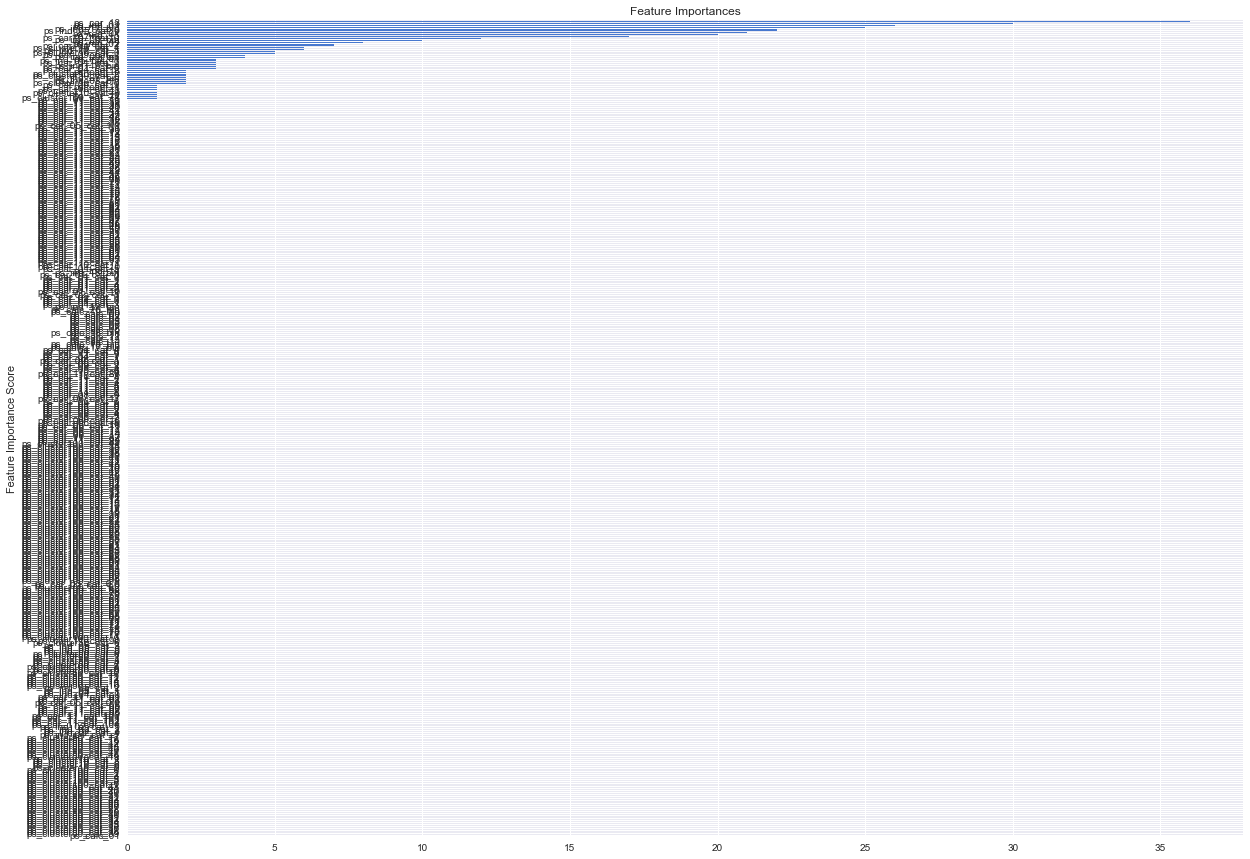

In [12]:
# Baseline LGB model 
gbm0 = lgb.LGBMClassifier(is_unbalance=True, metric='auc')
modelfit(gbm0, X, y)

In [13]:
feat_imp = pd.Series(gbm0.feature_importances_, train_columns).sort_values(ascending=False)

In [14]:
feat_imp2=feat_imp.to_frame()

In [15]:
feat_imp2=feat_imp2.reset_index()
feat_imp2.head(2)

index   0
0  ps_car_13  36
1  ps_ind_03  30

In [16]:
feat_imp2.rename(columns={0 : 'Importance', 'index': 'Feature'}, inplace=True)
feat_imp2.head(3)

Feature  Importance
0  ps_car_13          36
1  ps_ind_03          30
2  ps_reg_03          26

In [44]:
feat_imp2=feat_imp2.loc[feat_imp2['Importance'] > 0]
feat_imp2

Feature  Importance
0              ps_car_13          36
1              ps_ind_03          30
2              ps_reg_03          26
3          ps_ind_17_bin          25
4        ps_ind_05_cat_0          22
5              ps_reg_01          21
6              ps_ind_15          20
7        ps_car_07_cat_0          17
8          ps_ind_06_bin          12
9              ps_car_14          10
10             ps_reg_02           8
11       ps_car_01_cat_7           7
12    ps_cluster10_cat_4           6
13       ps_ind_02_cat_1           6
14    ps_cluster10_cat_0           5
15       ps_car_09_cat_1           5
16         ps_ind_09_bin           4
17             ps_ind_01           4
18      ps_ind_05_cat_-1           3
19       ps_car_01_cat_9           3
20         ps_ind_16_bin           3
21       ps_car_01_cat_6           3
22       ps_car_04_cat_2           3
23             ps_car_15           2
24    ps_cluster10_cat_2           2
25    ps_cluster50_cat_5           2
26         ps_ind_07_bin           2
27         ps_ind_08_bin           2
28    ps_cluster10_cat_7           2
29       ps_car_06_cat_9           2
30             ps_car_11           1
31       ps_car_06_cat_1           1
32      ps_car_11_cat_43           1
33    ps_cluster10_cat_8           1
34             ps_car_12           1
35  ps_cluster100_cat_78           1
36      ps_car_01_cat_11           1

In [45]:
use_cols=feat_imp2.Feature.values

In [46]:
# These are the most important features in the base LightGBM model 
use_cols

array(['ps_car_13', 'ps_ind_03', 'ps_reg_03', 'ps_ind_17_bin',
       'ps_ind_05_cat_0', 'ps_reg_01', 'ps_ind_15', 'ps_car_07_cat_0',
       'ps_ind_06_bin', 'ps_car_14', 'ps_reg_02', 'ps_car_01_cat_7',
       'ps_cluster10_cat_4', 'ps_ind_02_cat_1', 'ps_cluster10_cat_0',
       'ps_car_09_cat_1', 'ps_ind_09_bin', 'ps_ind_01', 'ps_ind_05_cat_-1',
       'ps_car_01_cat_9', 'ps_ind_16_bin', 'ps_car_01_cat_6',
       'ps_car_04_cat_2', 'ps_car_15', 'ps_cluster10_cat_2',
       'ps_cluster50_cat_5', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_cluster10_cat_7', 'ps_car_06_cat_9', 'ps_car_11',
       'ps_car_06_cat_1', 'ps_car_11_cat_43', 'ps_cluster10_cat_8',
       'ps_car_12', 'ps_cluster100_cat_78', 'ps_car_01_cat_11'], dtype=object)

In [7]:
# # Rereading the columns in
# use_cols=['ps_car_13', 'ps_ind_03', 'ps_reg_03', 'ps_ind_17_bin',
#        'ps_ind_05_cat_0', 'ps_reg_01', 'ps_ind_15', 'ps_car_07_cat_0',
#        'ps_ind_06_bin', 'ps_car_14', 'ps_reg_02', 'ps_car_01_cat_7',
#        'ps_cluster10_cat_4', 'ps_ind_02_cat_1', 'ps_cluster10_cat_0',
#        'ps_car_09_cat_1', 'ps_ind_09_bin', 'ps_ind_01', 'ps_ind_05_cat_-1',
#        'ps_car_01_cat_9', 'ps_ind_16_bin', 'ps_car_01_cat_6',
#        'ps_car_04_cat_2', 'ps_car_15', 'ps_cluster10_cat_2',
#        'ps_cluster50_cat_5', 'ps_ind_07_bin', 'ps_ind_08_bin',
#        'ps_cluster10_cat_7', 'ps_car_06_cat_9', 'ps_car_11',
#        'ps_car_06_cat_1', 'ps_car_11_cat_43', 'ps_cluster10_cat_8',
#        'ps_car_12', 'ps_cluster100_cat_78', 'ps_car_01_cat_11']


Model Report
Accuracy : 0.9907
Model's ROC_AUC Score : 0.9999
Model's Gini score : 0.9998
CV AUC Score : Mean - 0.5284 | Std - 0.003646 | Min - 0.5246 | Max - 0.5337
CV Gini score : 0.05683


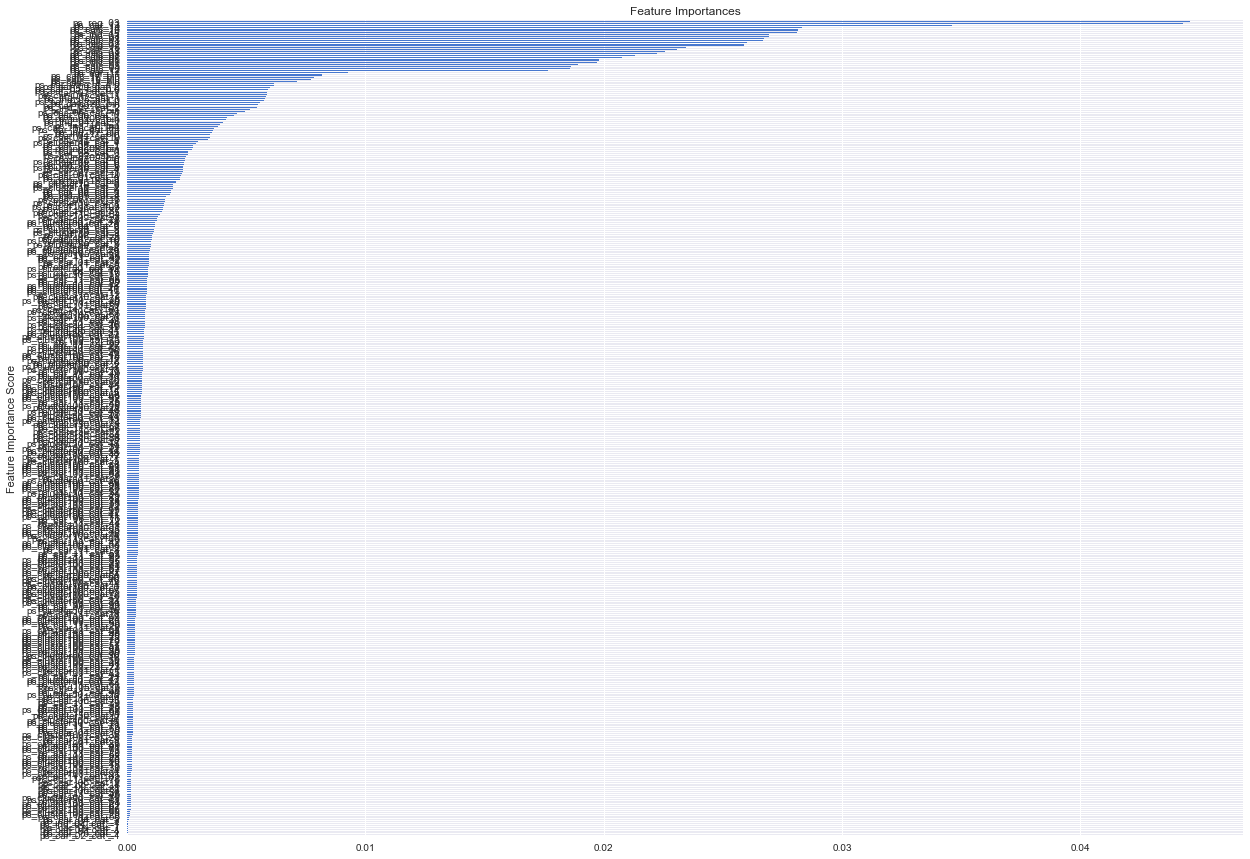

In [19]:
# Basic random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced')
modelfit(rf, X, y)

In [32]:
feat_imp_rf = pd.Series(rf.feature_importances_, train_columns).sort_values(ascending=False)

In [33]:
feat_imp2_rf=feat_imp_rf.to_frame()

In [34]:
feat_imp2_rf=feat_imp2_rf.reset_index().round(4)
feat_imp2_rf

index       0
0               ps_reg_03  0.0446
1               ps_car_13  0.0443
2               ps_car_14  0.0346
3              ps_calc_14  0.0283
4              ps_calc_10  0.0282
5               ps_ind_15  0.0281
6               ps_ind_03  0.0269
7              ps_calc_01  0.0269
8              ps_calc_03  0.0267
9              ps_calc_11  0.0267
10              ps_reg_02  0.0260
11             ps_calc_02  0.0259
12              ps_car_15  0.0234
13             ps_calc_13  0.0231
14              ps_reg_01  0.0226
15             ps_calc_08  0.0222
16             ps_calc_07  0.0213
17             ps_calc_06  0.0208
18              ps_ind_01  0.0198
19             ps_calc_09  0.0197
20             ps_calc_05  0.0189
21             ps_calc_04  0.0186
22             ps_calc_12  0.0186
23              ps_car_12  0.0177
24              ps_car_11  0.0093
25         ps_calc_17_bin  0.0082
26         ps_calc_16_bin  0.0078
27         ps_calc_19_bin  0.0077
28         ps_calc_18_bin  0.0071
29      ps_car_05_cat_1.0  0.0062
..                    ...     ...
351  ps_cluster100_cat_91  0.0002
352      ps_car_11_cat_35  0.0002
353     ps_car_11_cat_102  0.0002
354      ps_car_11_cat_75  0.0002
355       ps_car_06_cat_2  0.0002
356      ps_car_11_cat_18  0.0002
357      ps_car_09_cat_-1  0.0002
358      ps_car_11_cat_81  0.0002
359       ps_car_06_cat_8  0.0002
360      ps_car_11_cat_58  0.0002
361      ps_car_11_cat_45  0.0002
362  ps_cluster100_cat_59  0.0002
363   ps_cluster50_cat_43  0.0002
364      ps_car_11_cat_63  0.0002
365  ps_cluster100_cat_21  0.0002
366  ps_cluster100_cat_62  0.0002
367      ps_car_11_cat_97  0.0001
368  ps_cluster100_cat_66  0.0001
369  ps_cluster100_cat_99  0.0001
370  ps_cluster100_cat_29  0.0001
371      ps_car_11_cat_56  0.0001
372       ps_car_04_cat_5  0.0001
373       ps_car_04_cat_3  0.0001
374      ps_ind_02_cat_-1  0.0001
375      ps_ind_04_cat_-1  0.0000
376       ps_car_04_cat_7  0.0000
377      ps_car_01_cat_-1  0.0000
378       ps_car_04_cat_4  0.0000
379       ps_car_10_cat_2  0.0000
380      ps_car_02_cat_-1  0.0000

[381 rows x 2 columns]

In [35]:
feat_imp2_rf.rename(columns={0 : 'Importance', 'index': 'Feature'}, inplace=True)
feat_imp2_rf.tail()

Feature  Importance
376   ps_car_04_cat_7         0.0
377  ps_car_01_cat_-1         0.0
378   ps_car_04_cat_4         0.0
379   ps_car_10_cat_2         0.0
380  ps_car_02_cat_-1         0.0

In [36]:
feat_imp2_rf=feat_imp2_rf.loc[feat_imp2_rf['Importance'] > 0.0049]
feat_imp2_rf

Feature  Importance
0           ps_reg_03      0.0446
1           ps_car_13      0.0443
2           ps_car_14      0.0346
3          ps_calc_14      0.0283
4          ps_calc_10      0.0282
5           ps_ind_15      0.0281
6           ps_ind_03      0.0269
7          ps_calc_01      0.0269
8          ps_calc_03      0.0267
9          ps_calc_11      0.0267
10          ps_reg_02      0.0260
11         ps_calc_02      0.0259
12          ps_car_15      0.0234
13         ps_calc_13      0.0231
14          ps_reg_01      0.0226
15         ps_calc_08      0.0222
16         ps_calc_07      0.0213
17         ps_calc_06      0.0208
18          ps_ind_01      0.0198
19         ps_calc_09      0.0197
20         ps_calc_05      0.0189
21         ps_calc_04      0.0186
22         ps_calc_12      0.0186
23          ps_car_12      0.0177
24          ps_car_11      0.0093
25     ps_calc_17_bin      0.0082
26     ps_calc_16_bin      0.0078
27     ps_calc_19_bin      0.0077
28     ps_calc_18_bin      0.0071
29  ps_car_05_cat_1.0      0.0062
30    ps_car_09_cat_2      0.0061
31  ps_car_05_cat_0.0      0.0060
32  ps_car_03_cat_0.0      0.0059
33    ps_car_01_cat_7      0.0059
34   ps_car_01_cat_11      0.0059
35    ps_ind_02_cat_1      0.0058
36    ps_ind_05_cat_0      0.0058
37  ps_car_03_cat_1.0      0.0057
38     ps_calc_20_bin      0.0056
39    ps_car_09_cat_0      0.0055
40    ps_ind_02_cat_2      0.0055
41     ps_calc_15_bin      0.0052
42   ps_car_06_cat_11      0.0050

In [42]:
# Most important features using base RF 
use_cols2=feat_imp2_rf.Feature.values
use_cols2

array(['ps_reg_03', 'ps_car_13', 'ps_car_14', 'ps_calc_14', 'ps_calc_10',
       'ps_ind_15', 'ps_ind_03', 'ps_calc_01', 'ps_calc_03', 'ps_calc_11',
       'ps_reg_02', 'ps_calc_02', 'ps_car_15', 'ps_calc_13', 'ps_reg_01',
       'ps_calc_08', 'ps_calc_07', 'ps_calc_06', 'ps_ind_01', 'ps_calc_09',
       'ps_calc_05', 'ps_calc_04', 'ps_calc_12', 'ps_car_12', 'ps_car_11',
       'ps_calc_17_bin', 'ps_calc_16_bin', 'ps_calc_19_bin',
       'ps_calc_18_bin', 'ps_car_05_cat_1.0', 'ps_car_09_cat_2',
       'ps_car_05_cat_0.0', 'ps_car_03_cat_0.0', 'ps_car_01_cat_7',
       'ps_car_01_cat_11', 'ps_ind_02_cat_1', 'ps_ind_05_cat_0',
       'ps_car_03_cat_1.0', 'ps_calc_20_bin', 'ps_car_09_cat_0',
       'ps_ind_02_cat_2', 'ps_calc_15_bin', 'ps_car_06_cat_11'], dtype=object)

In [8]:
# # Re-reading the columns in 
# use_cols2=['ps_reg_03', 'ps_car_13', 'ps_car_14', 'ps_calc_14', 'ps_calc_10',
#        'ps_ind_15', 'ps_ind_03', 'ps_calc_01', 'ps_calc_03', 'ps_calc_11',
#        'ps_reg_02', 'ps_calc_02', 'ps_car_15', 'ps_calc_13', 'ps_reg_01',
#        'ps_calc_08', 'ps_calc_07', 'ps_calc_06', 'ps_ind_01', 'ps_calc_09',
#        'ps_calc_05', 'ps_calc_04', 'ps_calc_12', 'ps_car_12', 'ps_car_11',
#        'ps_calc_17_bin', 'ps_calc_16_bin', 'ps_calc_19_bin',
#        'ps_calc_18_bin', 'ps_car_05_cat_1.0', 'ps_car_09_cat_2',
#        'ps_car_05_cat_0.0', 'ps_car_03_cat_0.0', 'ps_car_01_cat_7',
#        'ps_car_01_cat_11', 'ps_ind_02_cat_1', 'ps_ind_05_cat_0',
#        'ps_car_03_cat_1.0', 'ps_calc_20_bin', 'ps_car_09_cat_0',
#        'ps_ind_02_cat_2', 'ps_calc_15_bin', 'ps_car_06_cat_11']

In [9]:
uc1=set(use_cols)
uc2=set(use_cols2)
uc1.difference(uc2)

{'ps_car_01_cat_6',
 'ps_car_01_cat_9',
 'ps_car_04_cat_2',
 'ps_car_06_cat_1',
 'ps_car_06_cat_9',
 'ps_car_07_cat_0',
 'ps_car_09_cat_1',
 'ps_car_11_cat_43',
 'ps_cluster100_cat_78',
 'ps_cluster10_cat_0',
 'ps_cluster10_cat_2',
 'ps_cluster10_cat_4',
 'ps_cluster10_cat_7',
 'ps_cluster10_cat_8',
 'ps_cluster50_cat_5',
 'ps_ind_05_cat_-1',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_16_bin',
 'ps_ind_17_bin'}

In [49]:
list(set(use_cols2)-set(use_cols))

['ps_car_05_cat_1.0',
 'ps_calc_03',
 'ps_calc_07',
 'ps_calc_14',
 'ps_calc_18_bin',
 'ps_ind_02_cat_2',
 'ps_calc_02',
 'ps_car_05_cat_0.0',
 'ps_calc_15_bin',
 'ps_calc_19_bin',
 'ps_calc_12',
 'ps_calc_17_bin',
 'ps_car_09_cat_0',
 'ps_calc_13',
 'ps_calc_01',
 'ps_car_03_cat_1.0',
 'ps_calc_20_bin',
 'ps_calc_04',
 'ps_calc_05',
 'ps_calc_06',
 'ps_calc_11',
 'ps_calc_08',
 'ps_calc_09',
 'ps_calc_10',
 'ps_car_09_cat_2',
 'ps_car_06_cat_11',
 'ps_calc_16_bin',
 'ps_car_03_cat_0.0']

In [27]:
# Join the most important features from the two base models 
use_cols3=list(set.union(uc1, uc2))

In [3]:
# use_cols3=['ps_car_11_cat_43', 'ps_ind_05_cat_-1', 'ps_calc_13', 'ps_cluster50_cat_5', 'ps_calc_17_bin', 'ps_car_12', 'ps_calc_12', 'ps_car_09_cat_2', 'ps_car_06_cat_11', 'ps_car_15', 'ps_ind_15', 'ps_calc_02', 'ps_calc_06', 'ps_car_01_cat_11', 'ps_cluster10_cat_7', 'ps_cluster10_cat_8', 'ps_car_09_cat_1', 'ps_ind_08_bin', 'ps_ind_16_bin', 'ps_car_14', 'ps_car_01_cat_6', 'ps_ind_17_bin', 'ps_reg_01', 'ps_calc_16_bin', 'ps_calc_11', 'ps_calc_08', 'ps_car_09_cat_0', 'ps_car_03_cat_0.0', 'ps_car_06_cat_9', 'ps_ind_02_cat_2', 'ps_ind_05_cat_0', 'ps_car_11', 'ps_ind_09_bin', 'ps_calc_01', 'ps_calc_20_bin', 'ps_car_03_cat_1.0', 'ps_ind_03', 'ps_car_13', 'ps_calc_09', 'ps_cluster10_cat_2', 'ps_reg_02', 'ps_car_05_cat_1.0', 'ps_calc_19_bin', 'ps_car_05_cat_0.0', 'ps_cluster10_cat_4', 'ps_calc_04', 'ps_calc_10', 'ps_calc_18_bin', 'ps_cluster10_cat_0', 'ps_ind_07_bin', 'ps_car_01_cat_9', 'ps_ind_02_cat_1', 'ps_calc_15_bin', 'ps_cluster100_cat_78', 'ps_car_06_cat_1', 'ps_calc_07', 'ps_calc_03', 'ps_calc_05', 'ps_reg_03', 'ps_ind_06_bin', 'ps_car_01_cat_7', 'ps_car_07_cat_0', 'ps_calc_14', 'ps_car_04_cat_2', 'ps_ind_01']

In [13]:
len(use_cols3)

65

Modeling -- Using Reduced Feature Set 

In [65]:
X = df_train[use_cols3]
y = df_train['target']
train_columns=df_train[use_cols3].columns
print(X.shape, y.shape)

(595212, 65) (595212,)



Model Report
Accuracy : 0.6091
Model's ROC_AUC Score : 0.6397
Model's Gini score : 0.2795
CV AUC Score : Mean - 0.6278 | Std - 0.001854 | Min - 0.6243 | Max - 0.6295
CV Gini score : 0.2557


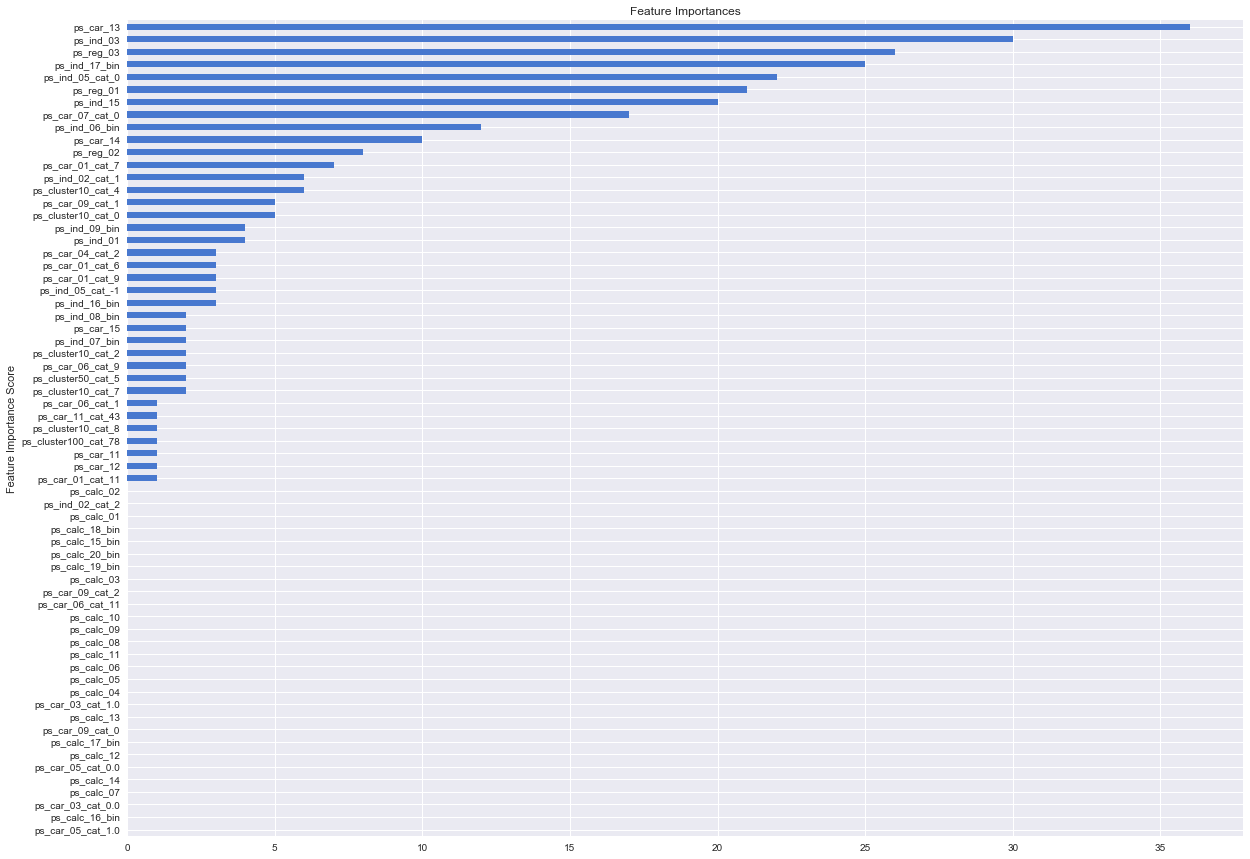

In [66]:
# Baseline LGB model -- with reduced feature set 
gbm00 = lgb.LGBMClassifier(is_unbalance=True, metric='auc')
modelfit(gbm00, X, y)

In [67]:
gc.collect()

47880

Tuning the LightGBM Model 

In [68]:
param_test1 = {'n_estimators':range(20,80, 10)}
gsearch1 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,metric='auc', is_unbalance=True, 
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=0, subsample=1, subsample_for_bin=50000,
        subsample_freq=1), param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, is_unbalance=True,
        learning_rate=0.1, max_bin=255, max_depth=-1, metric='auc',
        min_child_samples=10, min_child_weight=5, min_split_gain=0,
        n_estimators=10, nthread=-1, num_leaves=31, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=0, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(20, 80, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [69]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63407, std: 0.00249, params: {'n_estimators': 20},
  mean: 0.63648, std: 0.00287, params: {'n_estimators': 30},
  mean: 0.63745, std: 0.00304, params: {'n_estimators': 40},
  mean: 0.63725, std: 0.00335, params: {'n_estimators': 50},
  mean: 0.63720, std: 0.00327, params: {'n_estimators': 60},
  mean: 0.63700, std: 0.00318, params: {'n_estimators': 70}],
 {'n_estimators': 40},
 0.63744812720980737)

In [70]:
gsearch1.best_estimator_

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, is_unbalance=True,
        learning_rate=0.1, max_bin=255, max_depth=-1, metric='auc',
        min_child_samples=10, min_child_weight=5, min_split_gain=0,
        n_estimators=40, nthread=-1, num_leaves=31, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=0, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1)

In [71]:
modelfit(gsearch1.best_estimator_, X, y)


Model Report
Accuracy : 0.6221
Model's ROC_AUC Score : 0.6632
Model's Gini score : 0.3264
CV AUC Score : Mean - 0.6374 | Std - 0.003042 | Min - 0.632 | Max - 0.6412
CV Gini score : 0.2749


In [27]:
gc.collect()

14352

In [72]:
param_test2 = {'max_depth':range(5,9,2)}
gsearch2 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, is_unbalance=True,
        learning_rate=0.1, max_bin=255, max_depth=-1, metric='auc',
        min_child_samples=10, min_child_weight=5, min_split_gain=0,
        n_estimators=40, nthread=-1, num_leaves=31, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=0, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1), param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X,y)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63465, std: 0.00304, params: {'max_depth': 5},
  mean: 0.63723, std: 0.00347, params: {'max_depth': 7}],
 {'max_depth': 7},
 0.63722682066694847)

In [73]:
modelfit(gsearch2.best_estimator_, X, y)


Model Report
Accuracy : 0.6249
Model's ROC_AUC Score : 0.6619
Model's Gini score : 0.3237
CV AUC Score : Mean - 0.6372 | Std - 0.003473 | Min - 0.6311 | Max - 0.6415
CV Gini score : 0.2745


In [74]:
gsearch2.best_estimator_

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, is_unbalance=True,
        learning_rate=0.1, max_bin=255, max_depth=7, metric='auc',
        min_child_samples=10, min_child_weight=5, min_split_gain=0,
        n_estimators=40, nthread=-1, num_leaves=31, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=0, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1)

In [75]:
gc.collect()

22744

In [76]:
param_test2A = {'subsample' : [0.7, 0.8], 'colsample_bytree' : [0.9, 1.0]}
gsearch2A = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, is_unbalance=True,
        learning_rate=0.1, max_bin=255, max_depth=7, metric='auc',
        min_child_samples=10, min_child_weight=5, min_split_gain=0,
        n_estimators=40, nthread=-1, num_leaves=31, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=0, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1), param_grid = param_test2A, scoring='roc_auc',
        n_jobs=4,iid=False, cv=5, verbose=1)
gsearch2A.fit(X,y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  3.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, is_unbalance=True,
        learning_rate=0.1, max_bin=255, max_depth=7, metric='auc',
        min_child_samples=10, min_child_weight=5, min_split_gain=0,
        n_estimators=40, nthread=-1, num_leaves=31, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=0, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.7, 0.8], 'colsample_bytree': [0.9, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [77]:
gsearch2A.grid_scores_, gsearch2A.best_params_, gsearch2A.best_score_

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63674, std: 0.00258, params: {'colsample_bytree': 0.9, 'subsample': 0.7},
  mean: 0.63682, std: 0.00258, params: {'colsample_bytree': 0.9, 'subsample': 0.8},
  mean: 0.63582, std: 0.00282, params: {'colsample_bytree': 1.0, 'subsample': 0.7},
  mean: 0.63653, std: 0.00266, params: {'colsample_bytree': 1.0, 'subsample': 0.8}],
 {'colsample_bytree': 0.9, 'subsample': 0.8},
 0.6368170216759268)


Model Report
Accuracy : 0.627
Model's ROC_AUC Score : 0.6615
Model's Gini score : 0.323
CV AUC Score : Mean - 0.6368 | Std - 0.002578 | Min - 0.632 | Max - 0.6393
CV Gini score : 0.2736


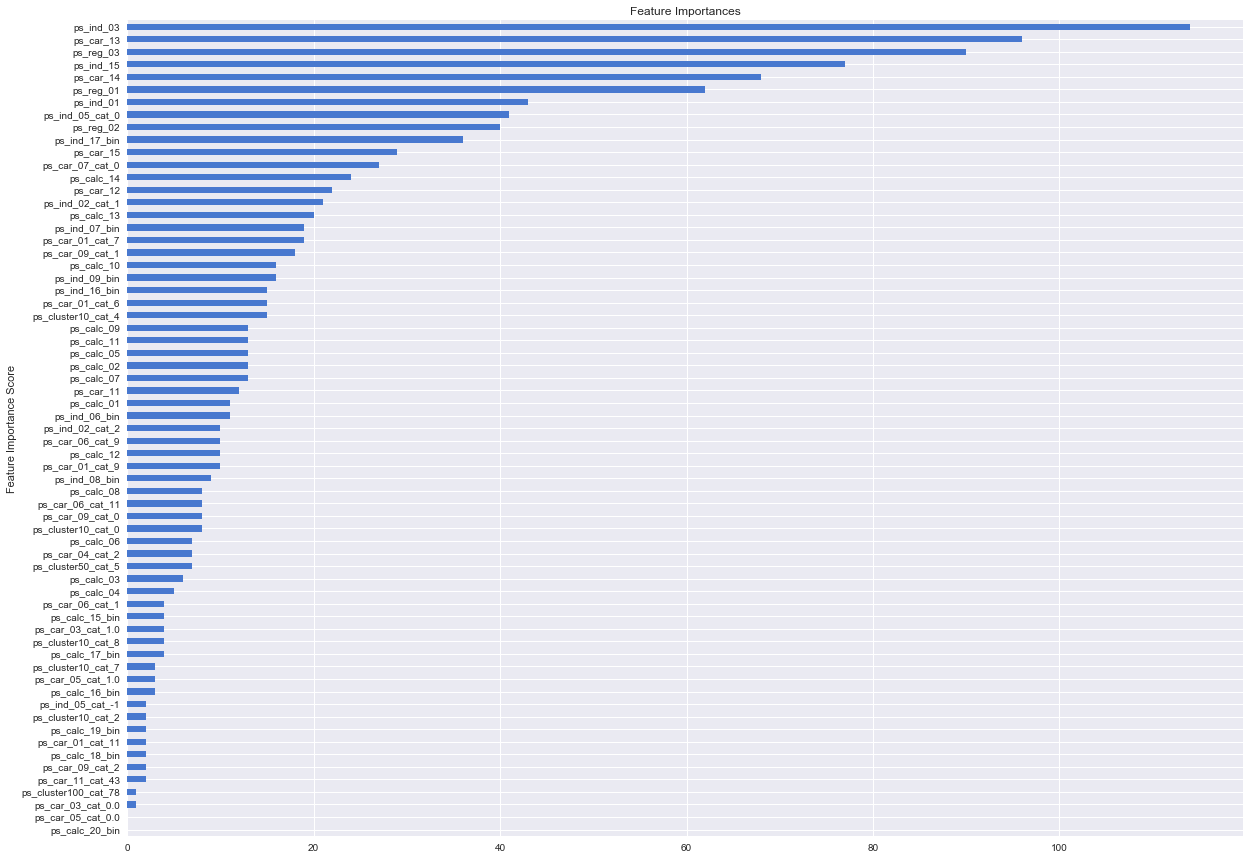

In [78]:
modelfit(gsearch2A.best_estimator_, X, y)

In [79]:
gsearch2A.best_estimator_

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.9, is_unbalance=True,
        learning_rate=0.1, max_bin=255, max_depth=7, metric='auc',
        min_child_samples=10, min_child_weight=5, min_split_gain=0,
        n_estimators=40, nthread=-1, num_leaves=31, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=0, silent=True, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1)

In [80]:
gc.collect()

22681

In [81]:
param_test3 = {'num_leaves': [20, 25, 30, 35]} 
gsearch3 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.9, is_unbalance=True,
        learning_rate=0.1, max_bin=255, max_depth=7, metric='auc',
        min_child_samples=10, min_child_weight=5, min_split_gain=0,
        n_estimators=40, nthread=-1, num_leaves=31, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=0, silent=True, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1), param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5, verbose=1)
gsearch3.fit(X,y)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  7.1min finished
c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63654, std: 0.00269, params: {'num_leaves': 20},
  mean: 0.63695, std: 0.00246, params: {'num_leaves': 25},
  mean: 0.63634, std: 0.00238, params: {'num_leaves': 30},
  mean: 0.63600, std: 0.00268, params: {'num_leaves': 35}],
 {'num_leaves': 25},
 0.63694928707500331)


Model Report
Accuracy : 0.6254
Model's ROC_AUC Score : 0.6565
Model's Gini score : 0.313
CV AUC Score : Mean - 0.6369 | Std - 0.002458 | Min - 0.6327 | Max - 0.6402
CV Gini score : 0.2739


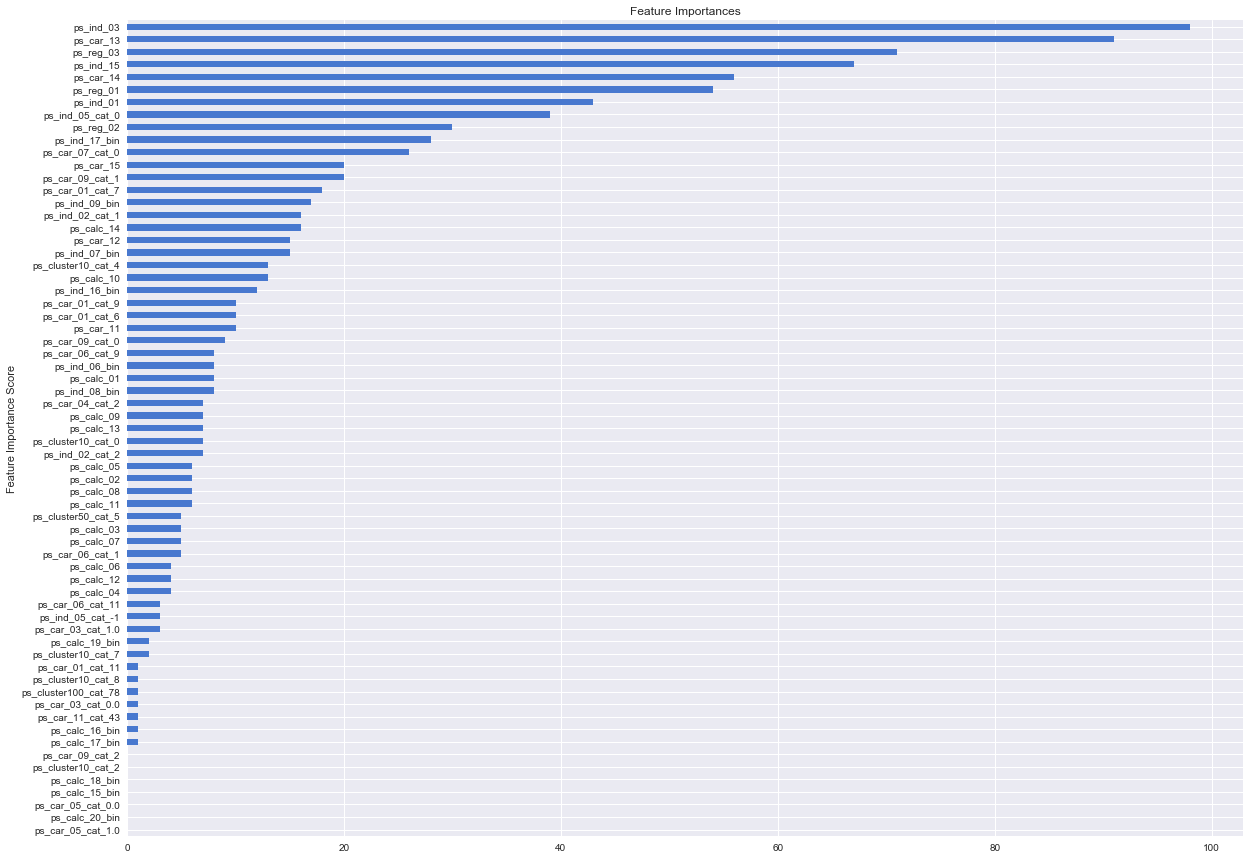

In [82]:
modelfit(gsearch3.best_estimator_, X, y)

In [83]:
gsearch3.best_estimator_

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.9, is_unbalance=True,
        learning_rate=0.1, max_bin=255, max_depth=7, metric='auc',
        min_child_samples=10, min_child_weight=5, min_split_gain=0,
        n_estimators=40, nthread=-1, num_leaves=25, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=0, silent=True, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1)

In [84]:
gc.collect()

22881

In [85]:
param_test4 =  {'min_data_in_leaf': range(9, 10, 11)}
gsearch4 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.9, is_unbalance=True,
        learning_rate=0.1, max_bin=255, max_depth=7, metric='auc',
        min_child_samples=10, min_child_weight=5, min_split_gain=0,
        n_estimators=40, nthread=-1, num_leaves=25, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=0, silent=True, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1),
        param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)                
gsearch4.fit(X,y)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63695, std: 0.00246, params: {'min_data_in_leaf': 9}],
 {'min_data_in_leaf': 9},
 0.63694928707500331)


Model Report
Accuracy : 0.6254
Model's ROC_AUC Score : 0.6565
Model's Gini score : 0.313
CV AUC Score : Mean - 0.6369 | Std - 0.002458 | Min - 0.6327 | Max - 0.6402
CV Gini score : 0.2739


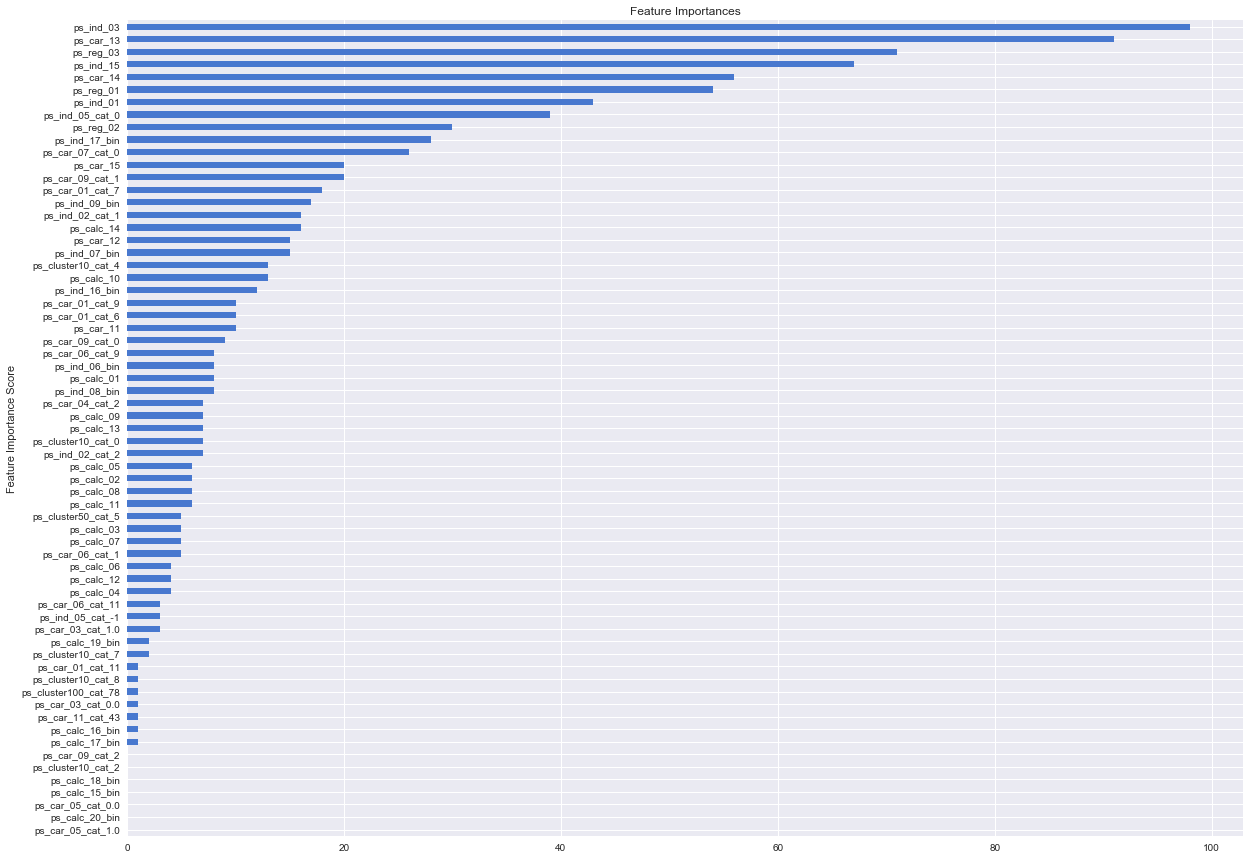

In [86]:
modelfit(gsearch4.best_estimator_, X, y)

In [87]:
gsearch4.best_estimator_

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.9, is_unbalance=True,
        learning_rate=0.1, max_bin=255, max_depth=7, metric='auc',
        min_child_samples=10, min_child_weight=5, min_data_in_leaf=9,
        min_split_gain=0, n_estimators=40, nthread=-1, num_leaves=25,
        objective='binary', reg_alpha=0, reg_lambda=0, seed=0, silent=True,
        subsample=0.8, subsample_for_bin=50000, subsample_freq=1)

In [88]:
gc.collect()

22881

In [91]:
param_test5 = {'subsample' : [0.8, 0.9, 0.95, 1.0]}
gsearch5 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.9, is_unbalance=True,
        learning_rate=0.1, max_bin=255, max_depth=7, metric='auc',
        min_child_samples=10, min_child_weight=5, min_data_in_leaf=9,
        min_split_gain=0, n_estimators=40, nthread=-1, num_leaves=25,
        objective='binary', reg_alpha=0, reg_lambda=0, seed=0, silent=True,
        subsample=0.8, subsample_for_bin=50000, subsample_freq=1), 
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X,y)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63695, std: 0.00246, params: {'subsample': 0.8},
  mean: 0.63701, std: 0.00265, params: {'subsample': 0.9},
  mean: 0.63680, std: 0.00294, params: {'subsample': 0.95},
  mean: 0.63752, std: 0.00229, params: {'subsample': 1.0}],
 {'subsample': 1.0},
 0.63751951338705837)


Model Report
Accuracy : 0.6203
Model's ROC_AUC Score : 0.6569
Model's Gini score : 0.3138
CV AUC Score : Mean - 0.6375 | Std - 0.002292 | Min - 0.6335 | Max - 0.64
CV Gini score : 0.275


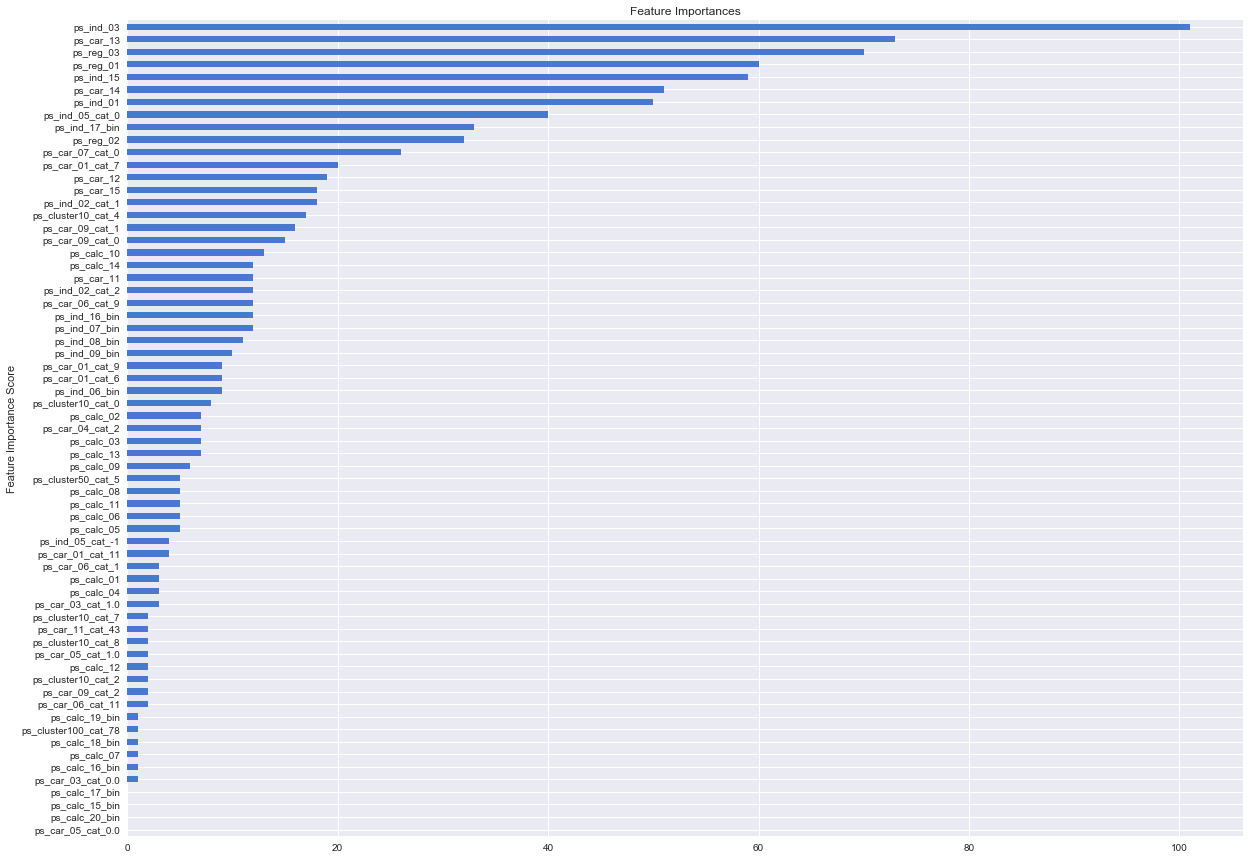

In [92]:
modelfit(gsearch5.best_estimator_, X, y)

In [93]:
gsearch5.best_estimator_

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.9, is_unbalance=True,
        learning_rate=0.1, max_bin=255, max_depth=7, metric='auc',
        min_child_samples=10, min_child_weight=5, min_data_in_leaf=9,
        min_split_gain=0, n_estimators=40, nthread=-1, num_leaves=25,
        objective='binary', reg_alpha=0, reg_lambda=0, seed=0, silent=True,
        subsample=1.0, subsample_for_bin=50000, subsample_freq=1)

In [94]:
gc.collect()

22881

In [ ]:
param_test6 = {'max_bin' : [200, 250, 300]}
gsearch6 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.9, is_unbalance=True,
        learning_rate=0.1, max_bin=255, max_depth=7, metric='auc',
        min_child_samples=10, min_child_weight=5, min_data_in_leaf=9,
        min_split_gain=0, n_estimators=40, nthread=-1, num_leaves=25,
        objective='binary', reg_alpha=0, reg_lambda=0, seed=0, silent=True,
        subsample=1.0, subsample_for_bin=50000, subsample_freq=1), 
param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X,y)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
modelfit(gsearch6.best_estimator_, X, y)

In [ ]:
gsearch6.best_estimator_

In [ ]:
gc.collect()

In [65]:
param_test7 = {'learning_rate' : [0.01, 0.02], 'n_estimators' : [800, 900, 1000]}
gsearch7 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, is_unbalance=True,
        learning_rate=0.1, max_bin=200, max_depth=9, metric='auc',
        min_child_samples=10, min_child_weight=5, min_data_in_leaf=6,
        min_split_gain=0, n_estimators=40, nthread=-1, num_leaves=12,
        objective='binary', reg_alpha=0, reg_lambda=0, seed=0, silent=True,
        subsample=1.0, subsample_for_bin=50000, subsample_freq=1), 
param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(X,y)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

C:\Users\Robert McKee\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63564, std: 0.00274, params: {'learning_rate': 0.005, 'n_estimators': 800},
  mean: 0.63034, std: 0.00234, params: {'learning_rate': 0.005, 'n_estimators': 400},
  mean: 0.61355, std: 0.00228, params: {'learning_rate': 0.005, 'n_estimators': 80},
  mean: 0.63808, std: 0.00301, params: {'learning_rate': 0.01, 'n_estimators': 800},
  mean: 0.63563, std: 0.00276, params: {'learning_rate': 0.01, 'n_estimators': 400},
  mean: 0.62024, std: 0.00220, params: {'learning_rate': 0.01, 'n_estimators': 80},
  mean: 0.62681, std: 0.00518, params: {'learning_rate': 0.1, 'n_estimators': 800},
  mean: 0.63361, std: 0.00494, params: {'learning_rate': 0.1, 'n_estimators': 400},
  mean: 0.63738, std: 0.00304, params: {'learning_rate': 0.1, 'n_estimators': 80}],
 {'learning_rate': 0.01, 'n_estimators': 800},
 0.63808292254650278)

In [66]:
gc.collect()

102


Model Report
Accuracy : 0.623
Model's ROC_AUC Score : 0.6535
Model's Gini score : 0.307
CV AUC Score : Mean - 0.6381 | Std - 0.003012 | Min - 0.6323 | Max - 0.6408
CV Gini score : 0.2762


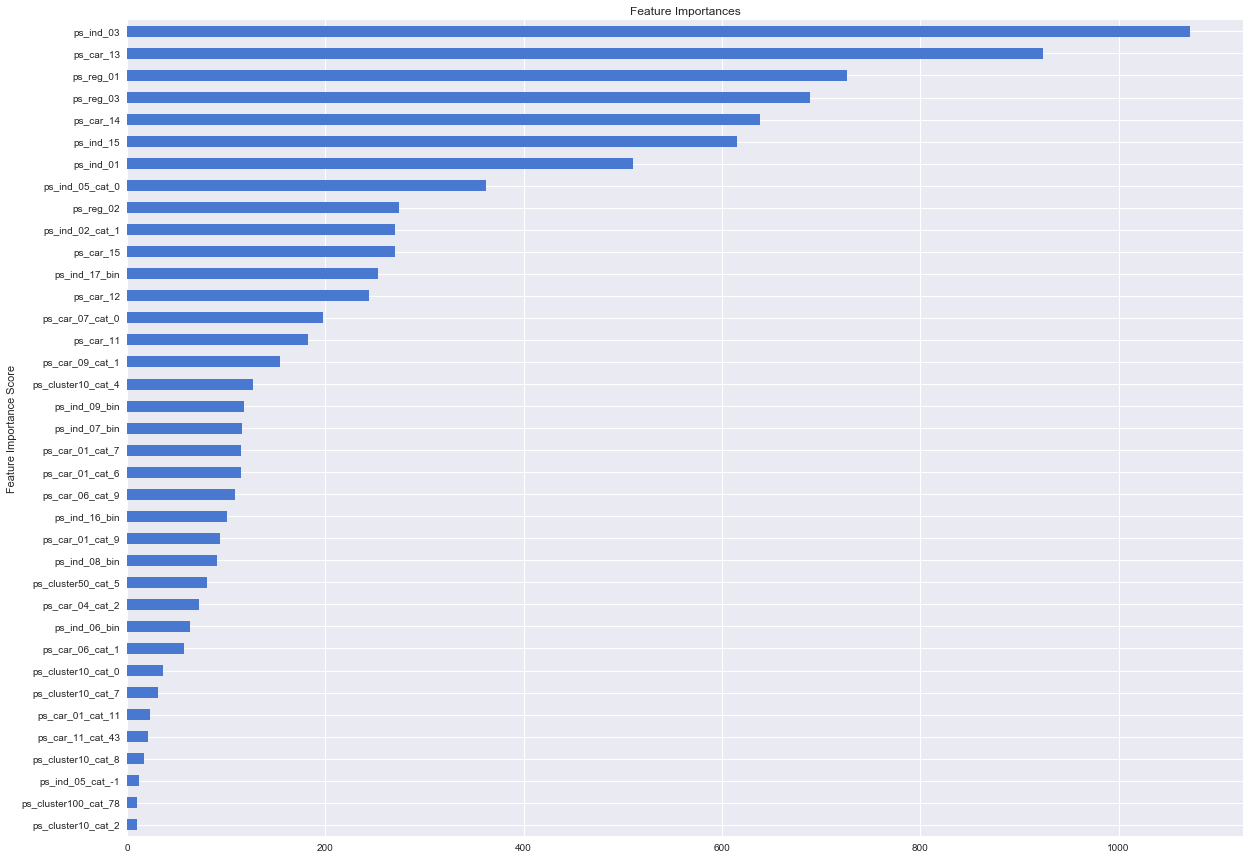

In [67]:
modelfit(gsearch7.best_estimator_, X, y)

In [68]:
gsearch7.best_estimator_

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, is_unbalance=True,
        learning_rate=0.01, max_bin=200, max_depth=9, metric='auc',
        min_child_samples=10, min_child_weight=5, min_data_in_leaf=6,
        min_split_gain=0, n_estimators=800, nthread=-1, num_leaves=12,
        objective='binary', reg_alpha=0, reg_lambda=0, seed=0, silent=True,
        subsample=1.0, subsample_for_bin=50000, subsample_freq=1)

In [111]:
gc.collect()

28291


Model Report
Accuracy : 0.6352
Model's ROC_AUC Score : 0.6771
Model's Gini score : 0.3542
CV AUC Score : Mean - 0.6397 | Std - 0.003433 | Min - 0.6335 | Max - 0.6438
CV Gini score : 0.2795


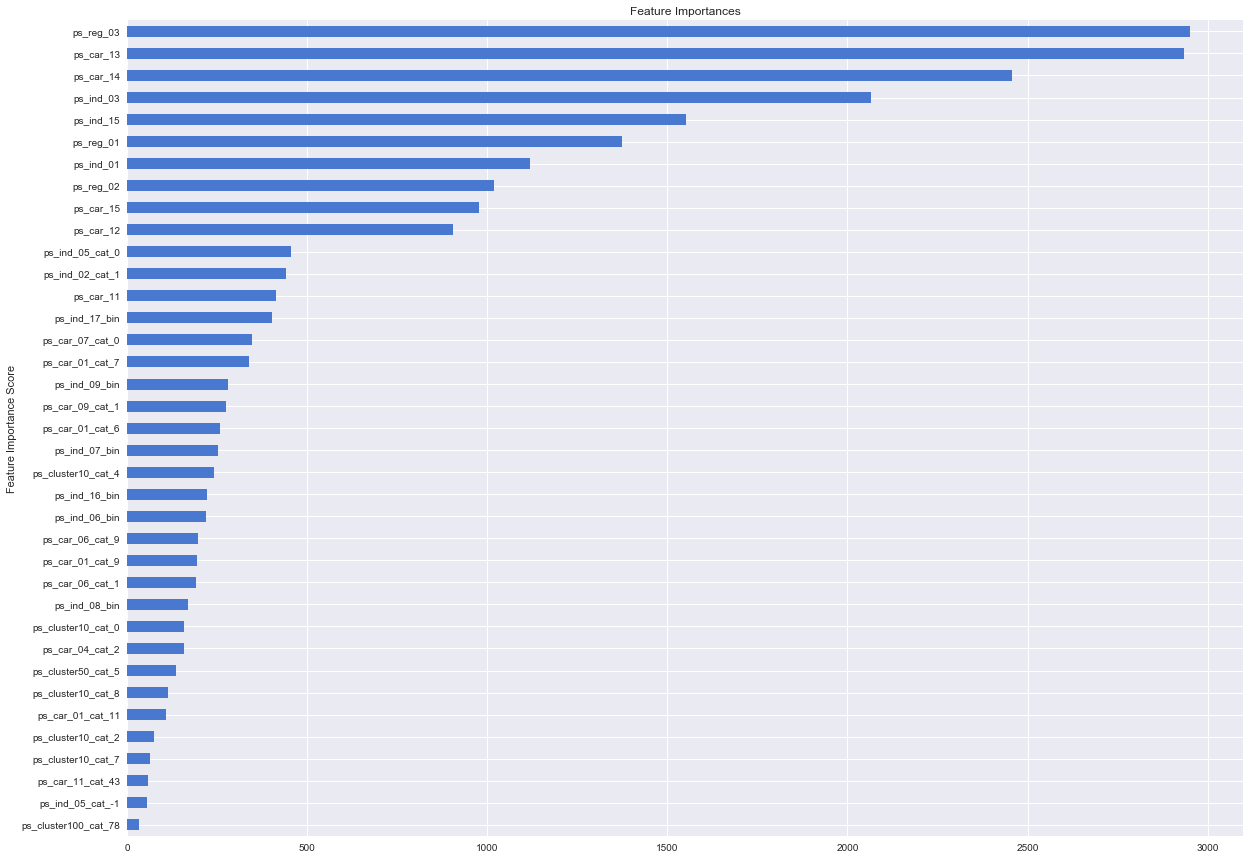

In [112]:
# Manual tuning 
gbm0 = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=.8, subsample=0.8, is_unbalance=True,
        learning_rate=0.01, max_bin=500, max_depth=9, metric='auc',
        min_child_samples=10, min_child_weight=5, min_data_in_leaf=12,
        min_split_gain=0, n_estimators=800, nthread=-1, num_leaves=30,
        objective='binary', reg_alpha=0.2, reg_lambda=3, seed=32, silent=True,
        subsample_for_bin=50000, subsample_freq=1)
modelfit(gbm0, X, y)

 From Kaggle: Your submission scored 0.278

** Test Dataset -- Prediction and Submission **

In [ ]:
X_sub = df_test[use_cols5]
print(X_sub.shape)

In [97]:
print('Start predicting...')
y_pred_sub =gbm0.predict_proba(X_sub)[:,1]

Start predicting...


In [98]:
y_pred_sub

array([ 0.40411256,  0.408107  ,  0.41428234, ...,  0.52091956,
        0.34886903,  0.40543718])

In [99]:
len(y_pred_sub)

892816

In [100]:
submission= df_test

In [101]:
submission.shape

(892816, 383)

In [102]:
submission['target']=y_pred_sub

In [103]:
submission=submission[['id', 'target']]

In [104]:
submission.shape

(892816, 2)

In [105]:
submission.head()

id    target
595212   0  0.404113
595213   1  0.408107
595214   2  0.414282
595215   3  0.276687
595216   4  0.518575

In [106]:
submission.tail()

id    target
1488023  1488022  0.709316
1488024  1488023  0.498605
1488025  1488024  0.520920
1488026  1488025  0.348869
1488027  1488026  0.405437

In [107]:
submission.target.max()

0.88132112066163193

In [108]:
submission.target.min()

0.1116668062777858

In [109]:
submission.to_csv('lgb_v29.csv', index=False, float_format='%.4f')

In [ ]:
# Validate (as needed)
s=pd.read_csv('lgb_v5.csv')

In [ ]:
s.head()

In [ ]:
s.sort_values('target', ascending=False)

** Experimentation With Stacking **

After experimenting with different models, we will use light gbm as our master predictive model.  But we also want to test 
the impact of different stacking techniques.  This first round of modeling is to train various base models on the data.  We will then use the predictions generated by the base models as features in the final lightgbm. Another option is to use a "voting" system at the end to combine the scores from the different models.  

Here, we split the train dataset into A and B datasets, and rename the test dataset C.  (1) We train the base models on A. (2) We then uses those trained models to append predictions to B1 and C1. (3) We then train a meta model on B.  (4) Then predict C1 (the test data) using the trained meta model.  


In [30]:
# Making the datasets for manageable for re-use 
new_cols=use_cols3 + ['id', 'target']
df_train=df_train[new_cols]
df_test=df_test[new_cols]

In [33]:
df_train.shape

(595212, 67)

In [32]:
df_A=df_train.sample(frac=0.5, axis=0)
df_A.shape

(297606, 67)

In [34]:
df_B=df_train[~df_train.index.isin(df_A.index)]

In [35]:
df_B.shape

(297606, 67)

In [36]:
df_C=df_test

In [37]:
df_C.shape

(892816, 67)

In [4]:
# df_A.to_pickle('df_A.pickle')
# df_B.to_pickle('df_B.pickle')
# df_C.to_pickle('df_C.pickle')
df_A=pd.read_pickle('df_A.pickle')
df_B=pd.read_pickle('df_B.pickle')
df_C=pd.read_pickle('df_C.pickle')

In [39]:
del df_test, df_train; gc.collect()

44

Train the models on the A dataset, then make and append predictions to B and C datasets

In [4]:
X = df_A[use_cols3]
y = df_A['target']
train_columns=df_A[use_cols3].columns
print(X.shape, y.shape)

(297606, 65) (297606,)


In [5]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_b = df_B[use_cols3]
X_c = df_C[use_cols3]
print(X_b.shape)
print(X_c.shape)

(297606, 65)
(892816, 65)


In [47]:
# Logistic Regression 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score

lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
pred_lr =lr.predict(X_test)
print (metrics.accuracy_score(y_test, pred_lr))
print(metrics.classification_report(y_test, pred_lr))
pred_proba_lr = lr.predict_proba(X_test)[:,1]
print ("Model's ROC_AUC Score : %.4g" % metrics.roc_auc_score(y_test, pred_proba_lr))
print ("Model's Gini score : %.4g" % gini(y_test, pred_proba_lr))

0.620493262995
             precision    recall  f1-score   support

          0       0.97      0.62      0.76     57328
          1       0.05      0.56      0.10      2194

avg / total       0.94      0.62      0.74     59522

Model's ROC_AUC Score : 0.6264
Model's Gini score : 0.2528


In [49]:
print('Start predicting...')
y_pred_b =lr.predict_proba(X_b)[:,1]
y_pred_c =lr.predict_proba(X_c)[:,1]
df_B['lr_predict_probs']=y_pred_b
df_C['lr_predict_probs']=y_pred_c

Start predicting...


In [57]:
# Random Forests 
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=20, n_jobs=-1, class_weight='balanced', min_samples_leaf=25, min_samples_split=25)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
print (metrics.accuracy_score(y_test, pred_rf))
print(metrics.classification_report(y_test, pred_rf))
pred_proba_rf = rf.predict_proba(X_test)[:,1]
print ("Model's ROC_AUC Score : %.4g" % metrics.roc_auc_score(y_test, pred_proba_rf))
print ("Model's Gini score : %.4g" % gini(y_test, pred_proba_rf))

0.942071838984
             precision    recall  f1-score   support

          0       0.96      0.98      0.97     57328
          1       0.09      0.07      0.08      2194

avg / total       0.93      0.94      0.94     59522

Model's ROC_AUC Score : 0.6036
Model's Gini score : 0.2073


In [63]:
print('Start predicting...')
y_pred_b =rf.predict_proba(X_b)[:,1]
y_pred_c =rf.predict_proba(X_c)[:,1]
df_B['rf_predict_probs']=y_pred_b
df_C['rf_predict_probs']=y_pred_c

Start predicting...


In [78]:
from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB()
nb.fit(X_train, y_train)
pred_nb = nb.predict(X_test)
print (metrics.accuracy_score(y_test, pred_nb))
print(metrics.classification_report(y_test, pred_nb))
pred_proba_nb = nb.predict_proba(X_test)[:,1]
print ("Model's ROC_AUC Score : %.4g" % metrics.roc_auc_score(y_test, pred_proba_nb))
print ("Model's Gini score : %.4g" % gini(y_test, pred_proba_nb))

0.961140418669
             precision    recall  f1-score   support

          0       0.96      1.00      0.98     57328
          1       0.15      0.01      0.02      2194

avg / total       0.93      0.96      0.94     59522

Model's ROC_AUC Score : 0.6027
Model's Gini score : 0.2055


In [79]:
print('Start predicting...')
y_pred_b =nb.predict_proba(X_b)[:,1]
y_pred_c =nb.predict_proba(X_c)[:,1]
df_B['nb_predict_probs']=y_pred_b
df_C['nb_predict_probs']=y_pred_c

Start predicting...


In [81]:
import lightgbm as lgb
gbm = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=.8, subsample=0.8, is_unbalance=True,
        learning_rate=0.01, max_bin=500, max_depth=9, metric='auc',
        min_child_samples=10, min_child_weight=5, min_data_in_leaf=12,
        min_split_gain=0, n_estimators=800, nthread=-1, num_leaves=30,
        objective='binary', reg_alpha=0.2, reg_lambda=3, seed=32, silent=True,
        subsample_for_bin=50000, subsample_freq=1)
gbm.fit(X_train, y_train)
pred_gbm = gbm.predict(X_test)
print (metrics.accuracy_score(y_test, pred_gbm))
print(metrics.classification_report(y_test, pred_gbm))
pred_proba_gbm = gbm.predict_proba(X_test)[:,1]
print ("Model's ROC_AUC Score : %.4g" % metrics.roc_auc_score(y_test, pred_proba_gbm))
print ("Model's Gini score : %.4g" % gini(y_test, pred_proba_gbm))

0.665098618998
             precision    recall  f1-score   support

          0       0.97      0.67      0.79     57328
          1       0.06      0.51      0.10      2194

avg / total       0.94      0.67      0.77     59522

Model's ROC_AUC Score : 0.6353
Model's Gini score : 0.2706


In [77]:
print('Start predicting...')
y_pred_b =gbm.predict_proba(X_b)[:,1]
y_pred_c =gbm.predict_proba(X_c)[:,1]
df_B['gbm_predict_probs']=y_pred_b
df_C['gbm_predict_probs']=y_pred_c

Start predicting...


In [90]:
 df_B.head()

ps_car_11_cat_43  ps_ind_05_cat_-1  ps_calc_13  ps_cluster50_cat_5  \
0                 0                 0           5                   0   
2                 0                 0           7                   0   
3                 0                 0           4                   1   
7                 0                 0           3                   1   
8                 0                 0           1                   0   

   ps_calc_17_bin  ps_car_12  ps_calc_12  ps_car_09_cat_2  ps_car_06_cat_11  \
0               1   0.400000           1                0                 0   
2               1   0.316228           2                1                 0   
3               0   0.374166           2                0                 1   
7               1   0.446990           1                1                 1   
8               0   0.400000           2                0                 0   

   ps_car_15        ...          ps_car_07_cat_0  ps_calc_14  ps_car_04_cat_2  \
0   3.605551        ...                        0           8                0   
2   3.316625        ...                        0           7                0   
3   2.000000        ...                        0           9                0   
7   3.316625        ...                        0           6                0   
8   2.828427        ...                        0           5                0   

   ps_ind_01  id  target  lr_predict_probs  rf_predict_probs  \
0          2   7       0          0.617692          0.454425   
2          5  13       0          0.380747          0.205682   
3          0  16       0          0.306867          0.114958   
7          5  22       0          0.382496          0.087368   
8          5  26       0          0.492035          0.164877   

   nb_predict_probs  gbm_predict_probs  
0          0.168475           0.568705  
2          0.027006           0.415706  
3          0.002695           0.374329  
7          0.006738           0.455089  
8          0.035099           0.489855  

[5 rows x 71 columns]

In [ ]:
# Next steps:
# . create new use_cols predicting B1 and C1
# . train gbm on B1, predict C1, tune 
# . create submission file 

In [7]:
df_B.columns

Index(['ps_car_11_cat_43', 'ps_ind_05_cat_-1', 'ps_calc_13',
       'ps_cluster50_cat_5', 'ps_calc_17_bin', 'ps_car_12', 'ps_calc_12',
       'ps_car_09_cat_2', 'ps_car_06_cat_11', 'ps_car_15', 'ps_ind_15',
       'ps_calc_02', 'ps_calc_06', 'ps_car_01_cat_11', 'ps_cluster10_cat_7',
       'ps_cluster10_cat_8', 'ps_car_09_cat_1', 'ps_ind_08_bin',
       'ps_ind_16_bin', 'ps_car_14', 'ps_car_01_cat_6', 'ps_ind_17_bin',
       'ps_reg_01', 'ps_calc_16_bin', 'ps_calc_11', 'ps_calc_08',
       'ps_car_09_cat_0', 'ps_car_03_cat_0.0', 'ps_car_06_cat_9',
       'ps_ind_02_cat_2', 'ps_ind_05_cat_0', 'ps_car_11', 'ps_ind_09_bin',
       'ps_calc_01', 'ps_calc_20_bin', 'ps_car_03_cat_1.0', 'ps_ind_03',
       'ps_car_13', 'ps_calc_09', 'ps_cluster10_cat_2', 'ps_reg_02',
       'ps_car_05_cat_1.0', 'ps_calc_19_bin', 'ps_car_05_cat_0.0',
       'ps_cluster10_cat_4', 'ps_calc_04', 'ps_calc_10', 'ps_calc_18_bin',
       'ps_cluster10_cat_0', 'ps_ind_07_bin', 'ps_car_01_cat_9',
       'ps_ind_02_cat_

In [8]:
use_cols4= [c for c in df_B.columns if c.endswith("probs")]
use_cols4

['lr_predict_probs',
 'rf_predict_probs',
 'nb_predict_probs',
 'gbm_predict_probs']

In [9]:
X = df_B[use_cols4]
y = df_B['target']
train_columns=df_B[use_cols4].columns
print(X.shape, y.shape)

(297606, 4) (297606,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
gbm_B1 = lgb.LGBMClassifier(is_unbalance=True, learning_rate=0.001, metric='auc',
        n_estimators=1200, seed=32)
gbm_B1.fit(X_train, y_train)
pred_gbm_B1 = gbm_B1.predict(X_test)
print (metrics.accuracy_score(y_test, pred_gbm_B1))
print(metrics.classification_report(y_test, pred_gbm_B1))
pred_proba_gbm_B1 = gbm_B1.predict_proba(X_test)[:,1]
print ("Model's ROC_AUC Score : %.4g" % metrics.roc_auc_score(y_test, pred_proba_gbm_B1))
print ("Model's Gini score : %.4g" % gini(y_test, pred_proba_gbm_B1))

0.578693592285
             precision    recall  f1-score   support

          0       0.97      0.58      0.73     57315
          1       0.05      0.60      0.10      2207

avg / total       0.94      0.58      0.70     59522

Model's ROC_AUC Score : 0.6253
Model's Gini score : 0.2506



Model Report
Accuracy : 0.6225
Model's ROC_AUC Score : 0.6853
Model's Gini score : 0.3705
CV AUC Score : Mean - 0.6275 | Std - 0.002492 | Min - 0.6252 | Max - 0.6318
CV Gini score : 0.255


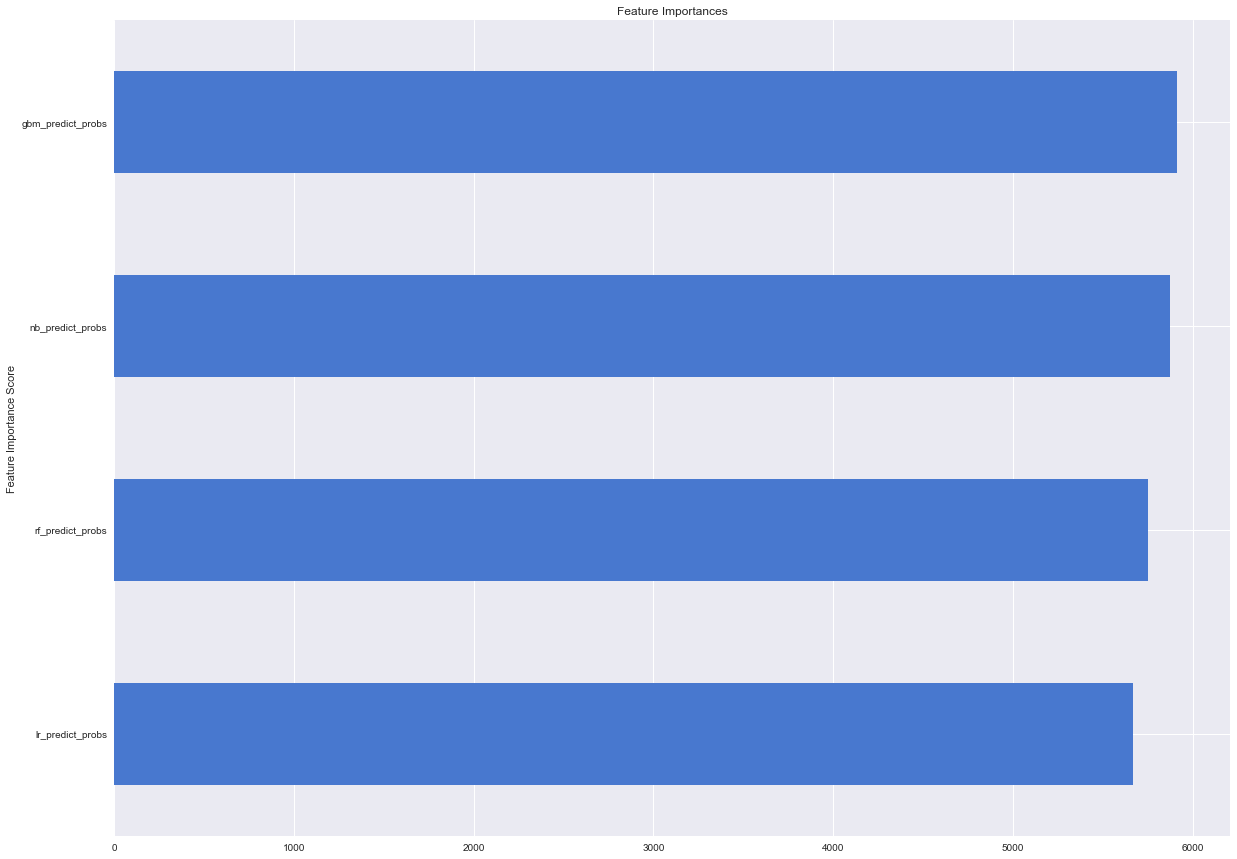

In [15]:
# Manual tuning -- base 0.2797
gbmB2 = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=.8, subsample=0.8, is_unbalance=True,
        learning_rate=0.01, max_bin=500, max_depth=9, metric='auc',
        min_child_samples=10, min_child_weight=5, min_data_in_leaf=12,
        min_split_gain=0, n_estimators=800, nthread=-1, num_leaves=30,
        objective='binary', reg_alpha=0.2, reg_lambda=3, seed=32, silent=True,
        subsample_for_bin=50000, subsample_freq=1)
modelfit(gbmB2, X, y)

Next, we'll try using the predictions (ex. the lgb ones) as added features (vs. the only features) 

In [18]:
use_cols5=['ps_car_11_cat_43', 'ps_ind_05_cat_-1', 'ps_calc_13',
       'ps_cluster50_cat_5', 'ps_calc_17_bin', 'ps_car_12', 'ps_calc_12',
       'ps_car_09_cat_2', 'ps_car_06_cat_11', 'ps_car_15', 'ps_ind_15',
       'ps_calc_02', 'ps_calc_06', 'ps_car_01_cat_11', 'ps_cluster10_cat_7',
       'ps_cluster10_cat_8', 'ps_car_09_cat_1', 'ps_ind_08_bin',
       'ps_ind_16_bin', 'ps_car_14', 'ps_car_01_cat_6', 'ps_ind_17_bin',
       'ps_reg_01', 'ps_calc_16_bin', 'ps_calc_11', 'ps_calc_08',
       'ps_car_09_cat_0', 'ps_car_03_cat_0.0', 'ps_car_06_cat_9',
       'ps_ind_02_cat_2', 'ps_ind_05_cat_0', 'ps_car_11', 'ps_ind_09_bin',
       'ps_calc_01', 'ps_calc_20_bin', 'ps_car_03_cat_1.0', 'ps_ind_03',
       'ps_car_13', 'ps_calc_09', 'ps_cluster10_cat_2', 'ps_reg_02',
       'ps_car_05_cat_1.0', 'ps_calc_19_bin', 'ps_car_05_cat_0.0',
       'ps_cluster10_cat_4', 'ps_calc_04', 'ps_calc_10', 'ps_calc_18_bin',
       'ps_cluster10_cat_0', 'ps_ind_07_bin', 'ps_car_01_cat_9',
       'ps_ind_02_cat_1', 'ps_calc_15_bin', 'ps_cluster100_cat_78',
       'ps_car_06_cat_1', 'ps_calc_07', 'ps_calc_03', 'ps_calc_05',
       'ps_reg_03', 'ps_ind_06_bin', 'ps_car_01_cat_7', 'ps_car_07_cat_0',
       'ps_calc_14', 'ps_car_04_cat_2', 'ps_ind_01', 'lr_predict_probs', 'rf_predict_probs', 'nb_predict_probs']

In [19]:
X = df_B[use_cols5]
y = df_B['target']
train_columns=df_B[use_cols5].columns
print(X.shape, y.shape)

(297606, 68) (297606,)



Model Report
Accuracy : 0.6577
Model's ROC_AUC Score : 0.727
Model's Gini score : 0.454
CV AUC Score : Mean - 0.6381 | Std - 0.003171 | Min - 0.6343 | Max - 0.6438
CV Gini score : 0.2762


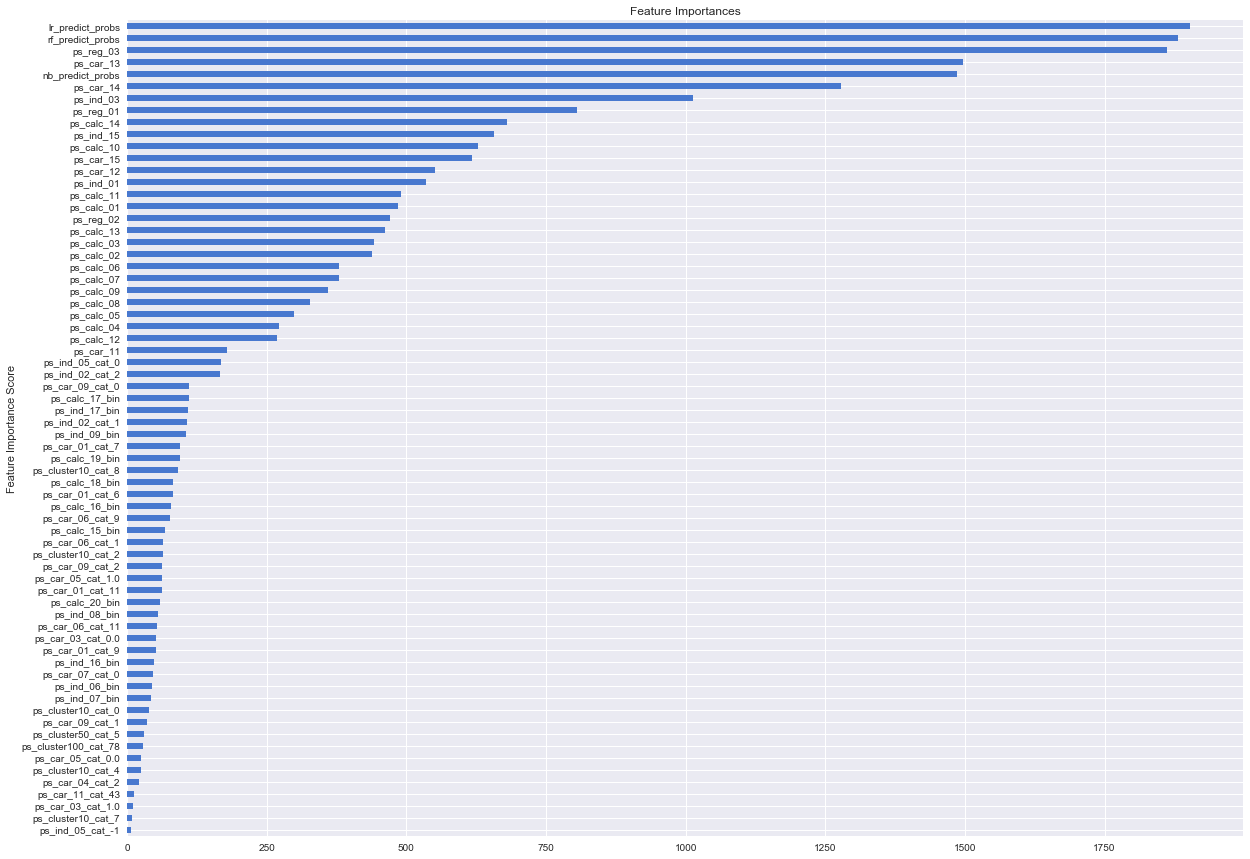

In [20]:
gbmB3 = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=.8, subsample=0.8, is_unbalance=True,
        learning_rate=0.01, max_bin=500, max_depth=9, metric='auc',
        min_child_samples=10, min_child_weight=5, min_data_in_leaf=12,
        min_split_gain=0, n_estimators=800, nthread=-1, num_leaves=30,
        objective='binary', reg_alpha=0.2, reg_lambda=3, seed=32, silent=True,
        subsample_for_bin=50000, subsample_freq=1)
modelfit(gbmB3, X, y)

In [ ]:
# Tune this model 


Model Report
Accuracy : 0.6284
Model's ROC_AUC Score : 0.6692
Model's Gini score : 0.3385
CV AUC Score : Mean - 0.6355 | Std - 0.003512 | Min - 0.6326 | Max - 0.6424
CV Gini score : 0.2711


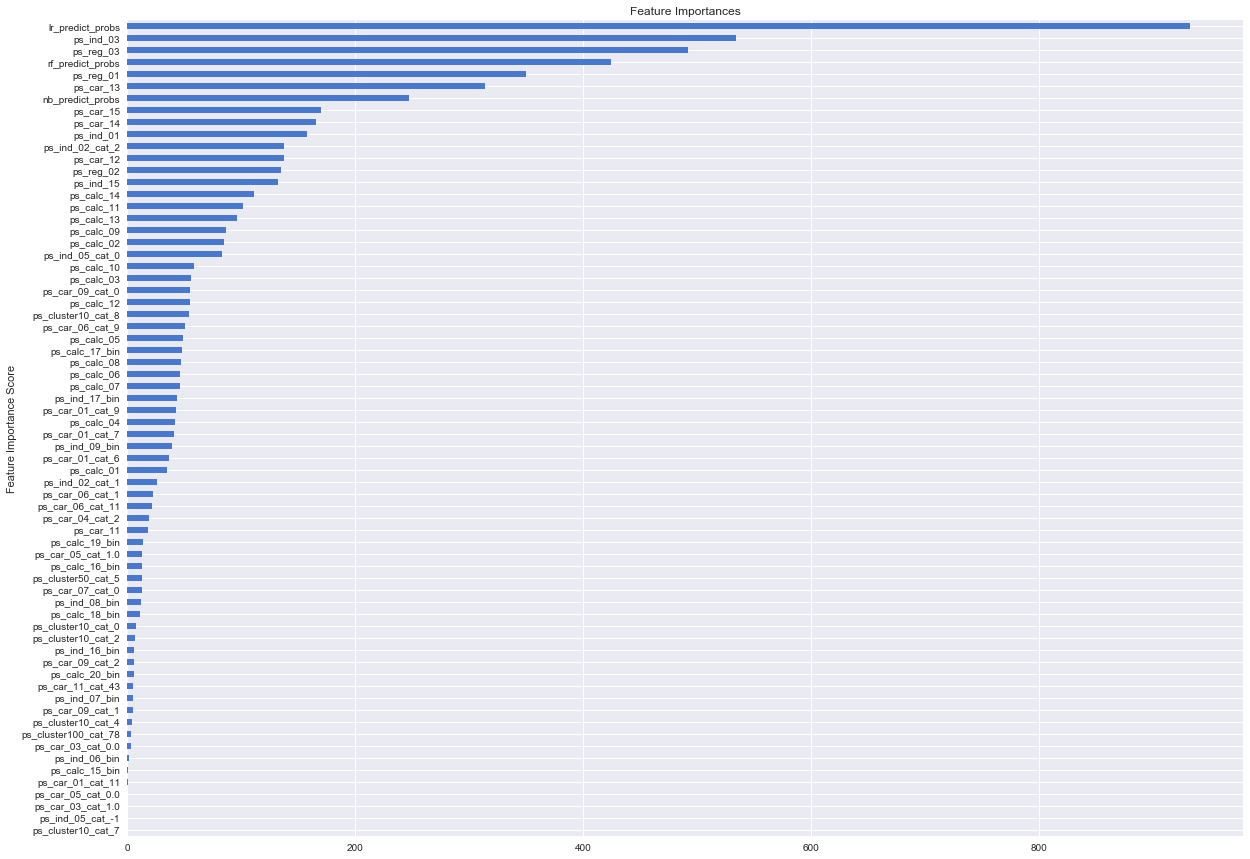

In [70]:
gbmB4 = lgb.LGBMClassifier(boosting_type='gbdt', is_unbalance=True, learning_rate=0.01, n_estimators=200,
        seed=32)
modelfit(gbmB4, X, y)

In [77]:
gbmB4

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, is_unbalance=True,
        learning_rate=0.01, max_bin=255, max_depth=-1,
        min_child_samples=10, min_child_weight=5, min_split_gain=0,
        n_estimators=200, nthread=-1, num_leaves=31, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=32, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1)

In [79]:
param_test2 = {'max_depth':range(5,9,2)}
gsearch2 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, is_unbalance=True,
        learning_rate=0.01, max_bin=255, max_depth=-1,
        min_child_samples=10, min_child_weight=5, min_split_gain=0,
        n_estimators=200, nthread=-1, num_leaves=31, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=32, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1), param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X,y)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63600, std: 0.00342, params: {'max_depth': 5},
  mean: 0.63582, std: 0.00322, params: {'max_depth': 7}],
 {'max_depth': 5},
 0.63600054904823289)


Model Report
Accuracy : 0.6265
Model's ROC_AUC Score : 0.6608
Model's Gini score : 0.3216
CV AUC Score : Mean - 0.636 | Std - 0.003424 | Min - 0.6334 | Max - 0.6427
CV Gini score : 0.272


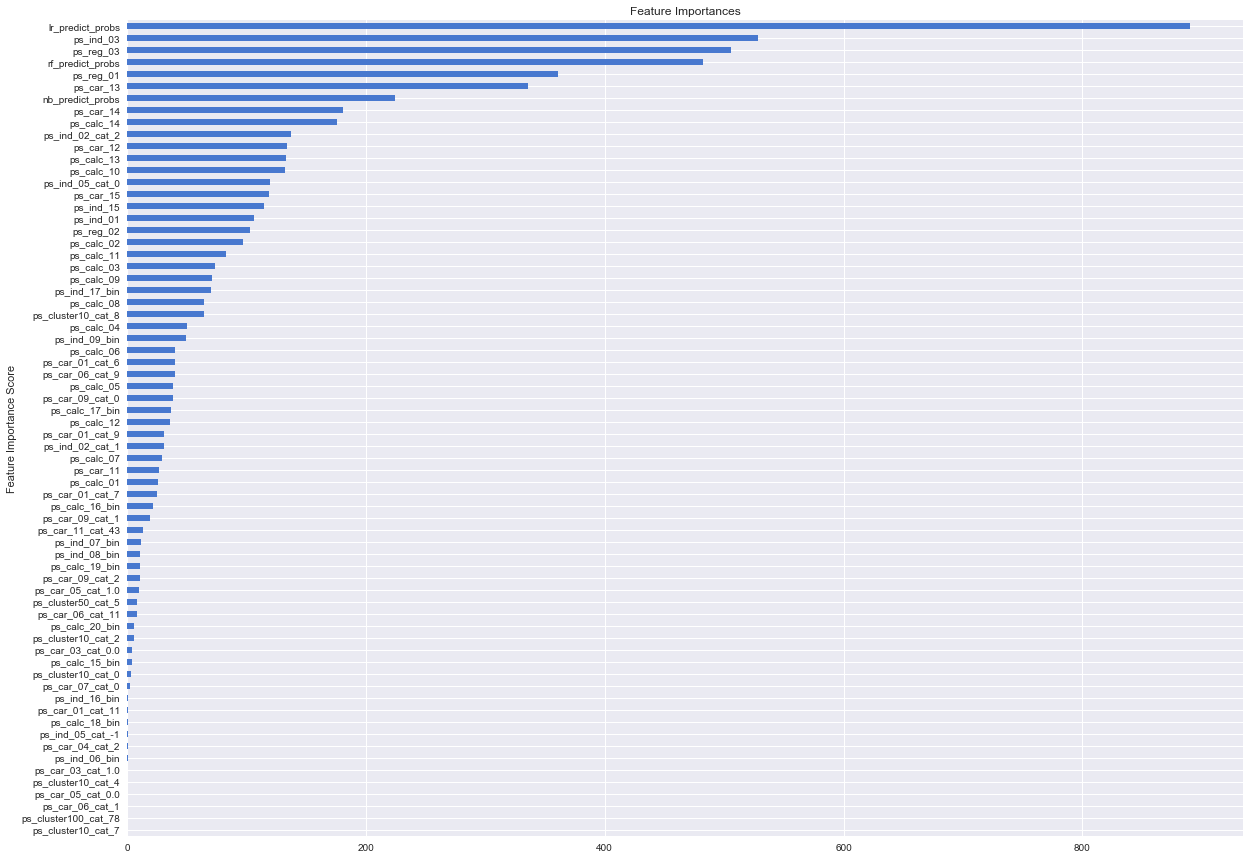

In [80]:
modelfit(gsearch2.best_estimator_, X, y)

In [81]:
gsearch2.best_estimator_

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, is_unbalance=True,
        learning_rate=0.01, max_bin=255, max_depth=5, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=200, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=32, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1)

In [82]:
gc.collect()

22790

In [83]:
param_test2A = {'subsample' : [0.7, 0.8], 'colsample_bytree' : [0.9, 1.0]}
gsearch2A = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, is_unbalance=True,
        learning_rate=0.01, max_bin=255, max_depth=5, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=200, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=32, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1), param_grid = param_test2A, scoring='roc_auc',
        n_jobs=4,iid=False, cv=5, verbose=1)
gsearch2A.fit(X,y)
gsearch2A.grid_scores_, gsearch2A.best_params_, gsearch2A.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  3.0min finished
c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63627, std: 0.00297, params: {'colsample_bytree': 0.9, 'subsample': 0.7},
  mean: 0.63663, std: 0.00299, params: {'colsample_bytree': 0.9, 'subsample': 0.8},
  mean: 0.63611, std: 0.00310, params: {'colsample_bytree': 1.0, 'subsample': 0.7},
  mean: 0.63633, std: 0.00290, params: {'colsample_bytree': 1.0, 'subsample': 0.8}],
 {'colsample_bytree': 0.9, 'subsample': 0.8},
 0.63663066381837186)

In [84]:
modelfit(gsearch2A.best_estimator_, X, y)


Model Report
Accuracy : 0.6285
Model's ROC_AUC Score : 0.6621
Model's Gini score : 0.3243
CV AUC Score : Mean - 0.6366 | Std - 0.002987 | Min - 0.6337 | Max - 0.6421
CV Gini score : 0.2733


In [85]:
gsearch2A.best_estimator_

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.9, is_unbalance=True,
        learning_rate=0.01, max_bin=255, max_depth=5, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=200, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=32, silent=True, subsample=0.8, subsample_for_bin=50000,
        subsample_freq=1)

In [86]:
gc.collect()

23151

In [87]:
param_test3 = {'num_leaves': [20, 25, 30, 35]} 
gsearch3 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.9, is_unbalance=True,
        learning_rate=0.01, max_bin=255, max_depth=5, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=200, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=32, silent=True, subsample=0.8, subsample_for_bin=50000,
        subsample_freq=1), param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5, verbose=1)
gsearch3.fit(X,y)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  3.3min finished
c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63653, std: 0.00303, params: {'num_leaves': 20},
  mean: 0.63677, std: 0.00299, params: {'num_leaves': 25},
  mean: 0.63661, std: 0.00309, params: {'num_leaves': 30},
  mean: 0.63665, std: 0.00307, params: {'num_leaves': 35}],
 {'num_leaves': 25},
 0.63677170826107277)


Model Report
Accuracy : 0.6253
Model's ROC_AUC Score : 0.659
Model's Gini score : 0.318
CV AUC Score : Mean - 0.6368 | Std - 0.002993 | Min - 0.6339 | Max - 0.6424
CV Gini score : 0.2735


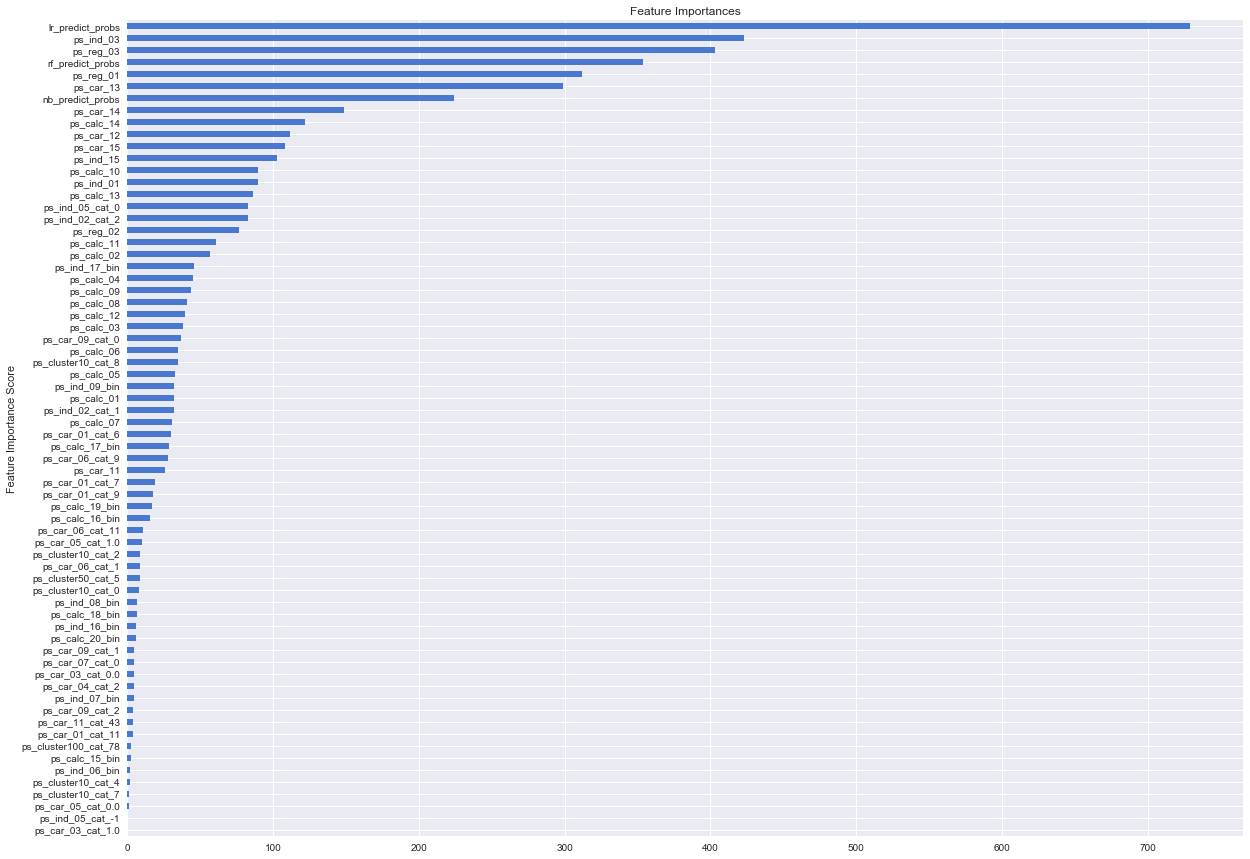

In [88]:
modelfit(gsearch3.best_estimator_, X, y)

In [89]:
gsearch3.best_estimator_

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.9, is_unbalance=True,
        learning_rate=0.01, max_bin=255, max_depth=5, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=200, nthread=-1,
        num_leaves=25, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=32, silent=True, subsample=0.8, subsample_for_bin=50000,
        subsample_freq=1)

In [90]:
gc.collect()

23647

In [92]:
param_test4 =  {'min_data_in_leaf': [7, 9, 11, 20]}
gsearch4 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.9, is_unbalance=True,
        learning_rate=0.01, max_bin=255, max_depth=5, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=200, nthread=-1,
        num_leaves=25, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=32, silent=True, subsample=0.8, subsample_for_bin=50000,
        subsample_freq=1),
        param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)                
gsearch4.fit(X,y)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63674, std: 0.00302, params: {'min_data_in_leaf': 7},
  mean: 0.63677, std: 0.00299, params: {'min_data_in_leaf': 9},
  mean: 0.63677, std: 0.00299, params: {'min_data_in_leaf': 11},
  mean: 0.63677, std: 0.00303, params: {'min_data_in_leaf': 20}],
 {'min_data_in_leaf': 20},
 0.63677268092385098)

In [93]:
modelfit(gsearch4.best_estimator_, X, y)


Model Report
Accuracy : 0.6253
Model's ROC_AUC Score : 0.659
Model's Gini score : 0.318
CV AUC Score : Mean - 0.6368 | Std - 0.00303 | Min - 0.6338 | Max - 0.6425
CV Gini score : 0.2735


In [94]:
gsearch4.best_estimator_

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.9, is_unbalance=True,
        learning_rate=0.01, max_bin=255, max_depth=5, min_child_samples=10,
        min_child_weight=5, min_data_in_leaf=20, min_split_gain=0,
        n_estimators=200, nthread=-1, num_leaves=25, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=32, silent=True, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1)

In [95]:
gc.collect()

23647

In [96]:
param_test5 = {'subsample' : [0.8, 0.9, 0.95, 1.0]}
gsearch5 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.9, is_unbalance=True,
        learning_rate=0.01, max_bin=255, max_depth=5, min_child_samples=10,
        min_child_weight=5, min_data_in_leaf=20, min_split_gain=0,
        n_estimators=200, nthread=-1, num_leaves=25, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=32, silent=True, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1), 
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X,y)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63677, std: 0.00303, params: {'subsample': 0.8},
  mean: 0.63685, std: 0.00301, params: {'subsample': 0.9},
  mean: 0.63667, std: 0.00300, params: {'subsample': 0.95},
  mean: 0.63624, std: 0.00318, params: {'subsample': 1.0}],
 {'subsample': 0.9},
 0.63684910141460327)

In [97]:
modelfit(gsearch5.best_estimator_, X, y)


Model Report
Accuracy : 0.6243
Model's ROC_AUC Score : 0.6587
Model's Gini score : 0.3175
CV AUC Score : Mean - 0.6368 | Std - 0.00301 | Min - 0.6344 | Max - 0.6427
CV Gini score : 0.2737


In [98]:
gsearch5.best_estimator_

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.9, is_unbalance=True,
        learning_rate=0.01, max_bin=255, max_depth=5, min_child_samples=10,
        min_child_weight=5, min_data_in_leaf=20, min_split_gain=0,
        n_estimators=200, nthread=-1, num_leaves=25, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=32, silent=True, subsample=0.9,
        subsample_for_bin=50000, subsample_freq=1)

In [99]:
gc.collect()

23647

In [106]:
param_test6 = {'max_bin' : [225, 250, 275]}
gsearch6 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.9, is_unbalance=True,
        learning_rate=0.01, max_bin=255, max_depth=5, min_child_samples=10,
        min_child_weight=5, min_data_in_leaf=20, min_split_gain=0,
        n_estimators=200, nthread=-1, num_leaves=25, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=32, silent=True, subsample=0.9,
        subsample_for_bin=50000, subsample_freq=1), 
param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X,y)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63667, std: 0.00277, params: {'max_bin': 225},
  mean: 0.63693, std: 0.00302, params: {'max_bin': 250},
  mean: 0.63669, std: 0.00281, params: {'max_bin': 275}],
 {'max_bin': 250},
 0.63692548457044906)


Model Report
Accuracy : 0.6246
Model's ROC_AUC Score : 0.6587
Model's Gini score : 0.3173
CV AUC Score : Mean - 0.6369 | Std - 0.003023 | Min - 0.6343 | Max - 0.6427
CV Gini score : 0.2739


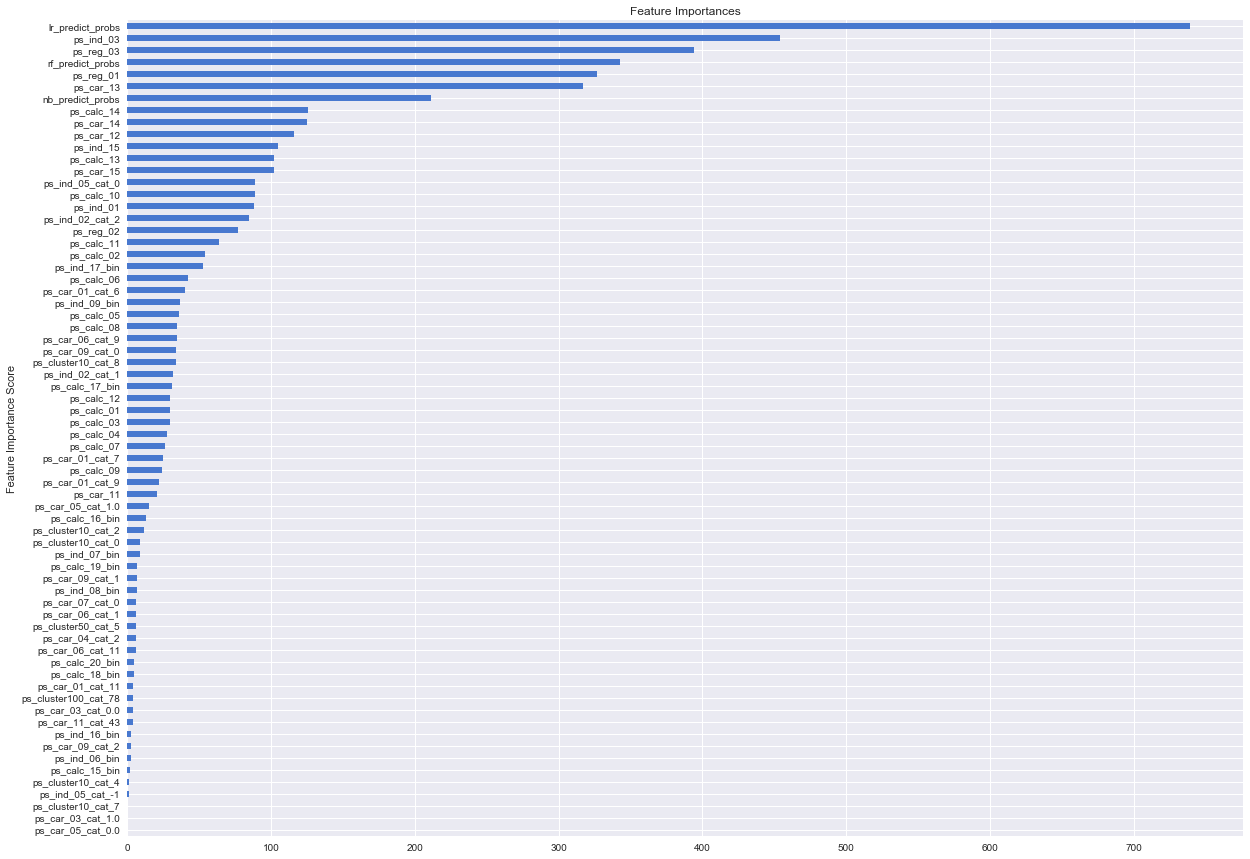

In [107]:
modelfit(gsearch6.best_estimator_, X, y)

In [108]:
gsearch6.best_estimator_

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.9, is_unbalance=True,
        learning_rate=0.01, max_bin=250, max_depth=5, min_child_samples=10,
        min_child_weight=5, min_data_in_leaf=20, min_split_gain=0,
        n_estimators=200, nthread=-1, num_leaves=25, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=32, silent=True, subsample=0.9,
        subsample_for_bin=50000, subsample_freq=1)

In [109]:
gc.collect()

23647

In [115]:
param_test7 = {'learning_rate' : [0.001, 0.005], 'n_estimators' : [1000, 1150, 1300]}
gsearch7 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.9, is_unbalance=True,
        learning_rate=0.01, max_bin=250, max_depth=5, min_child_samples=10,
        min_child_weight=5, min_data_in_leaf=20, min_split_gain=0,
        n_estimators=200, nthread=-1, num_leaves=25, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=32, silent=True, subsample=0.9,
        subsample_for_bin=50000, subsample_freq=1), 
param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(X,y)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63555, std: 0.00266, params: {'learning_rate': 0.001, 'n_estimators': 1000},
  mean: 0.63574, std: 0.00264, params: {'learning_rate': 0.001, 'n_estimators': 1150},
  mean: 0.63596, std: 0.00267, params: {'learning_rate': 0.001, 'n_estimators': 1300},
  mean: 0.63872, std: 0.00288, params: {'learning_rate': 0.005, 'n_estimators': 1000},
  mean: 0.63866, std: 0.00291, params: {'learning_rate': 0.005, 'n_estimators': 1150},
  mean: 0.63841, std: 0.00296, params: {'learning_rate': 0.005, 'n_estimators': 1300}],
 {'learning_rate': 0.005, 'n_estimators': 1000},
 0.6387168458963659)


Model Report
Accuracy : 0.6365
Model's ROC_AUC Score : 0.6816
Model's Gini score : 0.3632
CV AUC Score : Mean - 0.6387 | Std - 0.002876 | Min - 0.6362 | Max - 0.6441
CV Gini score : 0.2774


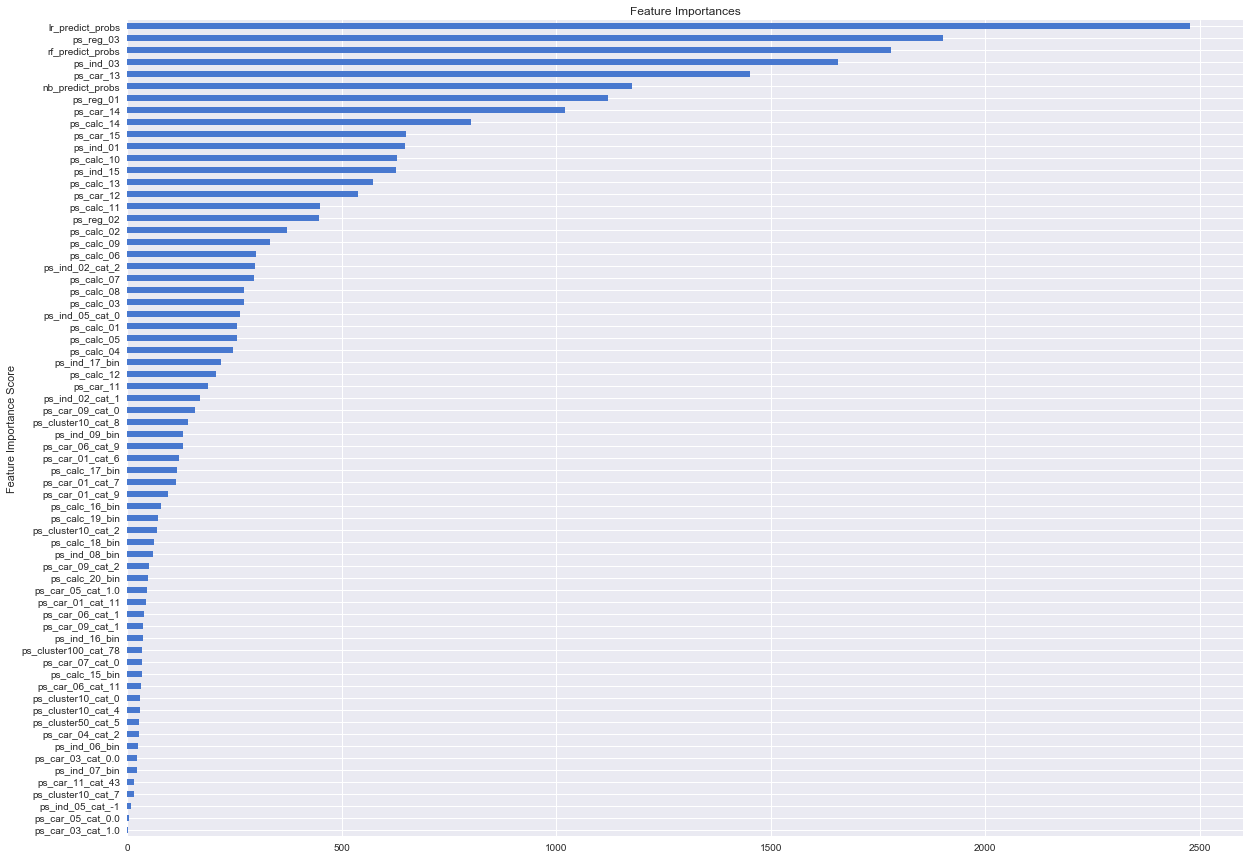

In [116]:
modelfit(gsearch7.best_estimator_, X, y)

In [119]:
gsearch7.best_estimator_

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.9, is_unbalance=True,
        learning_rate=0.005, max_bin=250, max_depth=5,
        min_child_samples=10, min_child_weight=5, min_data_in_leaf=20,
        min_split_gain=0, n_estimators=1000, nthread=-1, num_leaves=25,
        objective='binary', reg_alpha=0, reg_lambda=0, seed=32,
        silent=True, subsample=0.9, subsample_for_bin=50000,
        subsample_freq=1)


Model Report
Accuracy : 0.6362
Model's ROC_AUC Score : 0.6811
Model's Gini score : 0.3622
CV AUC Score : Mean - 0.6388 | Std - 0.00283 | Min - 0.6364 | Max - 0.6442
CV Gini score : 0.2777


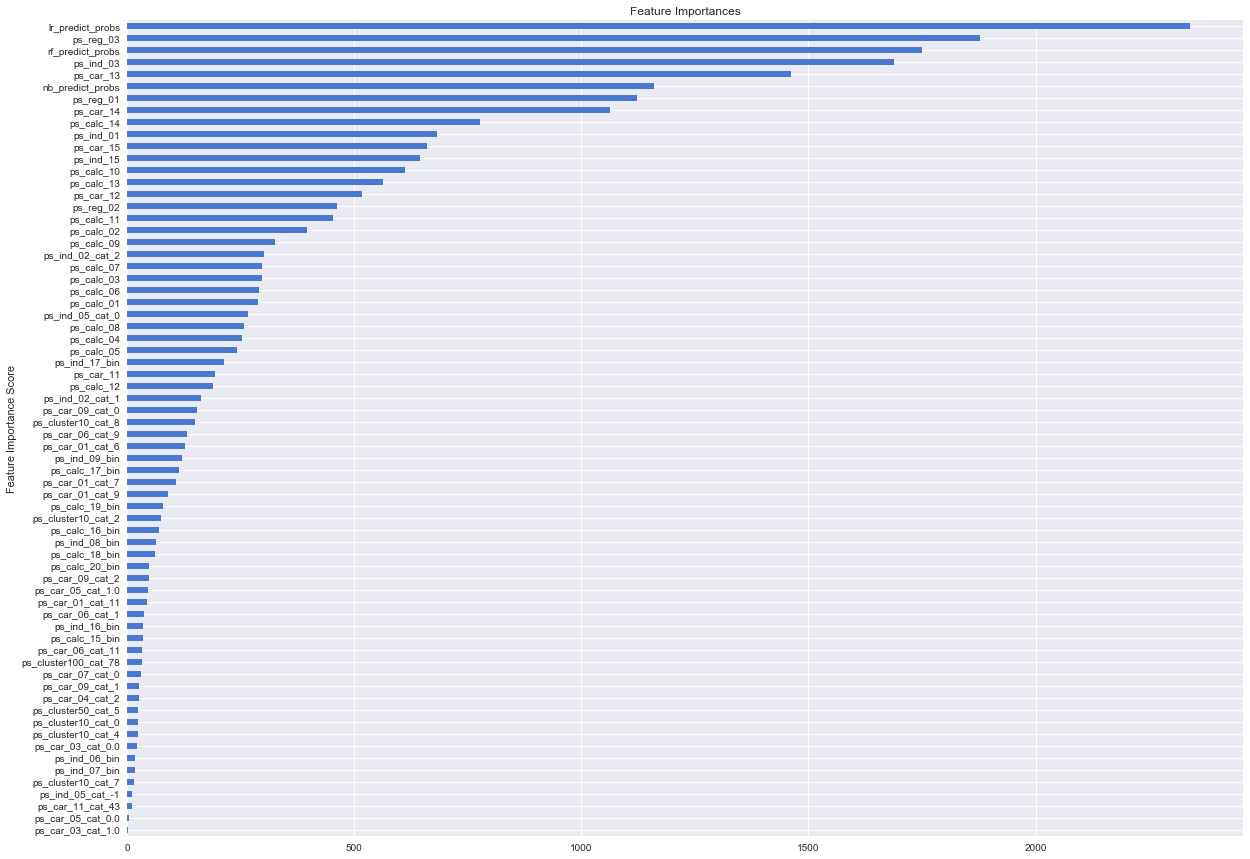

In [120]:
# Manual tuning
gbm0 = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.9, is_unbalance=True,
        learning_rate=0.005, max_bin=250, max_depth=5,
        min_child_samples=10, min_child_weight=5, min_data_in_leaf=20,
        min_split_gain=0, n_estimators=1000, nthread=-1, num_leaves=25,
        objective='binary', reg_alpha=0.2, reg_lambda=3, seed=32,
        silent=True, subsample=0.9, subsample_for_bin=50000,
        subsample_freq=1)
modelfit(gbm0, X, y)

In [122]:
# Prediction of the test dataset using the above tuned model and submission to Kaggle 
X_sub = df_C[use_cols5]
print(X_sub.shape)

(892816, 68)


In [123]:
print('Start predicting...')
y_pred_sub =gbm0.predict_proba(X_sub)[:,1]

Start predicting...


In [124]:
y_pred_sub

array([ 0.39938562,  0.40511476,  0.43416699, ...,  0.52416854,
        0.3744873 ,  0.471042  ])

In [125]:
len(y_pred_sub)

892816

In [128]:
submission= df_test

In [129]:
submission.shape

(892816, 58)

In [130]:
submission['target']=y_pred_sub

In [131]:
submission=submission[['id', 'target']]

In [132]:
submission.shape

(892816, 2)

In [133]:
submission.head()

id    target
0   0  0.399386
1   1  0.405115
2   2  0.434167
3   3  0.312432
4   4  0.523092

In [134]:
submission.tail()

id    target
892811  1488022  0.672746
892812  1488023  0.537236
892813  1488024  0.524169
892814  1488025  0.374487
892815  1488026  0.471042

In [135]:
submission.target.max()

0.83719759298717633

In [136]:
submission.target.min()

0.11736792924729561

In [137]:
submission.to_csv('lgb_v30.csv', index=False, float_format='%.4f')

Another Approach: Prediction Averaging ...

In [61]:
df_S=df_C

In [62]:
df_S.columns


Index(['ps_car_11_cat_43', 'ps_ind_05_cat_-1', 'ps_calc_13',
       'ps_cluster50_cat_5', 'ps_calc_17_bin', 'ps_car_12', 'ps_calc_12',
       'ps_car_09_cat_2', 'ps_car_06_cat_11', 'ps_car_15', 'ps_ind_15',
       'ps_calc_02', 'ps_calc_06', 'ps_car_01_cat_11', 'ps_cluster10_cat_7',
       'ps_cluster10_cat_8', 'ps_car_09_cat_1', 'ps_ind_08_bin',
       'ps_ind_16_bin', 'ps_car_14', 'ps_car_01_cat_6', 'ps_ind_17_bin',
       'ps_reg_01', 'ps_calc_16_bin', 'ps_calc_11', 'ps_calc_08',
       'ps_car_09_cat_0', 'ps_car_03_cat_0.0', 'ps_car_06_cat_9',
       'ps_ind_02_cat_2', 'ps_ind_05_cat_0', 'ps_car_11', 'ps_ind_09_bin',
       'ps_calc_01', 'ps_calc_20_bin', 'ps_car_03_cat_1.0', 'ps_ind_03',
       'ps_car_13', 'ps_calc_09', 'ps_cluster10_cat_2', 'ps_reg_02',
       'ps_car_05_cat_1.0', 'ps_calc_19_bin', 'ps_car_05_cat_0.0',
       'ps_cluster10_cat_4', 'ps_calc_04', 'ps_calc_10', 'ps_calc_18_bin',
       'ps_cluster10_cat_0', 'ps_ind_07_bin', 'ps_car_01_cat_9',
       'ps_ind_02_cat_

In [63]:
df_S['target']=df_S[['lr_predict_probs', 'rf_predict_probs', 'nb_predict_probs', 'gbm_predict_probs']].mean(axis=1)

In [65]:
df_S=df_S[['id', 'target']]

In [66]:
df_S.head()

id    target
595212   0  0.275639
595213   1  0.245247
595214   2  0.308937
595215   3  0.211830
595216   4  0.328442

In [67]:
df_S.to_csv('avg_scores_v1.csv', index=False, float_format='%.4f')

From Kaggle: Your submission scored 0.245.

So far, stacking has not yielded improvements.  One issue is that the lightGBM model worked best with data that was not made categorical and binarized.  Next, we will revert to that data for the core LightGBM model, but import the other models' predictions using the binarized datasets (those models work better with binarized data). 

First, we strip the A, B and C datasets down to their needed elements. 

In [ ]:
# We need just the id's from the A dataset (for merging purposes)
df_A2=df_A[['id']]

In [ ]:
# We need the id's and predictions from the A and B datasets
df_B2=df_B[['lr_predict_probs', 'rf_predict_probs', 'nb_predict_probs','id', 'target']]
df_C2=df_C[['lr_predict_probs', 'rf_predict_probs', 'nb_predict_probs','id']]

In [7]:
# Load the non-binarized dataset 
dfX=pd.read_csv('train_test_processed_v7')

In [ ]:
# Merge B2 and C2 with the non-binarized dataset 

In [8]:
dfX.drop('target', axis=1, inplace=True)

In [9]:
df_B2A=df_B2.merge(dfX, on='id')

In [10]:
df_C2A=df_C2.merge(dfX, on='id')

In [ ]:
# Train the lightGBM model on B2A

In [11]:
X = df_B2A.drop(['id', 'target'], axis=1)
y = df_B2A['target']
train_columns=df_B2A.drop(['id', 'target'], axis=1).columns
print(X.shape, y.shape)

(297606, 60) (297606,)



Model Report
Accuracy : 0.6299
Model's ROC_AUC Score : 0.6706
Model's Gini score : 0.3412
CV AUC Score : Mean - 0.6358 | Std - 0.002683 | Min - 0.6341 | Max - 0.6411
CV Gini score : 0.2716


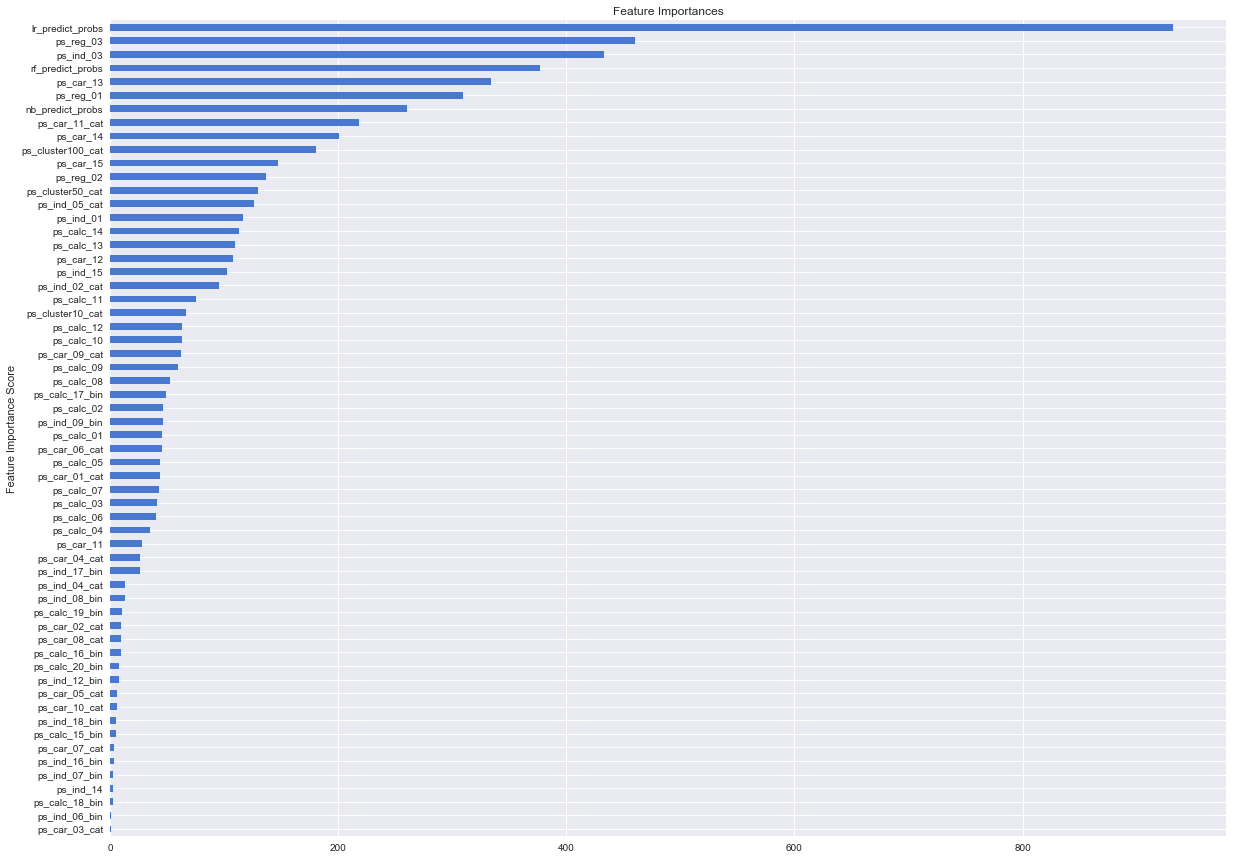

In [15]:
gbm0 = lgb.LGBMClassifier(boosting_type='gbdt', is_unbalance=True,
        learning_rate=0.01, n_estimators=200, seed=32)
modelfit(gbm0, X, y)

In [16]:
gbm0

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, is_unbalance=True,
        learning_rate=0.01, max_bin=255, max_depth=-1,
        min_child_samples=10, min_child_weight=5, min_split_gain=0,
        n_estimators=200, nthread=-1, num_leaves=31, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=32, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1)

In [17]:
param_test8 = {'max_depth' : [5, 7, 9, 11]}
gsearch8 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, is_unbalance=True,
        learning_rate=0.01, max_bin=255, max_depth=-1,
        min_child_samples=10, min_child_weight=5, min_split_gain=0,
        n_estimators=200, nthread=-1, num_leaves=31, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=32, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1), 
param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch8.fit(X,y)
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63586, std: 0.00300, params: {'max_depth': 5},
  mean: 0.63619, std: 0.00271, params: {'max_depth': 7},
  mean: 0.63585, std: 0.00271, params: {'max_depth': 9},
  mean: 0.63581, std: 0.00265, params: {'max_depth': 11}],
 {'max_depth': 7},
 0.63619007385418269)

In [19]:
param_test8 = {'min_data_in_leaf' : [5, 7, 9, 11]}
gsearch8 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, is_unbalance=True,
        learning_rate=0.01, max_bin=255, max_depth=7, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=200, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=32, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1), 
param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch8.fit(X,y)
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63617, std: 0.00287, params: {'min_data_in_leaf': 5},
  mean: 0.63621, std: 0.00284, params: {'min_data_in_leaf': 7},
  mean: 0.63629, std: 0.00286, params: {'min_data_in_leaf': 9},
  mean: 0.63627, std: 0.00280, params: {'min_data_in_leaf': 11}],
 {'min_data_in_leaf': 9},
 0.6362899680045293)

In [22]:
param_test9 = {'subsample' : [0.8, 0.9], 'colsample_bytree' : [0.8, 0.9, 1.0]}
gsearch9 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, is_unbalance=True,
        learning_rate=0.01, max_bin=255, max_depth=7, min_child_samples=10,
        min_child_weight=5, min_data_in_leaf=9, min_split_gain=0,
        n_estimators=200, nthread=-1, num_leaves=31, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=32, silent=True, subsample=1,
        subsample_for_bin=50000, subsample_freq=1), 
param_grid = param_test9, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch9.fit(X,y)
gsearch9.grid_scores_, gsearch9.best_params_, gsearch9.best_score_

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63700, std: 0.00259, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.63654, std: 0.00282, params: {'colsample_bytree': 0.8, 'subsample': 0.9},
  mean: 0.63672, std: 0.00295, params: {'colsample_bytree': 0.9, 'subsample': 0.8},
  mean: 0.63630, std: 0.00285, params: {'colsample_bytree': 0.9, 'subsample': 0.9},
  mean: 0.63645, std: 0.00251, params: {'colsample_bytree': 1.0, 'subsample': 0.8},
  mean: 0.63629, std: 0.00272, params: {'colsample_bytree': 1.0, 'subsample': 0.9}],
 {'colsample_bytree': 0.8, 'subsample': 0.8},
 0.63699608486214099)

In [23]:
gsearch9.best_estimator_

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.8, is_unbalance=True,
        learning_rate=0.01, max_bin=255, max_depth=7, min_child_samples=10,
        min_child_weight=5, min_data_in_leaf=9, min_split_gain=0,
        n_estimators=200, nthread=-1, num_leaves=31, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=32, silent=True, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1)

In [27]:
param_test8 = {'num_leaves' : [40, 50, 60]}
gsearch8 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.8, is_unbalance=True,
        learning_rate=0.005, max_bin=255, max_depth=7, min_child_samples=10,
        min_child_weight=5, min_data_in_leaf=9, min_split_gain=0,
        n_estimators=200, nthread=-1, num_leaves=31, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=32, silent=True, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1), 
param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch8.fit(X,y)
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63596, std: 0.00250, params: {'num_leaves': 40},
  mean: 0.63586, std: 0.00235, params: {'num_leaves': 50},
  mean: 0.63585, std: 0.00246, params: {'num_leaves': 60}],
 {'num_leaves': 40},
 0.63596261884888627)

In [24]:
gc.collect()

100

In [28]:
param_test7 = {'n_estimators' : [1000, 1500, 2000]}
gsearch7 = GridSearchCV(estimator = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.8, is_unbalance=True,
        learning_rate=0.005, max_bin=255, max_depth=7, min_child_samples=10,
        min_child_weight=5, min_data_in_leaf=9, min_split_gain=0,
        n_estimators=200, nthread=-1, num_leaves=31, objective='binary',
        reg_alpha=0, reg_lambda=0, seed=32, silent=True, subsample=0.8,
        subsample_for_bin=50000, subsample_freq=1), 
param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(X,y)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

c:\users\robert mckee\anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63883, std: 0.00277, params: {'n_estimators': 1000},
  mean: 0.63832, std: 0.00292, params: {'n_estimators': 1500},
  mean: 0.63724, std: 0.00253, params: {'n_estimators': 2000}],
 {'n_estimators': 1000},
 0.63882664153480428)

In [29]:
gsearch7.best_estimator_

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.8, is_unbalance=True,
        learning_rate=0.005, max_bin=255, max_depth=7,
        min_child_samples=10, min_child_weight=5, min_data_in_leaf=9,
        min_split_gain=0, n_estimators=1000, nthread=-1, num_leaves=31,
        objective='binary', reg_alpha=0, reg_lambda=0, seed=32,
        silent=True, subsample=0.8, subsample_for_bin=50000,
        subsample_freq=1)

In [30]:
gbm0 = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.8, is_unbalance=True,
        learning_rate=0.005, max_bin=255, max_depth=7,
        min_child_samples=10, min_child_weight=5, min_data_in_leaf=9,
        min_split_gain=0, n_estimators=1000, nthread=-1, num_leaves=31,
        objective='binary', reg_alpha=0, reg_lambda=0, seed=32,
        silent=True, subsample=0.8, subsample_for_bin=50000,
        subsample_freq=1)
modelfit(gbm0, X, y)


Model Report
Accuracy : 0.6457
Model's ROC_AUC Score : 0.7017
Model's Gini score : 0.4034
CV AUC Score : Mean - 0.6388 | Std - 0.002772 | Min - 0.6364 | Max - 0.6442
CV Gini score : 0.2777



Model Report
Accuracy : 0.6498
Model's ROC_AUC Score : 0.7086
Model's Gini score : 0.4172
CV AUC Score : Mean - 0.6391 | Std - 0.002742 | Min - 0.6362 | Max - 0.6443
CV Gini score : 0.2781


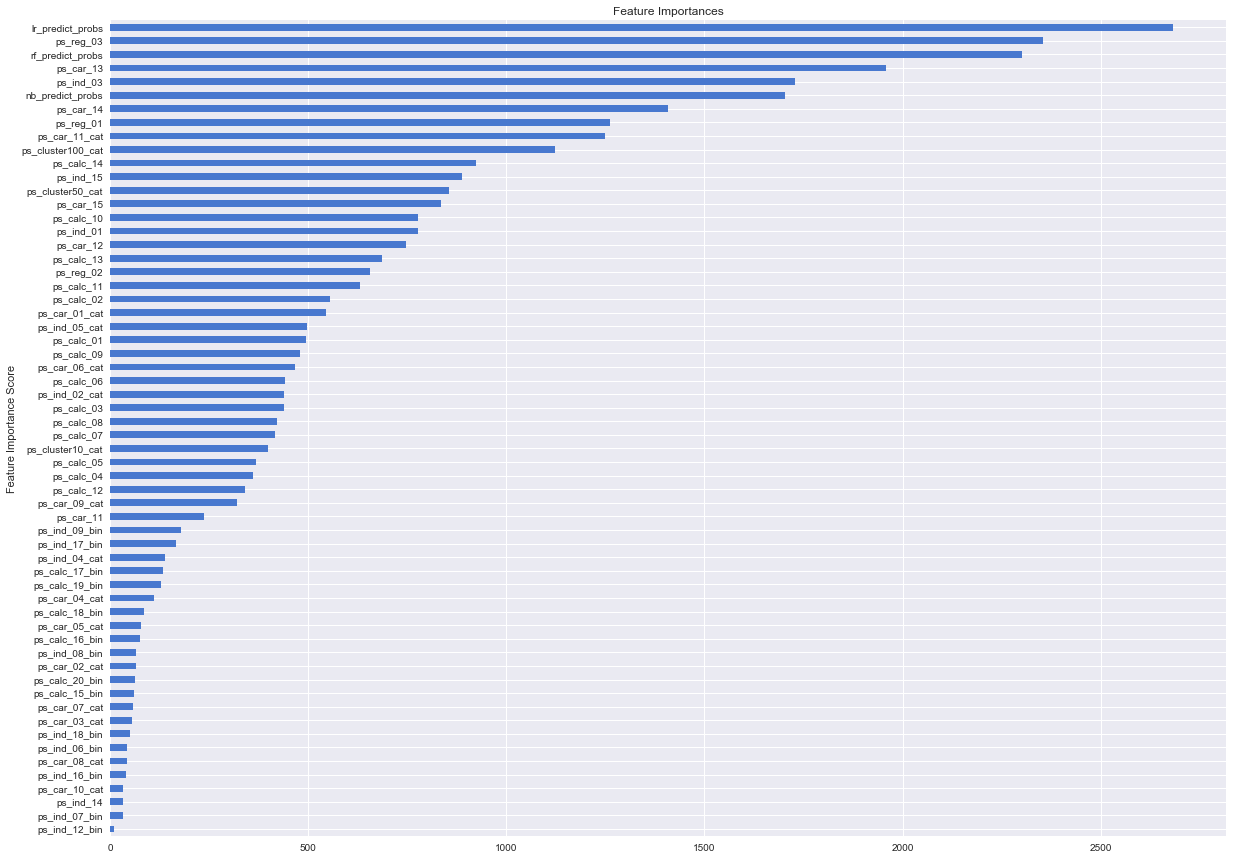

In [32]:
gbm0 = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.8, is_unbalance=True,
        learning_rate=0.005, max_bin=255, max_depth=7,
        min_child_samples=10, min_child_weight=5, min_data_in_leaf=9,
        min_split_gain=0, n_estimators=1150, nthread=-1, num_leaves=31,
        objective='binary', reg_alpha=0.2, reg_lambda=3, seed=32,
        silent=True, subsample=0.8, subsample_for_bin=50000,
        subsample_freq=1)
modelfit(gbm0, X, y)

In [42]:
X_sub = df_C2A.drop('id', axis=1)
print('Start predicting...')
y_pred_sub =gbm0.predict_proba(X_sub)[:,1]
y_pred_sub

Start predicting...


array([ 0.39818726,  0.35766507,  0.42935994, ...,  0.52577205,
        0.35700827,  0.43733307])

In [43]:
submission= df_test

In [44]:
submission['target']=y_pred_sub

In [45]:
submission=submission[['id', 'target']]

In [46]:
submission.to_csv('lgb_v33.csv', index=False, float_format='%.4f')

From Kaggle: Your submission scored 0.267, which is not an improvement of your best score. Keep trying!